In [21]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import datetime

from sklearn.metrics import mean_absolute_error

from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation, performance_metrics

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plt.rcParams['figure.figsize'] = [16, 8]
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [201]:
atl_df = pd.read_csv('../data/atl_df.csv', index_col = None)
atl_df

zipcode period_start  mean_rent_mf  median_rent_mf  sf_rental_index  \
0       30002   2018-12-01    864.321429      861.000000       139.455839   
1       30002   2019-01-01    866.969780      865.500000       140.034157   
2       30002   2019-02-01    870.157967      871.500000       140.591074   
3       30002   2019-03-01    878.043956      887.500000       141.285830   
4       30002   2019-04-01    881.304945      890.000000       142.134718   
...       ...          ...           ...             ...              ...   
2965    30363   2023-02-01   2625.106881     2521.533981       321.929191   
2966    30363   2023-03-01   2622.521827     2527.434211       323.787196   
2967    30363   2023-04-01   2619.936774     2517.072368       324.655463   
2968    30363   2023-05-01   2617.351720     2506.710526       326.057108   
2969    30363   2023-06-01   2615.314966     2496.276316       325.985176   

      trans_period      coef  sf_price_index  student_population_fraction  \
0            144.0  0.112014      112.494762                       0.0672   
1            145.0  0.108432      112.353442                       0.0672   
2            146.0  0.136117      112.587389                       0.0672   
3            147.0  0.154795      113.908682                       0.0672   
4            148.0  0.146306      114.133338                       0.0672   
...            ...       ...             ...                          ...   
2965         194.0  0.471078      159.063094                       0.3436   
2966         195.0  0.489442      159.665698                       0.3436   
2967         196.0  0.505767      160.315226                       0.3436   
2968         197.0  0.509293      162.074694                       0.3436   
2969         198.0  0.517288      163.756843                       0.3436   

      population  netflow_estimated  inflow_estimated  outflow_estimated  \
0           6560                -29                45                 74   
1           6560                -26                65                 91   
2           6560                -25                68                 93   
3           6560                -22                69                 91   
4           6560                -37                76                113   
...          ...                ...               ...                ...   
2965        4411                -13                25                 38   
2966        4411                -12                29                 41   
2967        4411                -26                27                 53   
2968        4411                -24                37                 61   
2969        4411                -19                31                 50   

      netflow_estimated_normalized  inflow_estimated_normalized  \
0                              -26                           41   
1                              -23                           59   
2                              -25                           68   
3                              -20                           62   
4                              -35                           71   
...                            ...                          ...   
2965                           -13                           25   
2966                           -11                           26   
2967                           -24                           25   
2968                           -22                           33   
2969                           -18                           29   

      outflow_estimated_normalized  cumulative_netflow_estimated  \
0                               67                             0   
1                               82                           -26   
2                               93                           -51   
3                               82                           -73   
4                              105                          -110   
...                           

In [202]:
# rename columns to Prophet's expected names
atl_df.rename({'period_start': 'ds', 'sf_rental_index': 'y'}, axis = 1, inplace = True) 
atl_df.index = pd.DatetimeIndex(atl_df['ds'])

### Univariate: Sample Zipcode

In [203]:
# sample df for one zipcode
atl_df_samp = atl_df[atl_df['zipcode'] == 30363]

In [204]:
# initiate Prophet object
model = Prophet()

# fit model
model.fit(atl_df_samp)

16:38:18 - cmdstanpy - INFO - Chain [1] start processing
16:38:19 - cmdstanpy - INFO - Chain [1] done processing


In [205]:
# create future dates for prediction
future = model.make_future_dataframe(periods=12, freq='MS') # set frequency to monthly
future.tail()

ds
62 2024-02-01
63 2024-03-01
64 2024-04-01
65 2024-05-01
66 2024-06-01

In [206]:
# forecast object contains yhat for all time stamps

forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

ds        yhat  yhat_lower  yhat_upper
0  2018-12-01  189.540693  189.200170  189.875744
1  2019-01-01  191.164662  190.819418  191.482389
2  2019-02-01  192.910008  192.594422  193.229928
3  2019-03-01  194.751474  194.423146  195.080993
4  2019-04-01  196.447204  196.122259  196.765873
5  2019-05-01  198.075629  197.727534  198.407797
6  2019-06-01  198.948071  198.597176  199.288927
7  2019-07-01  201.030972  200.720002  201.365396
8  2019-08-01  202.973330  202.662628  203.285152
9  2019-09-01  203.899636  203.555049  204.208329
10 2019-10-01  205.203066  204.848568  205.520631
11 2019-11-01  205.680436  205.372284  206.008211
12 2019-12-01  206.560553  206.237572  206.881574
13 2020-01-01  207.977585  207.671494  208.313788
14 2020-02-01  209.334687  209.036923  209.660298
15 2020-03-01  210.401873  210.076402  210.727268
16 2020-04-01  212.225162  211.899695  212.551035
17 2020-05-01  212.892419  212.576060  213.207273
18 2020-06-01  212.813593  212.491879  213.116626
19 2020-07-01  213.707665  213.397147  214.067760
20 2020-08-01  215.507119  215.195731  215.822108
21 2020-09-01  217.477868  217.147167  217.815466
22 2020-10-01  219.906614  219.584532  220.244518
23 2020-11-01  223.240799  222.934457  223.587938
24 2020-12-01  226.367679  226.041148  226.679378
25 2021-01-01  229.587793  229.272013  229.940044
26 2021-02-01  233.275634  232.925920  233.609216
27 2021-03-01  237.308177  236.993103  237.648874
28 2021-04-01  241.585650  241.255236  241.897618
29 2021-05-01  246.281015  245.958565  246.605390
30 2021-06-01  252.498884  252.165090  252.822317
31 2021-07-01  259.580428  259.253812  259.913030
32 2021-08-01  266.884019  266.564140  267.205117
33 2021-09-01  273.956514  273.641854  274.273805
34 2021-10-01  280.207441  279.910869  280.522734
35 2021-11-01  285.345865  285.017705  285.679305
36 2021-12-01  290.385113  290.064399  290.707510
37 2022-01-01  293.356261  293.006746  293.692774
38 2022-02-01  296.624726  296.319738  296.983760
39 2022-03-01  299.939179  299.618327  300.254320
40 2022-04-01  303.185879  302.826603  303.532466
41 2022-05-01  306.582896  306.237444  306.901310
42 2022-06-01  309.423626  309.077214  309.739799
43 2022-07-01  313.326422  312.987066  313.633760
44 2022-08-01  314.824639  314.529461  315.148151
45 2022-09-01  315.695862  315.369509  316.015529
46 2022-10-01  316.445218  316.106423  316.760650
47 2022-11-01  317.295595  316.964030  317.650002
48 2022-12-01  318.357814  318.030335  318.665036
49 2023-01-01  319.904872  319.577576  320.253690
50 2023-02-01  321.573307  321.263466  321.918406
51 2023-03-01  323.345306  322.999801  323.670780
52 2023-04-01  324.658013  324.328870  324.986475
53 2023-05-01  325.915769  325.606837  326.235699
54 2023-06-01  326.406241  326.097152  326.759436
55 2023-07-01  328.119493  327.682768  328.552603
56 2023-08-01  329.682861  328.847442  330.535350
57 2023-09-01  330.230177  328.541479  331.975215
58 2023-10-01  331.166844  328.475005  333.855369
59 2023-11-01  331.833662  327.808932  336.117913
60 2023-12-01  332.897117  327.700887  338.542574
61 2024-01-01  334.667409  327.663758  342.011097
62 2024-02-01  336.377773  327.824618  345.148996
63 2024-03-01  337.772133  327.501428  348.430318
64 2024-04-01  339.943822  327.940423  352.356898
65 2024-05-01  340.948241  327.162163  355.587988
66 2024-06-01  341.217815  325.675062  358.125940

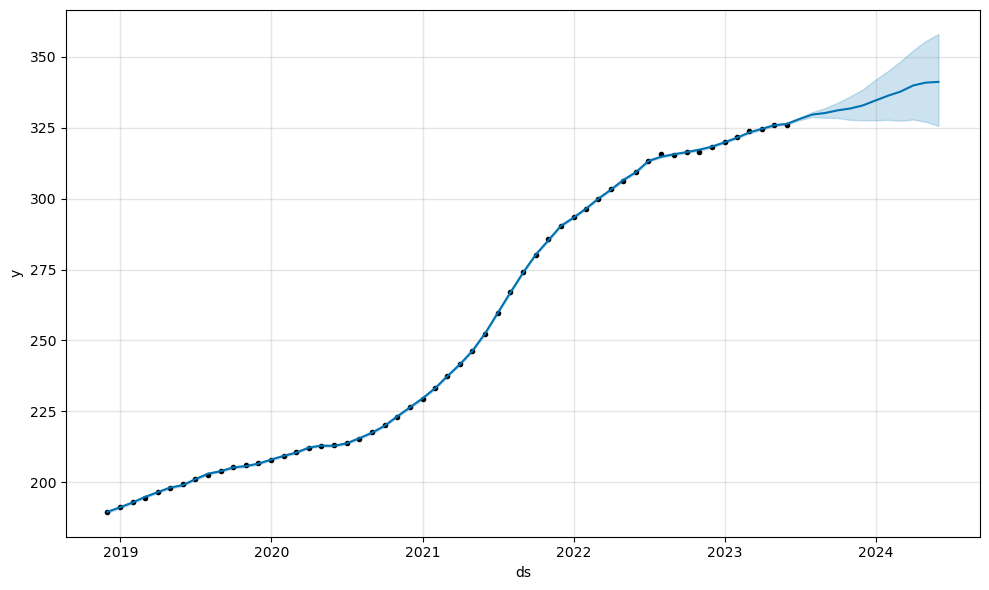

In [207]:
# plot prediction
fig1 = model.plot(forecast)

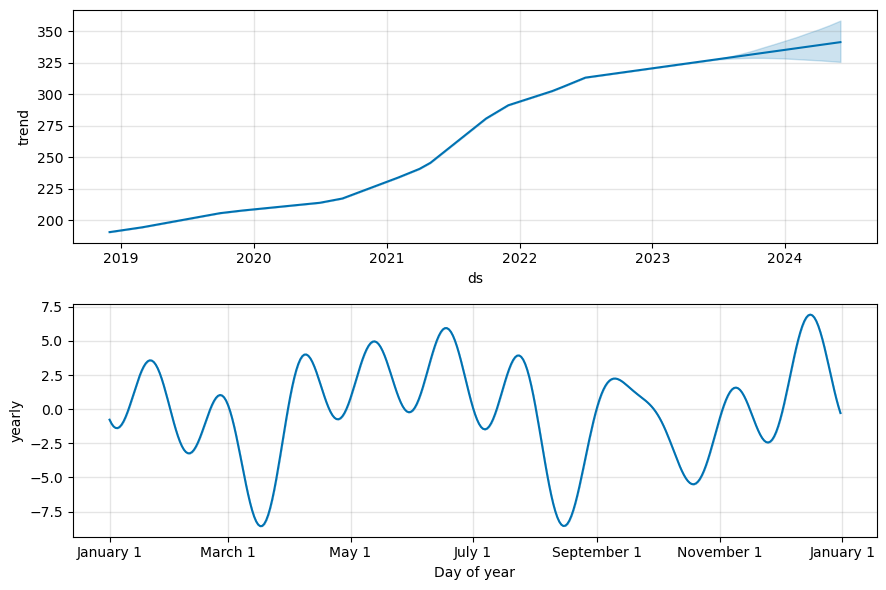

In [208]:
# plot decomposition results
fig2 = model.plot_components(forecast)

In [209]:
forecast.set_index('ds', inplace = True)

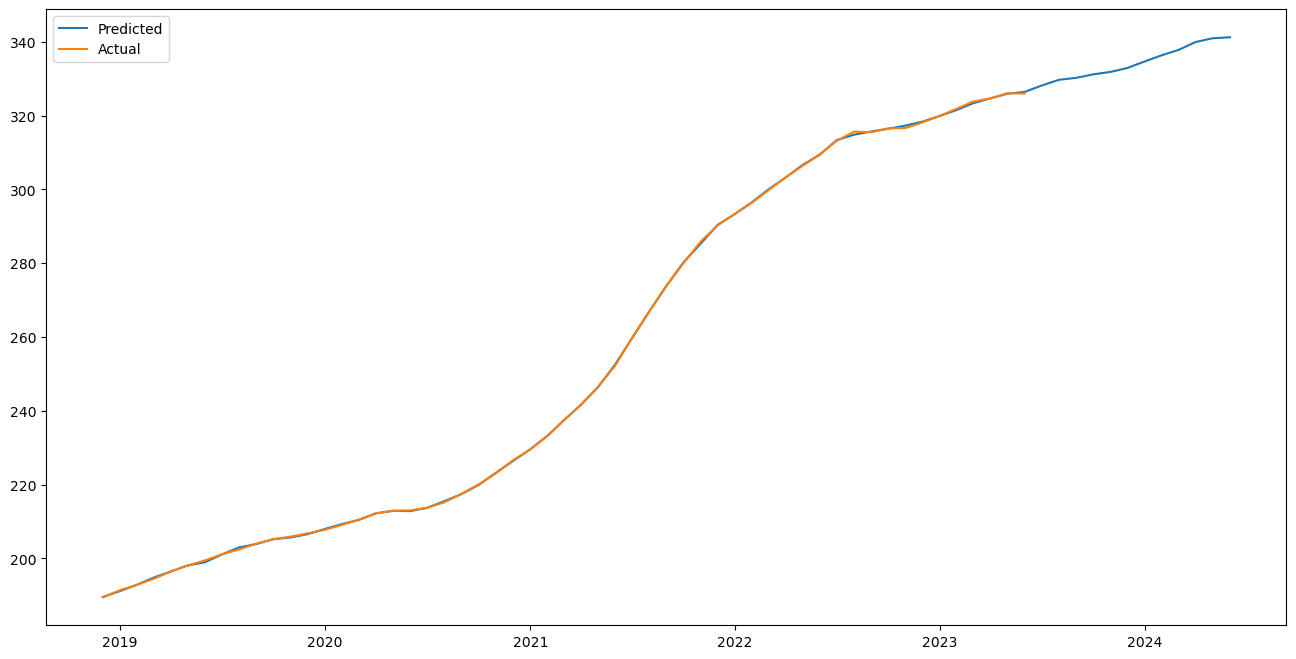

In [210]:
# plot actual vs predicted
y_true = atl_df_samp['y']
y_pred = forecast['yhat']

plt.plot(y_pred, label='Predicted')
plt.plot(y_true, label='Actual')

plt.legend()
plt.show()

### Univariate: Train Test Split

In [ ]:
# group by zipcode?
# https://www.kaggle.com/code/bagavathypriya/multivariate-time-series-using-fb-prophet

In [219]:
# create train test split
from sklearn.model_selection import TimeSeriesSplit
tss = TimeSeriesSplit(n_splits = 2, test_size = 6) # hold out 6 months as test set

for train_index, test_index in tss.split(atl_df_samp):
    df_train, df_test = atl_df_samp.iloc[train_index, :], atl_df_samp.iloc[test_index,:]

In [214]:
df_train.index

DatetimeIndex(['2018-12-01', '2019-01-01', '2019-02-01', '2019-03-01',
               '2019-04-01', '2019-05-01', '2019-06-01', '2019-07-01',
               '2019-08-01', '2019-09-01', '2019-10-01', '2019-11-01',
               '2019-12-01', '2020-01-01', '2020-02-01', '2020-03-01',
               '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01',
               '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01',
               '2020-12-01', '2021-01-01', '2021-02-01', '2021-03-01',
               '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01',
               '2021-08-01', '2021-09-01', '2021-10-01', '2021-11-01',
               '2021-12-01', '2022-01-01', '2022-02-01', '2022-03-01',
               '2022-04-01', '2022-05-01', '2022-06-01', '2022-07-01',
               '2022-08-01', '2022-09-01', '2022-10-01', '2022-11-01',
               '2022-12-01'],
              dtype='datetime64[ns]', name='ds', freq=None)

In [215]:
df_test.index

DatetimeIndex(['2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01',
               '2023-05-01', '2023-06-01'],
              dtype='datetime64[ns]', name='ds', freq=None)

In [220]:
# initiate Prophet object
model = Prophet()

# fit model
model.fit(df_train) # fit on training only

16:40:07 - cmdstanpy - INFO - Chain [1] start processing
16:40:08 - cmdstanpy - INFO - Chain [1] done processing


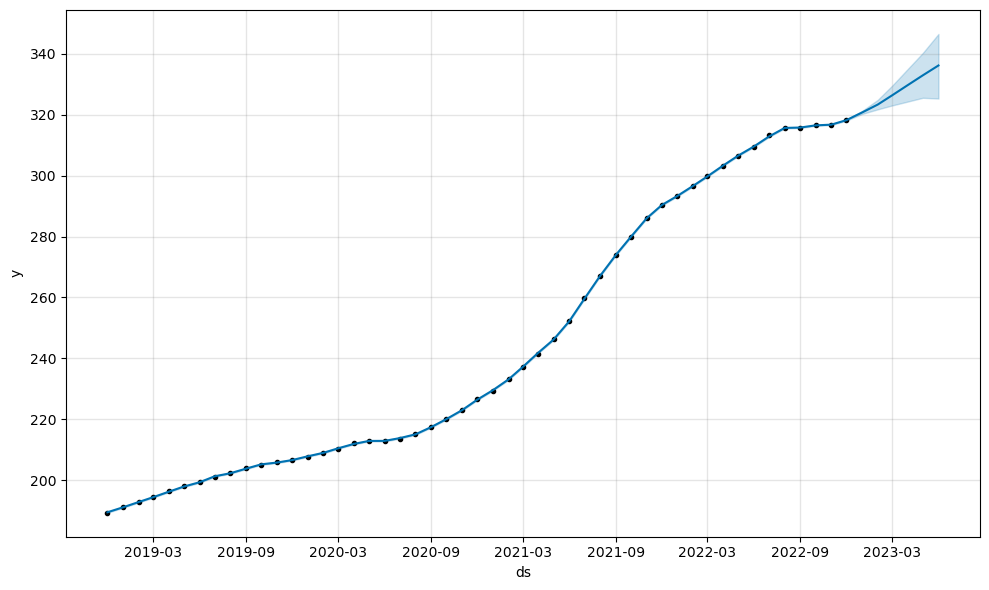

In [221]:
# make yhat predictions on entire data set
forecast = model.predict(atl_df_samp)
fig1 = model.plot(forecast)

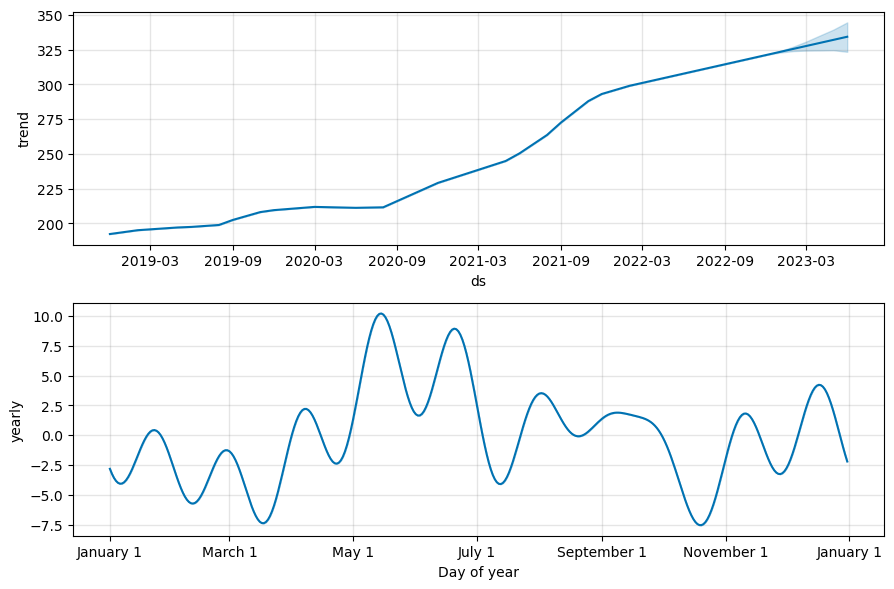

In [222]:
fig2 = model.plot_components(forecast) 

In [223]:
forecast.tail()
# need to look into what each of these predicted values represent (upper/lower bounds)

ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
50 2023-02-01  325.497552  321.693937  324.821486   323.929156   327.119915   
51 2023-03-01  327.532369  322.954433  329.394555   324.278526   330.687545   
52 2023-04-01  329.785202  324.235508  334.880535   324.368151   335.087785   
53 2023-05-01  331.965364  325.481211  340.181450   324.578512   339.312496   
54 2023-06-01  334.218197  325.240384  346.423305   323.394947   344.550824   

    additive_terms  additive_terms_lower  additive_terms_upper    yearly  \
50       -2.228634             -2.228634             -2.228634 -2.228634   
51       -1.287407             -1.287407             -1.287407 -1.287407   
52       -0.173690             -0.173690             -0.173690 -0.173690   
53        0.874198              0.874198              0.874198  0.874198   
54        1.862576              1.862576              1.862576  1.862576   

    yearly_lower  yearly_upper  multiplicative_terms  \
50     -2.228634     -2.228634                   0.0   
51     -1.287407     -1.287407                   0.0   
52     -0.173690     -0.173690                   0.0   
53      0.874198      0.874198                   0.0   
54      1.862576      1.862576                   0.0   

    multiplicative_terms_lower  multiplicative_terms_upper        yhat  
50                         0.0                         0.0  323.268917  
51                         0.0                         0.0  326.244962  
52                         0.0                         0.0  329.611512  
53                         0.0                         0.0  332.839562  
54                         0.0                         0.0  336.080774

In [224]:
# calculate MAE between expected and predicted values on entire time series
y_true = atl_df_samp['y'].values
y_pred = forecast['yhat'].values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)

MAE: 0.571


In [225]:
# to plot true and predicted, need time index
forecast.set_index('ds', inplace = True)

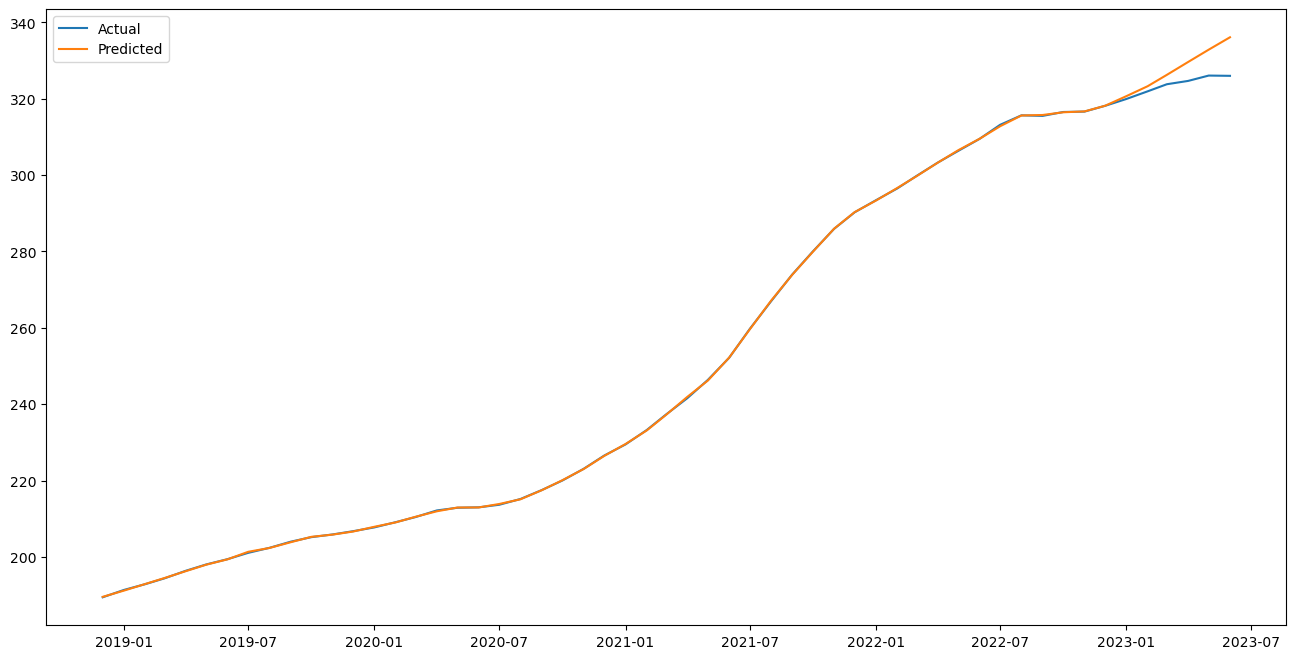

In [226]:
# plot actual vs predicted
y_true = atl_df_samp['y']
y_pred = forecast['yhat']

plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

### Univariate - Cross-Validation

In [193]:
# initiate Prophet object
model = Prophet()

model.fit(atl_df_samp)

16:27:21 - cmdstanpy - INFO - Chain [1] start processing
16:27:21 - cmdstanpy - INFO - Chain [1] done processing


In [194]:
cutoffs = pd.to_datetime(['2022-12-01'])
df_cv = cross_validation(model, cutoffs=cutoffs, horizon='180 days')
#df_cv = cross_validation(model, initial='1000 days', period='30 days', horizon = '180 days')
df_cv

  0%|          | 0/1 [00:00<?, ?it/s]

16:27:25 - cmdstanpy - INFO - Chain [1] start processing
16:27:25 - cmdstanpy - INFO - Chain [1] done processing


ds        yhat  yhat_lower  yhat_upper           y     cutoff
0 2023-01-01  320.667002  320.196326  321.117970  319.929391 2022-12-01
1 2023-02-01  323.268917  321.578486  324.728506  321.929191 2022-12-01
2 2023-03-01  326.244962  322.897508  329.351774  323.787196 2022-12-01
3 2023-04-01  329.611512  323.962976  334.363847  324.655463 2022-12-01
4 2023-05-01  332.839562  324.707691  339.721831  326.057108 2022-12-01

In [195]:
df_p_uni = performance_metrics(df_cv)
df_p_uni.head()

horizon        mse      rmse       mae      mape     mdape     smape  \
0  31 days   0.544071  0.737612  0.737612  0.002306  0.002306  0.002303   
1  62 days   1.794867  1.339726  1.339726  0.004162  0.004162  0.004153   
2  90 days   6.040616  2.457767  2.457767  0.007591  0.007591  0.007562   
3 121 days  24.562421  4.956049  4.956049  0.015266  0.015266  0.015150   
4 151 days  46.001673  6.782453  6.782453  0.020801  0.020801  0.020587   

   coverage  
0       0.0  
1       1.0  
2       1.0  
3       1.0  
4       1.0

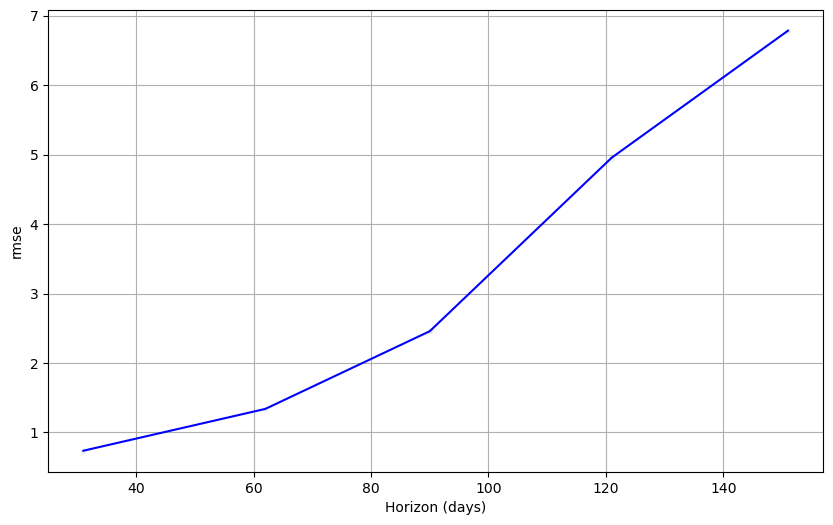

In [196]:
fig = plot_cross_validation_metric(df_cv, metric='rmse')

### Multivariate: Cross Validation

In [197]:
# initiate Prophet object
model = Prophet()

model.add_regressor('zipcode', standardize = False)
model.add_regressor('mean_rent_mf', standardize = False)
model.add_regressor('sf_price_index', standardize = False)
model.add_regressor('netflow_estimated', standardize = False)
model.add_regressor('median_income_inflow', standardize = False)

model.fit(atl_df_samp)

16:27:58 - cmdstanpy - INFO - Chain [1] start processing
16:27:58 - cmdstanpy - INFO - Chain [1] done processing


In [198]:
cutoffs = pd.to_datetime(['2022-12-01'])
df_cv = cross_validation(model, cutoffs=cutoffs, horizon='180 days')
#df_cv = cross_validation(model, initial='1000 days', period='30 days', horizon = '180 days')
df_cv

  0%|          | 0/1 [00:00<?, ?it/s]

16:28:00 - cmdstanpy - INFO - Chain [1] start processing
16:28:01 - cmdstanpy - INFO - Chain [1] done processing


ds        yhat  yhat_lower  yhat_upper           y     cutoff
0 2023-01-01  321.333532  320.938689  321.770129  319.929391 2022-12-01
1 2023-02-01  322.839745  321.585405  324.160653  321.929191 2022-12-01
2 2023-03-01  325.729660  323.340142  328.557069  323.787196 2022-12-01
3 2023-04-01  329.484310  325.628227  334.090158  324.655463 2022-12-01
4 2023-05-01  332.307429  326.248966  338.946862  326.057108 2022-12-01

In [199]:
df_p_multi = performance_metrics(df_cv)
df_p_multi.head()

horizon        mse      rmse       mae      mape     mdape     smape  \
0  31 days   1.971612  1.404141  1.404141  0.004389  0.004389  0.004379   
1  62 days   0.829110  0.910555  0.910555  0.002828  0.002828  0.002824   
2  90 days   3.773168  1.942464  1.942464  0.005999  0.005999  0.005981   
3 121 days  23.317762  4.828847  4.828847  0.014874  0.014874  0.014764   
4 151 days  39.066510  6.250321  6.250321  0.019169  0.019169  0.018987   

   coverage  
0       0.0  
1       1.0  
2       1.0  
3       0.0  
4       0.0

In [200]:
df_p_uni.head()

horizon        mse      rmse       mae      mape     mdape     smape  \
0  31 days   0.544071  0.737612  0.737612  0.002306  0.002306  0.002303   
1  62 days   1.794867  1.339726  1.339726  0.004162  0.004162  0.004153   
2  90 days   6.040616  2.457767  2.457767  0.007591  0.007591  0.007562   
3 121 days  24.562421  4.956049  4.956049  0.015266  0.015266  0.015150   
4 151 days  46.001673  6.782453  6.782453  0.020801  0.020801  0.020587   

   coverage  
0       0.0  
1       1.0  
2       1.0  
3       1.0  
4       1.0

### Multivariate - by Zip

In [ ]:
# code for generating future values of each regressor for the future dataset
# using simple prophet prediction

# https://stackoverflow.com/questions/64822488/how-to-use-prophets-make-future-dataframe-with-multiple-regressors

In [280]:
# sort df in chronological order
atl_df.sort_index(inplace=True)

# create train test split
tss = TimeSeriesSplit(n_splits = 2, test_size = 6) # preserve final 6 months as test set

# initiate Prophet object
model = Prophet()

# add multivariate predictors
model.add_regressor('zipcode', standardize = False)
model.add_regressor('mean_rent_mf', standardize = False)
model.add_regressor('sf_price_index', standardize = False)
model.add_regressor('netflow_estimated', standardize = False)
model.add_regressor('median_income_inflow', standardize = False)

16:18:15 - cmdstanpy - INFO - Chain [1] start processing
16:18:15 - cmdstanpy - INFO - Chain [1] done processing
16:18:15 - cmdstanpy - INFO - Chain [1] start processing
16:18:16 - cmdstanpy - INFO - Chain [1] done processing
16:18:16 - cmdstanpy - INFO - Chain [1] start processing
16:18:17 - cmdstanpy - INFO - Chain [1] done processing
16:18:17 - cmdstanpy - INFO - Chain [1] start processing
16:18:17 - cmdstanpy - INFO - Chain [1] done processing
16:18:17 - cmdstanpy - INFO - Chain [1] start processing
16:18:18 - cmdstanpy - INFO - Chain [1] done processing
16:18:18 - cmdstanpy - INFO - Chain [1] start processing
16:18:18 - cmdstanpy - INFO - Chain [1] done processing
16:18:18 - cmdstanpy - INFO - Chain [1] start processing
16:18:18 - cmdstanpy - INFO - Chain [1] done processing
16:18:19 - cmdstanpy - INFO - Chain [1] start processing
16:18:19 - cmdstanpy - INFO - Chain [1] done processing
16:18:19 - cmdstanpy - INFO - Chain [1] start processing
16:18:19 - cmdstanpy - INFO - Chain [1]

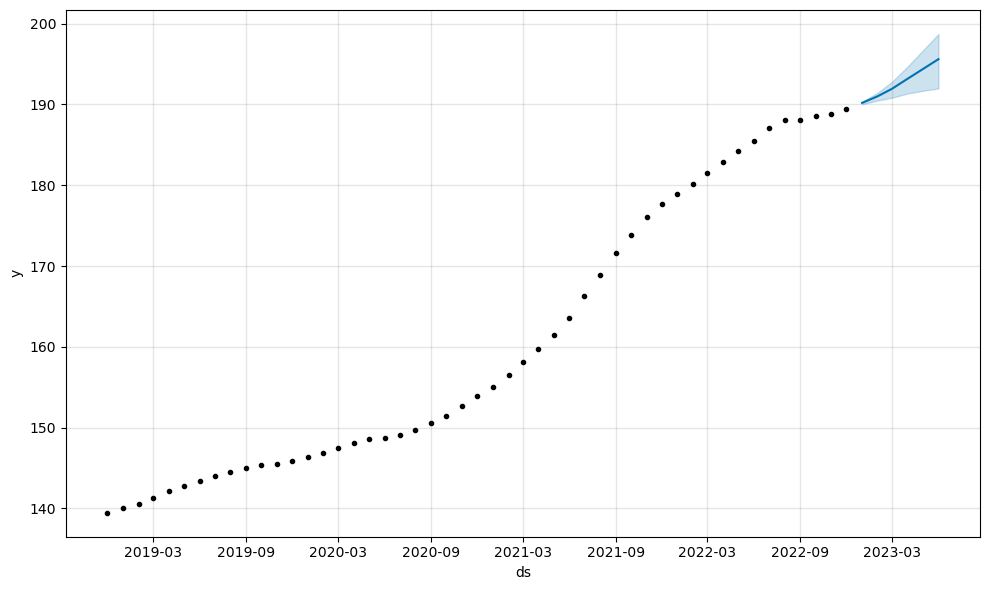

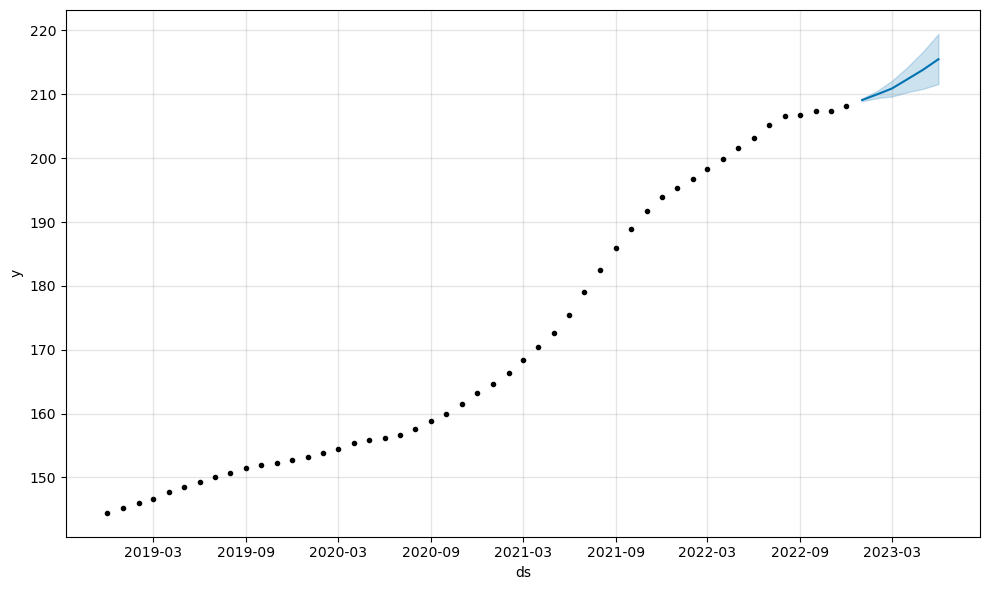

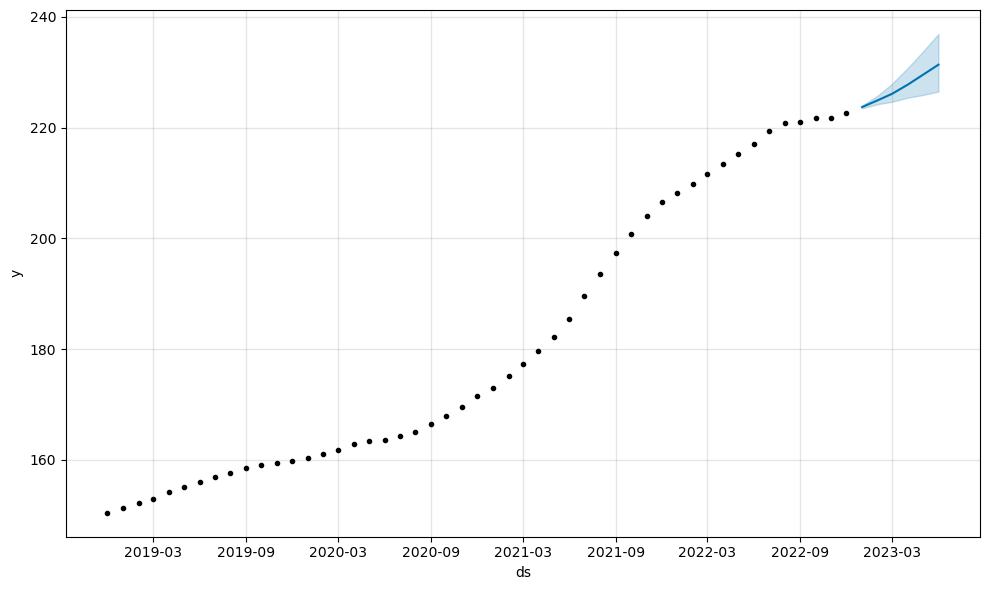

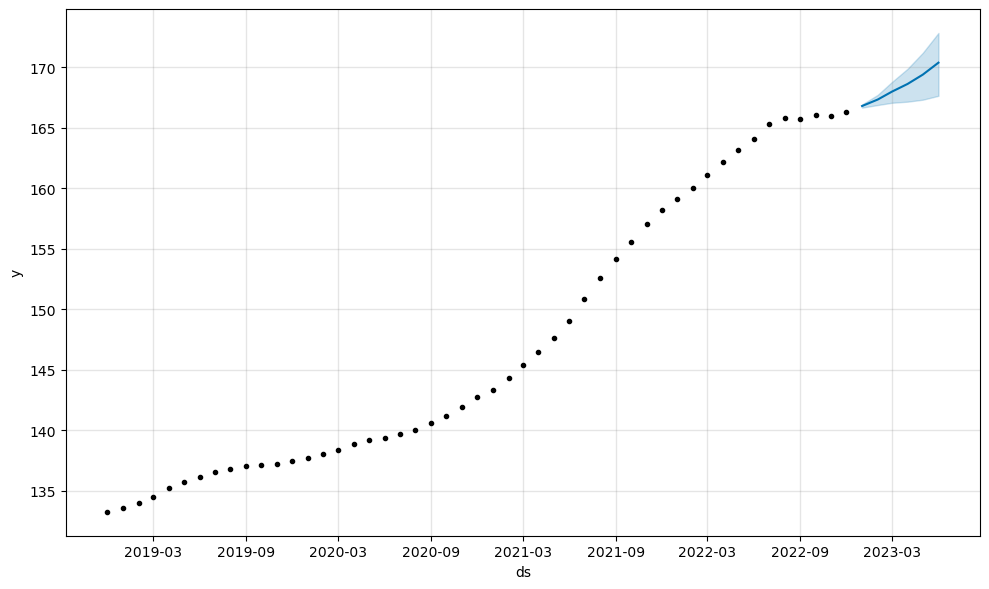

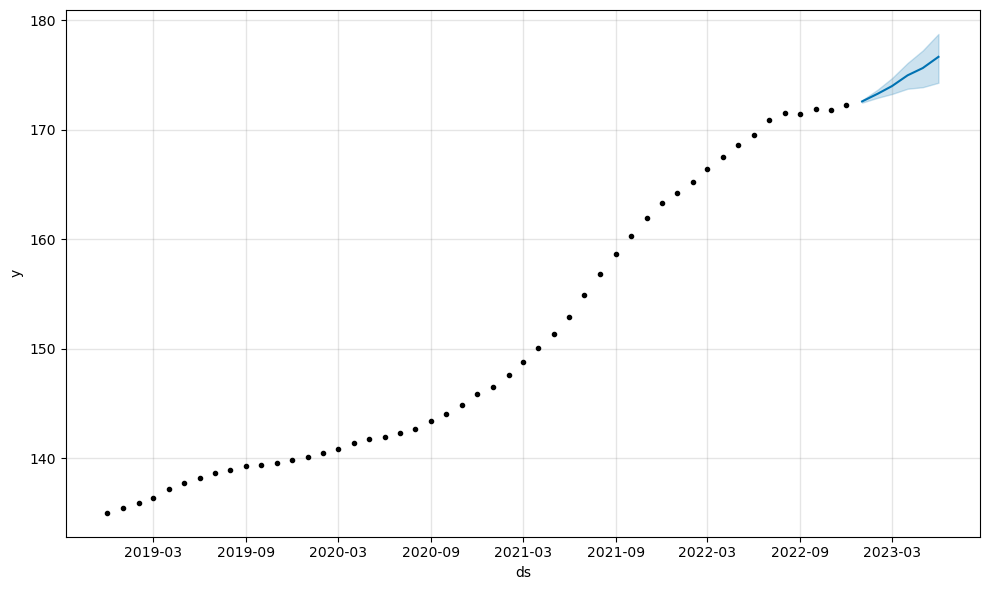

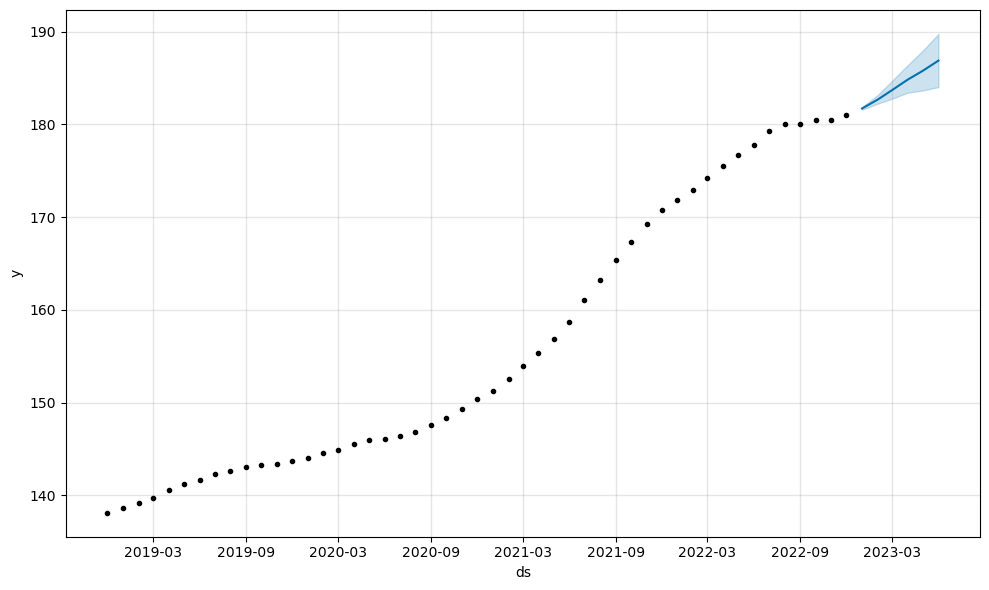

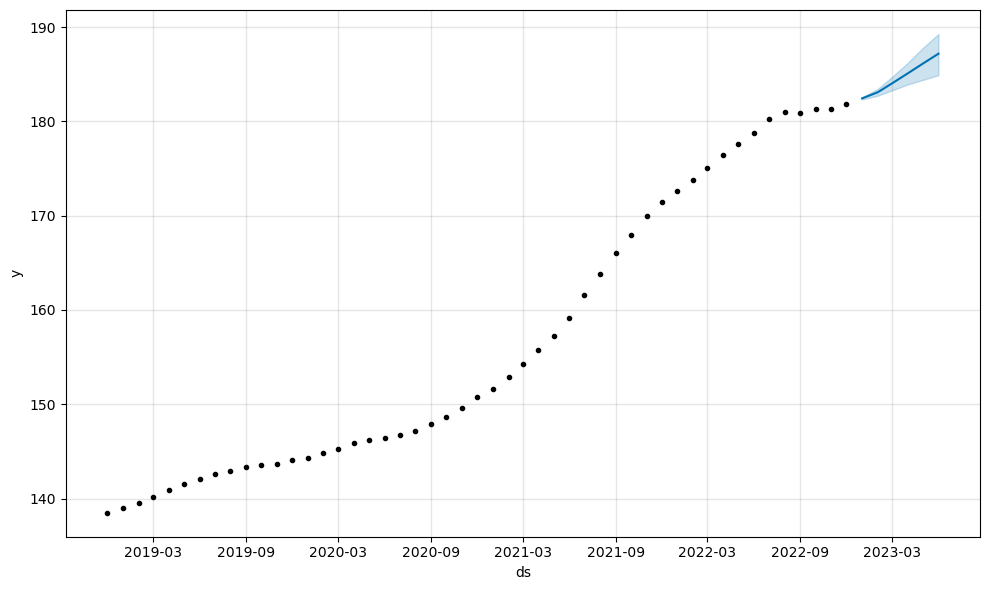

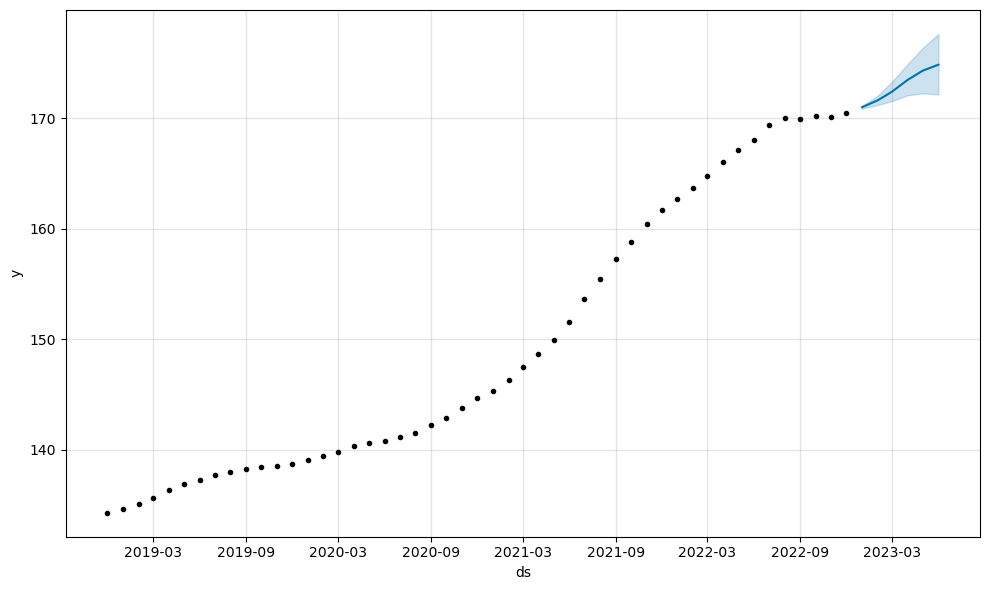

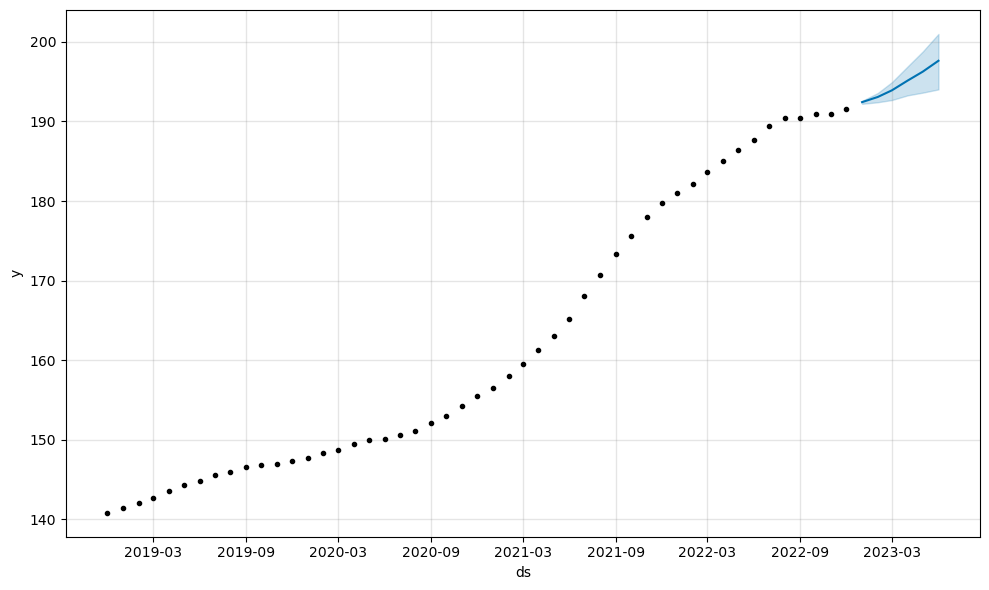

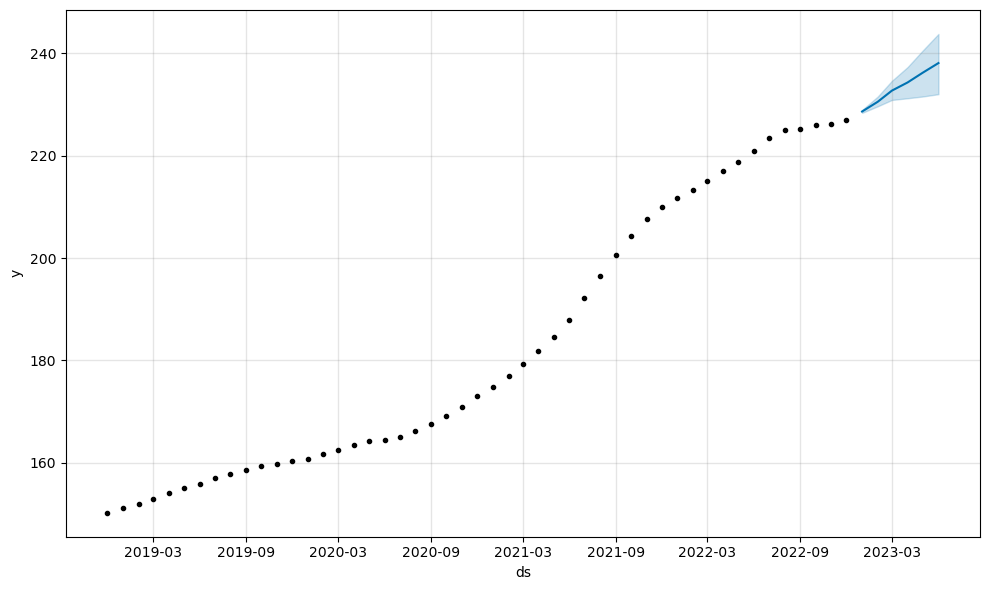

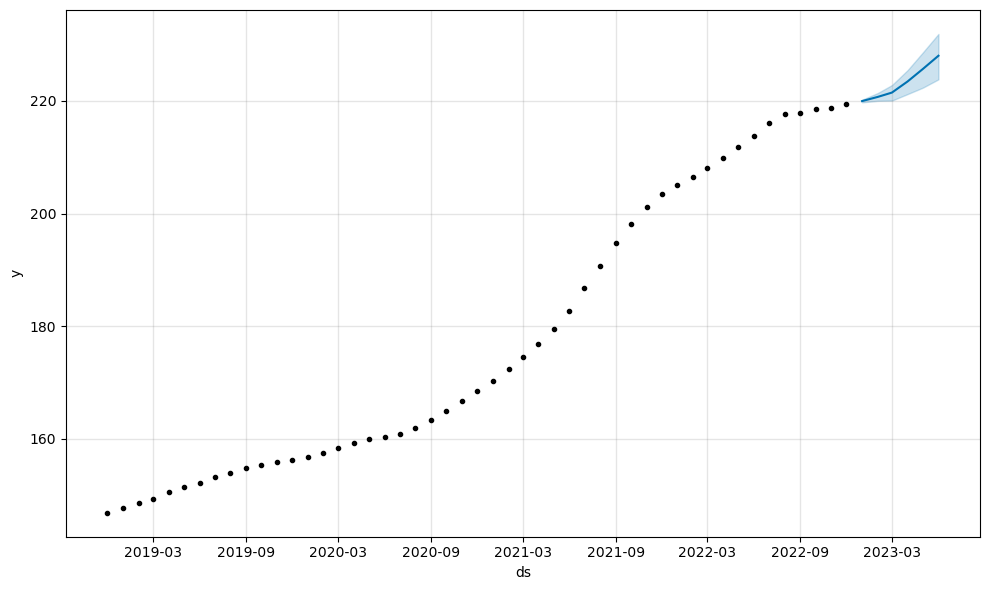

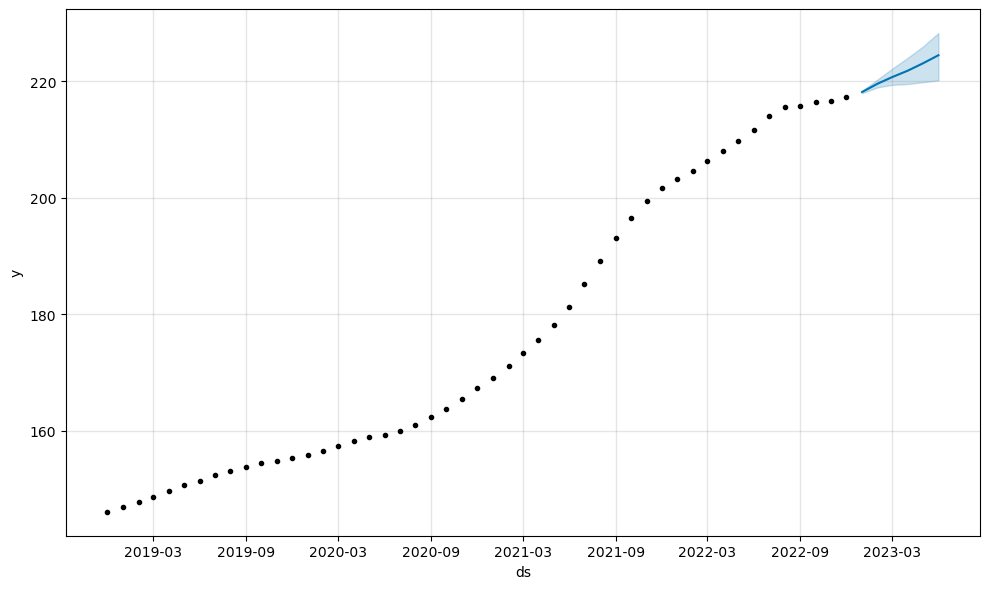

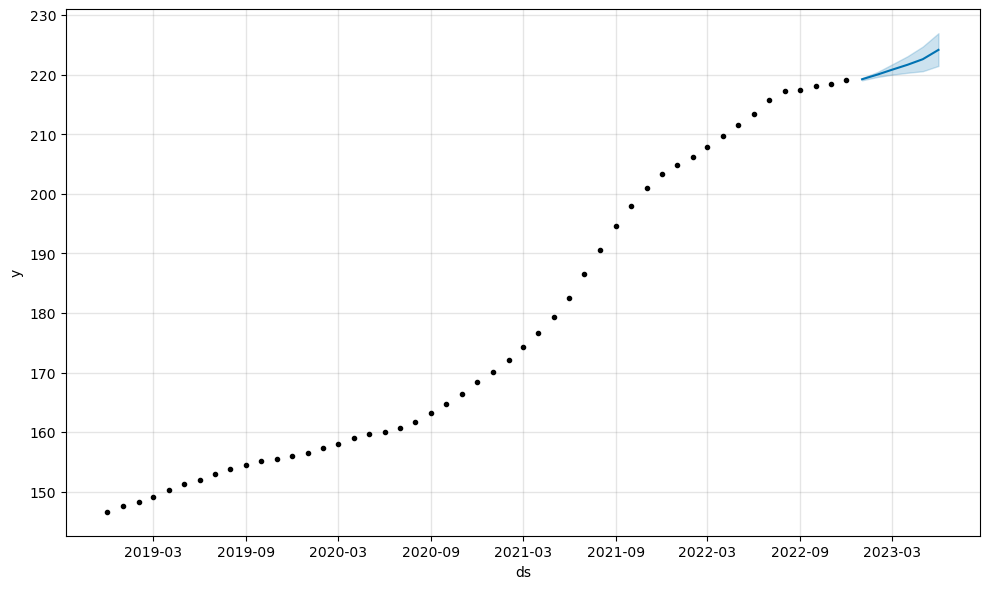

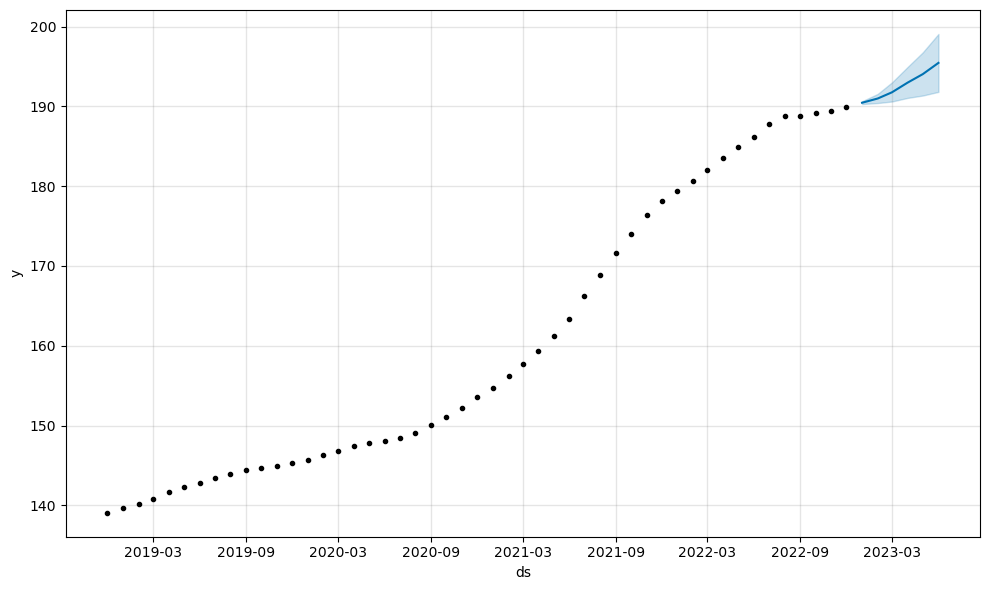

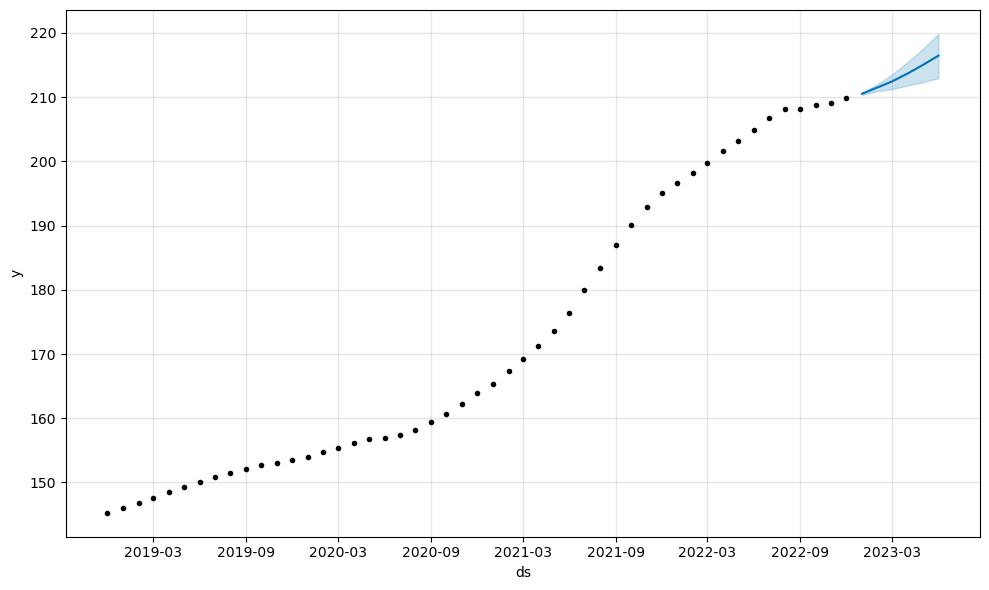

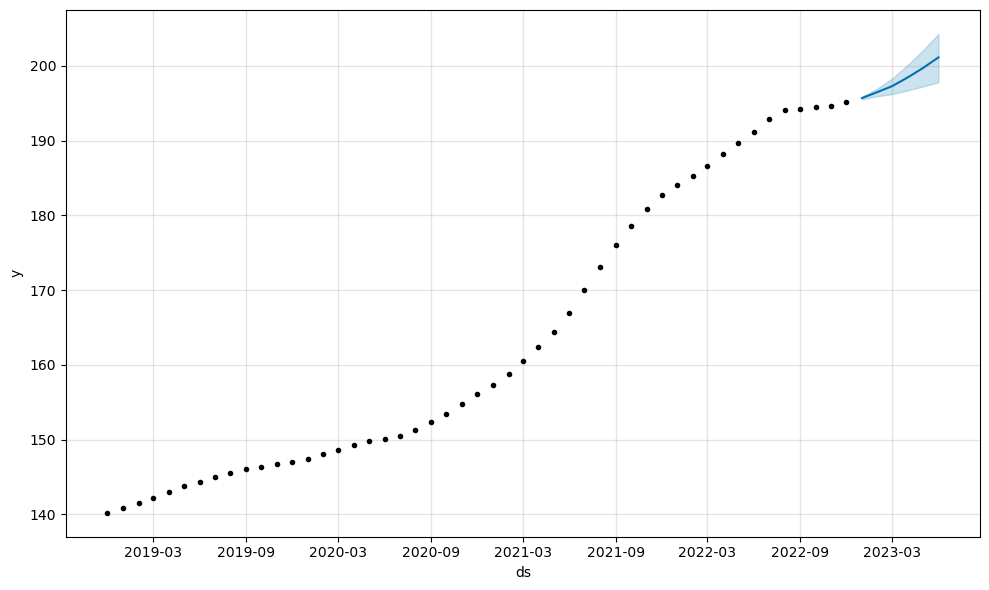

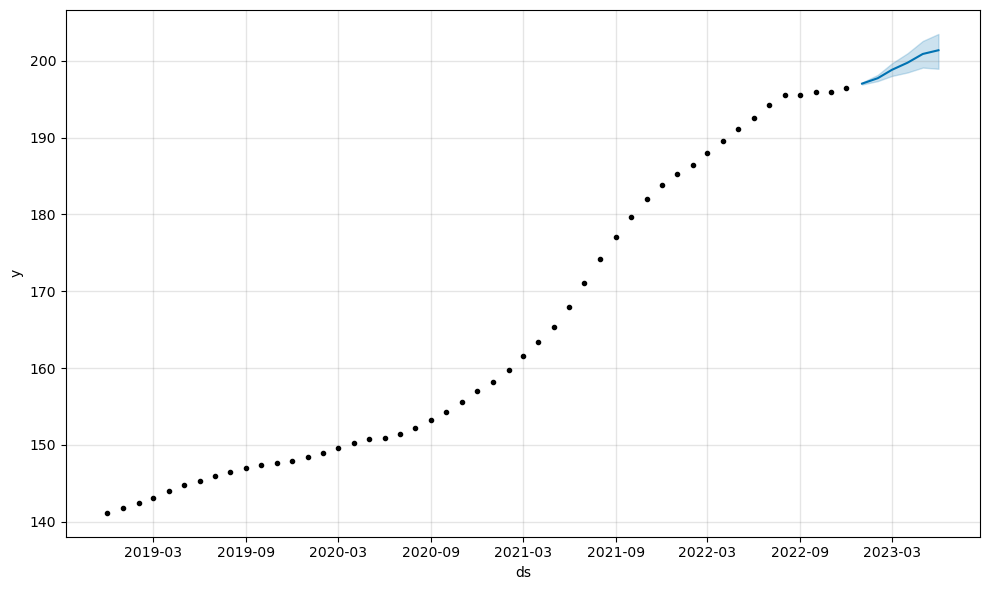

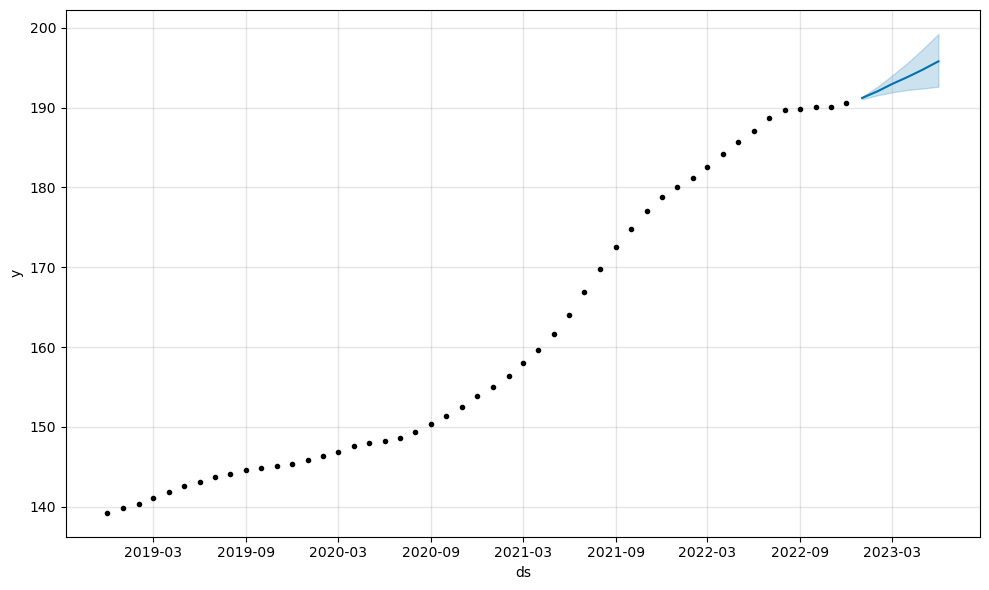

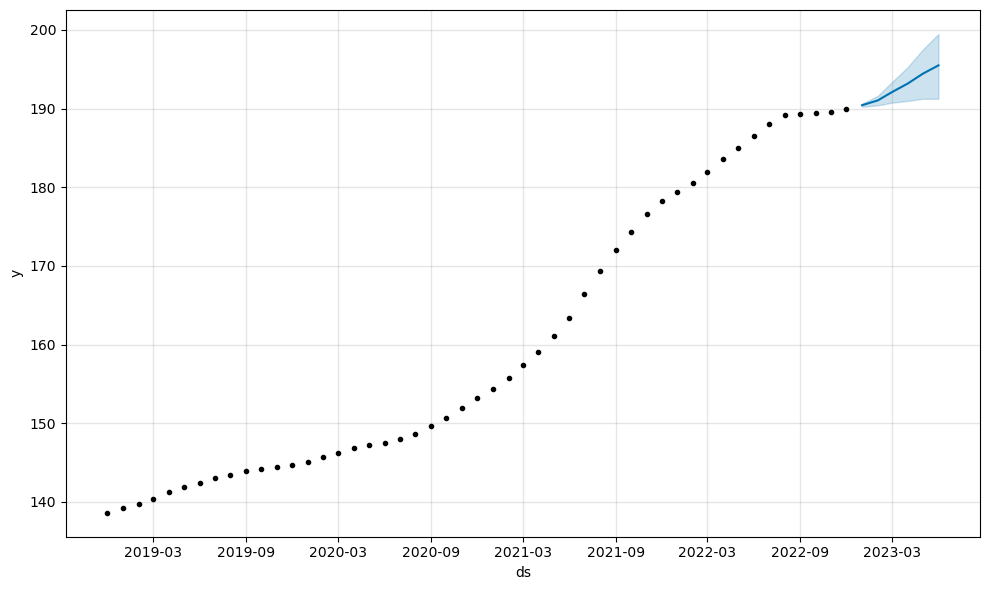

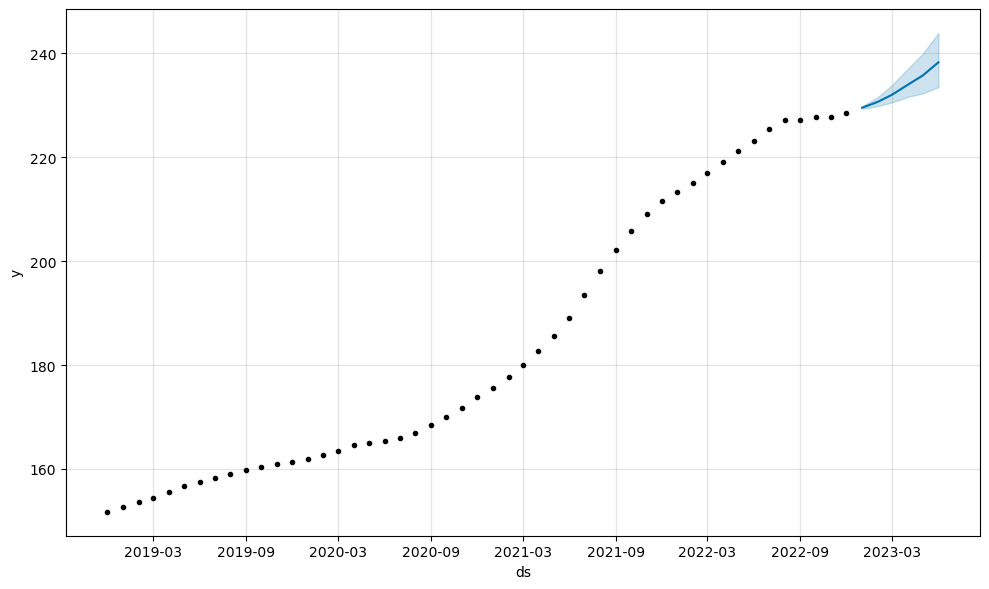

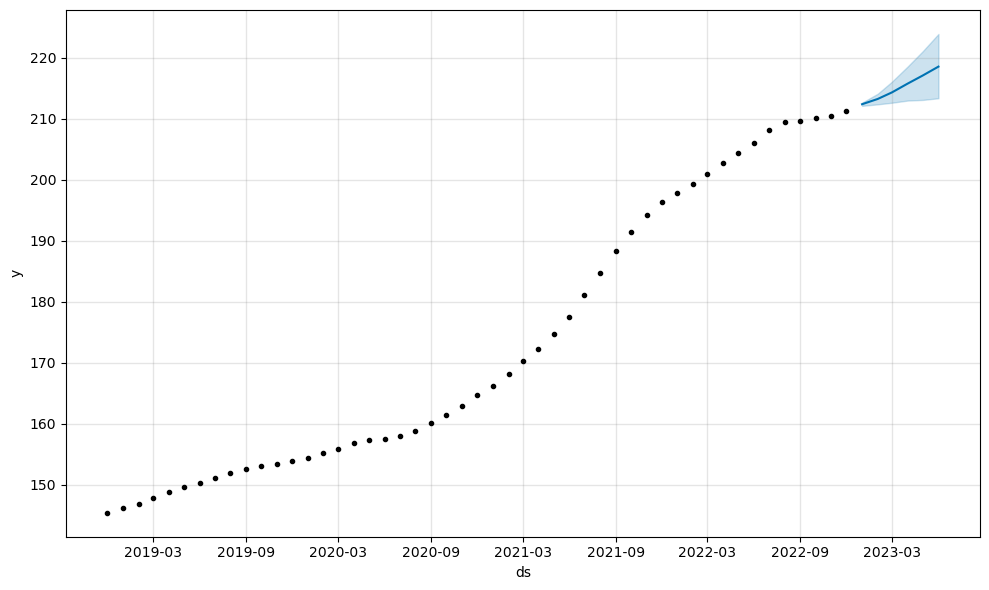

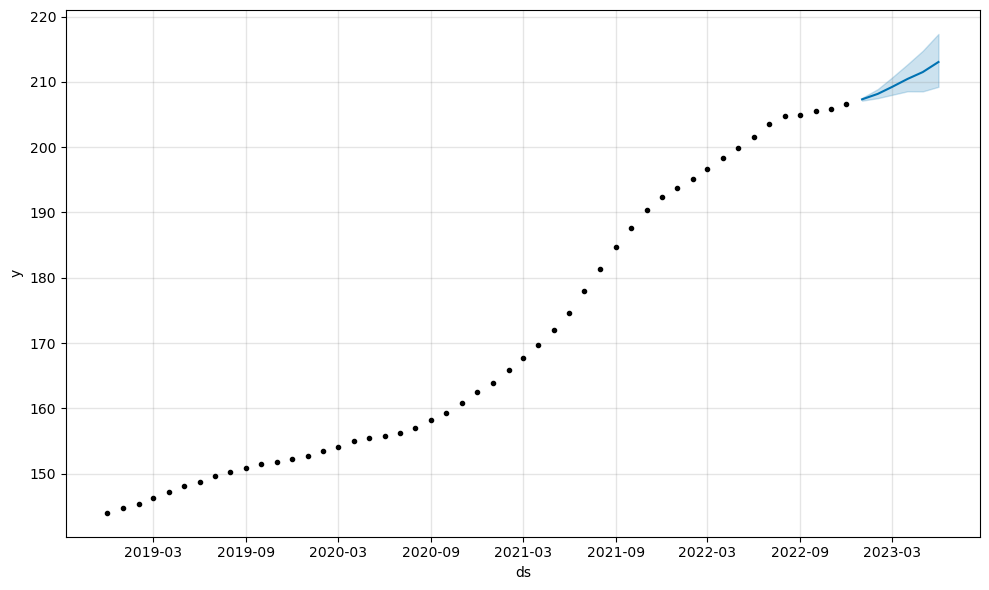

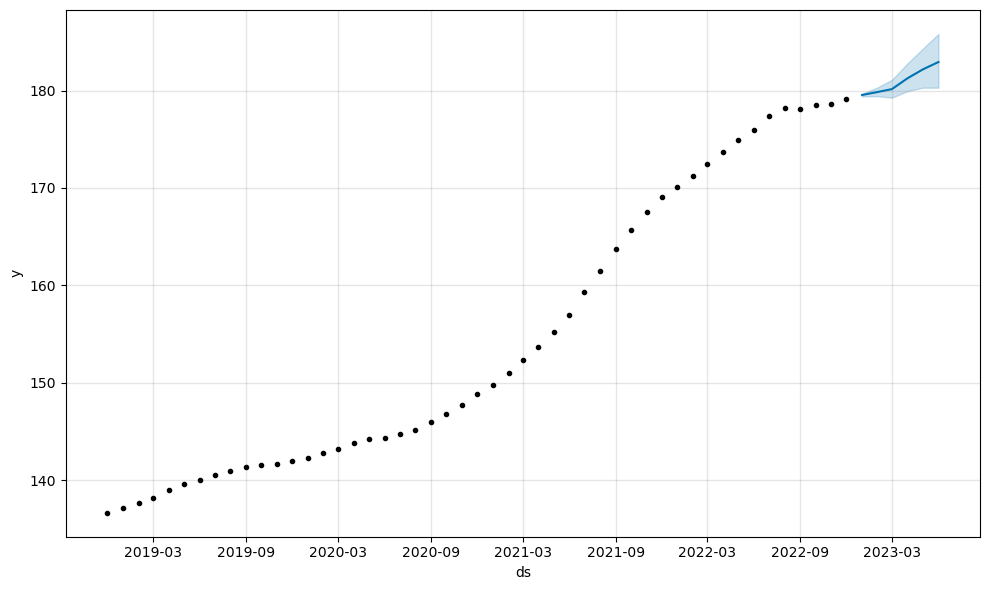

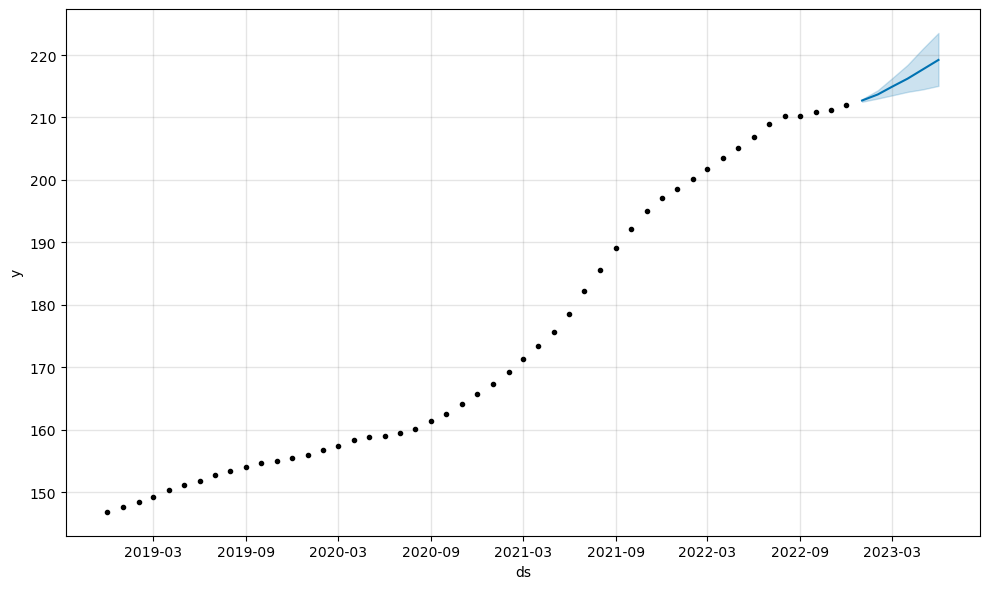

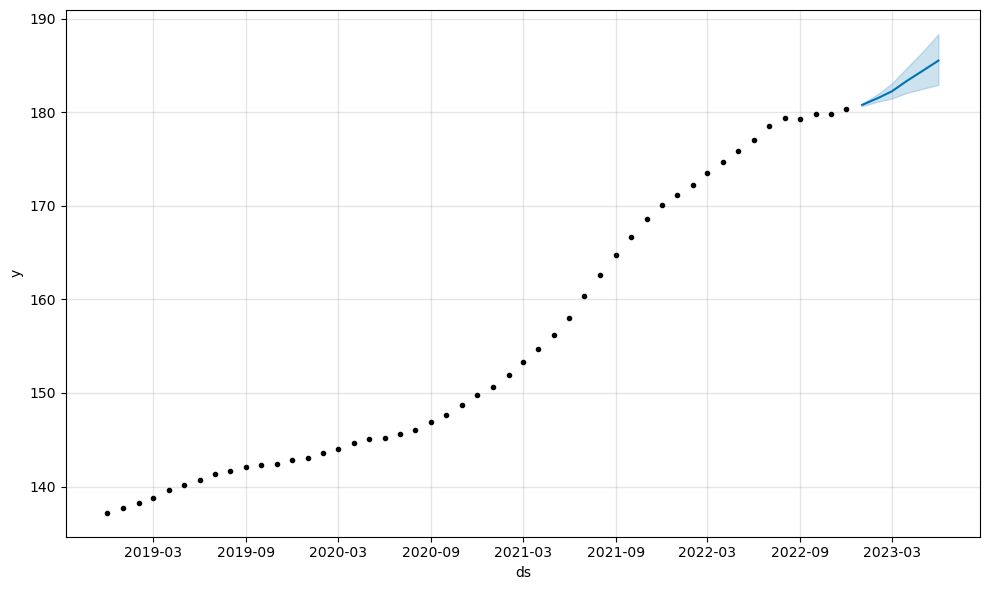

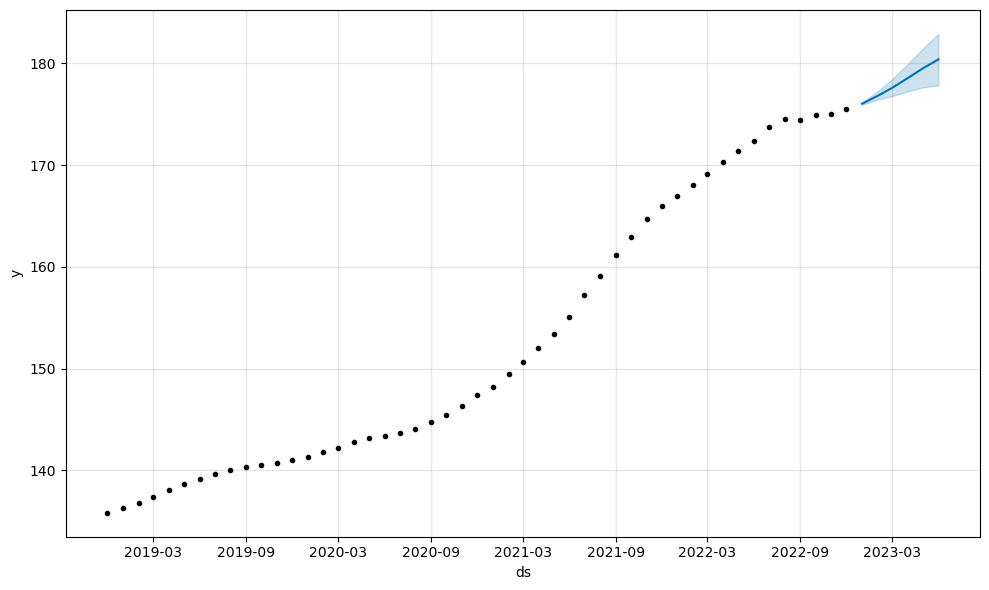

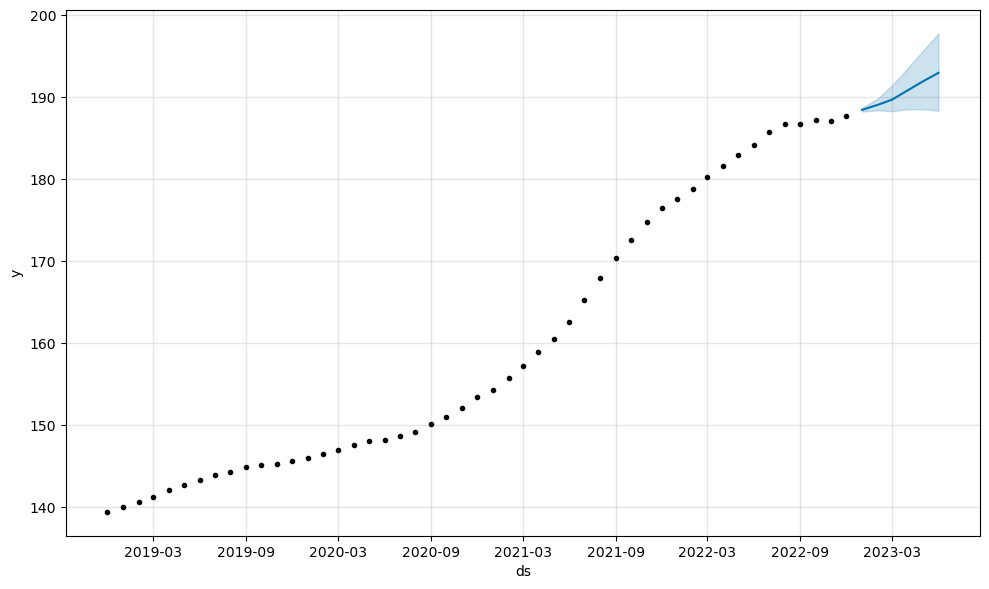

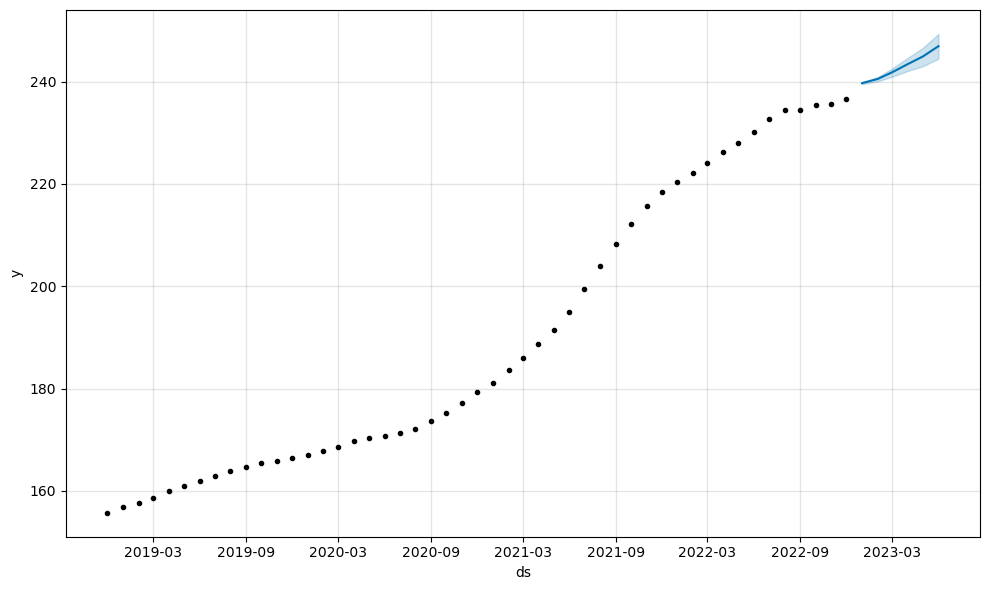

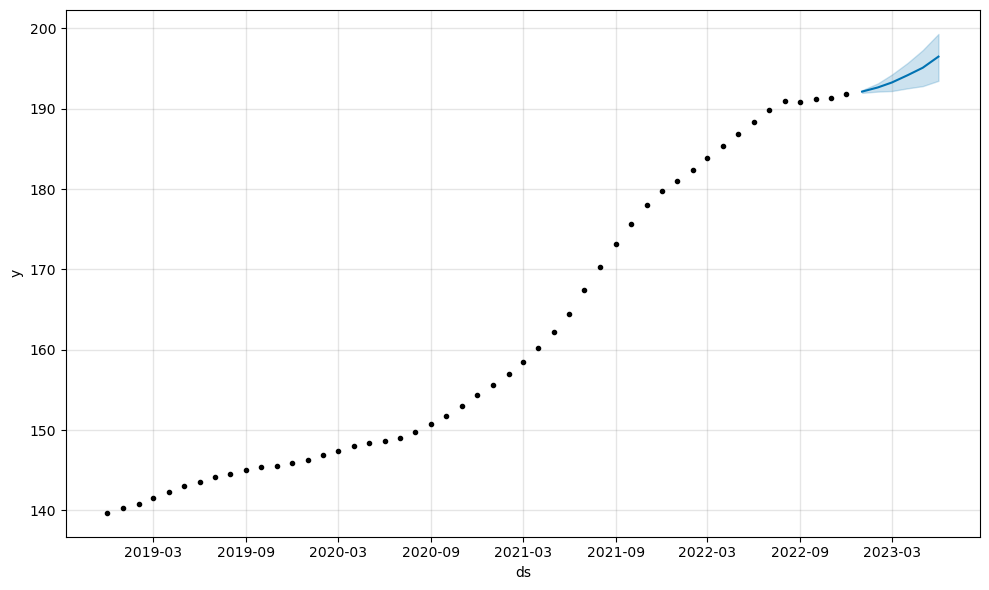

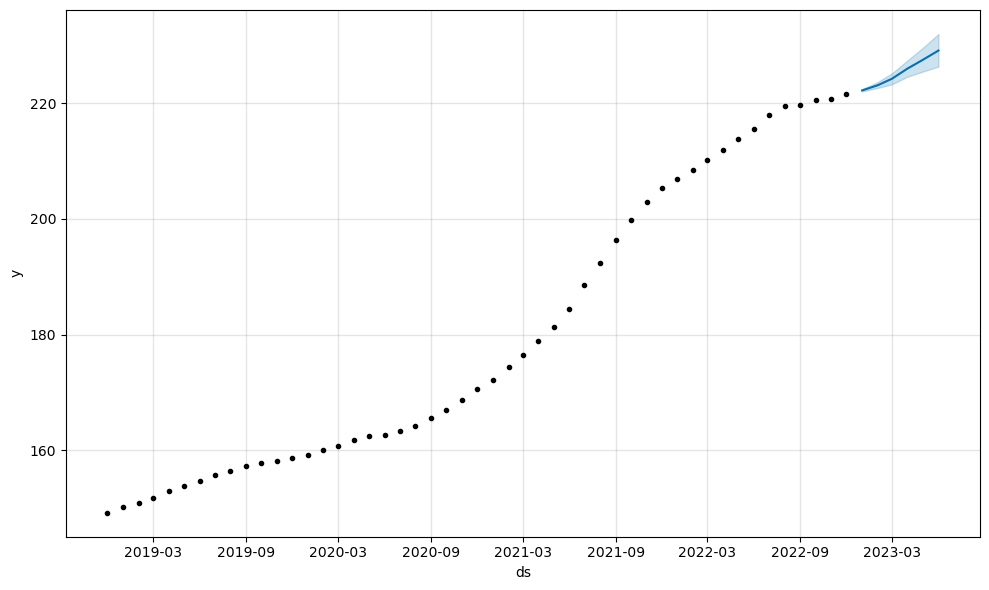

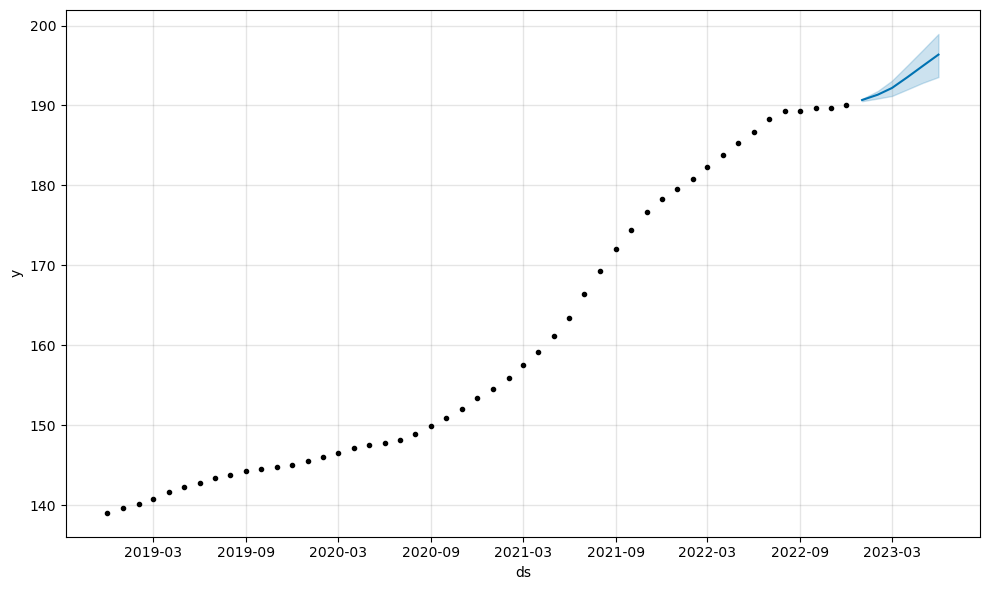

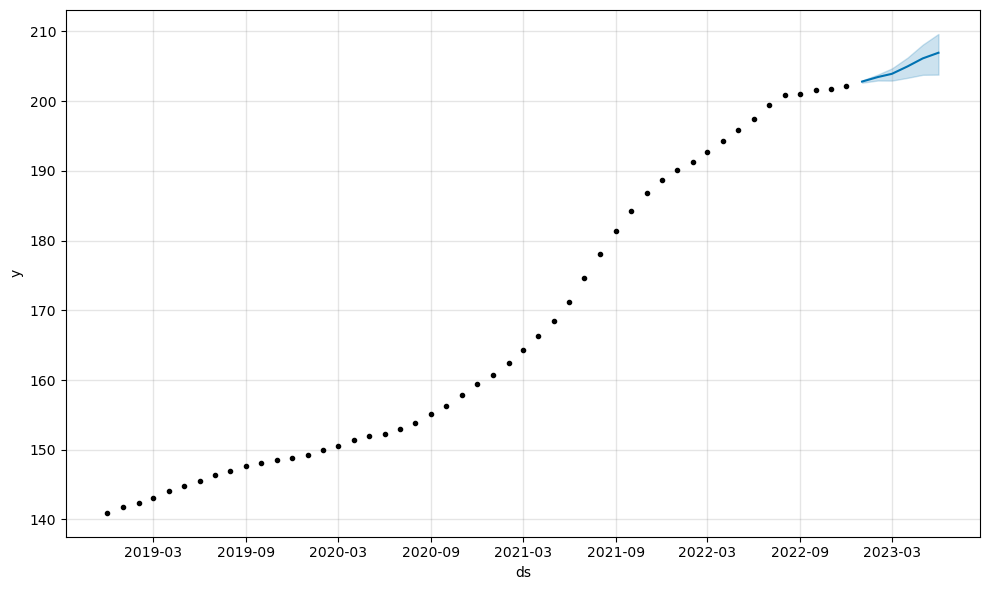

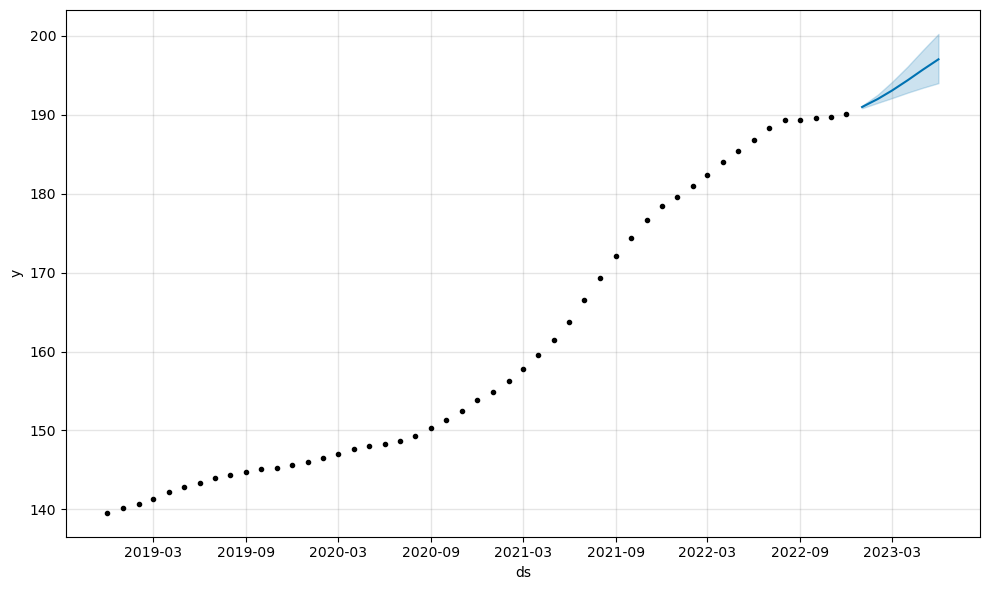

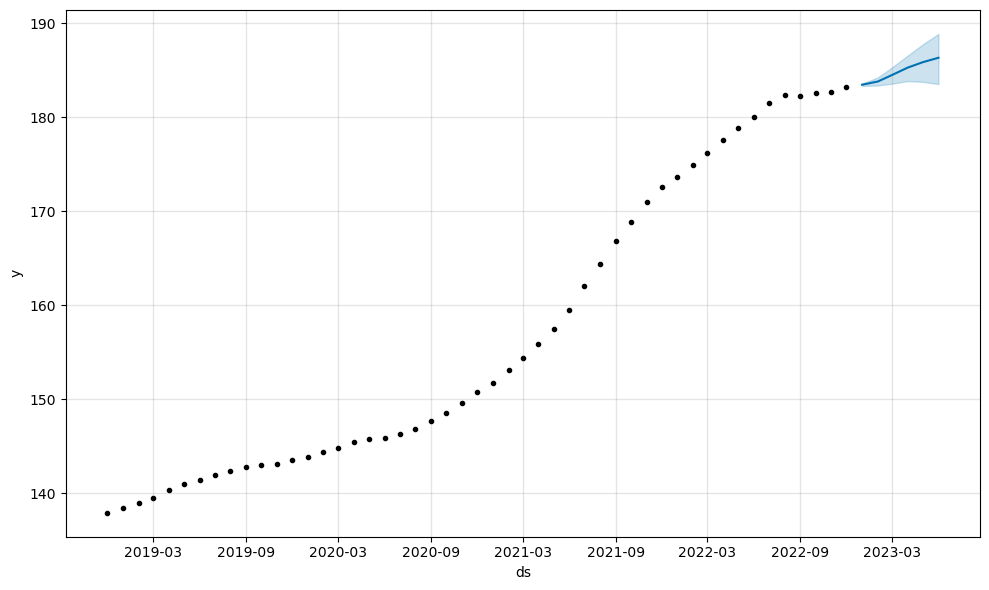

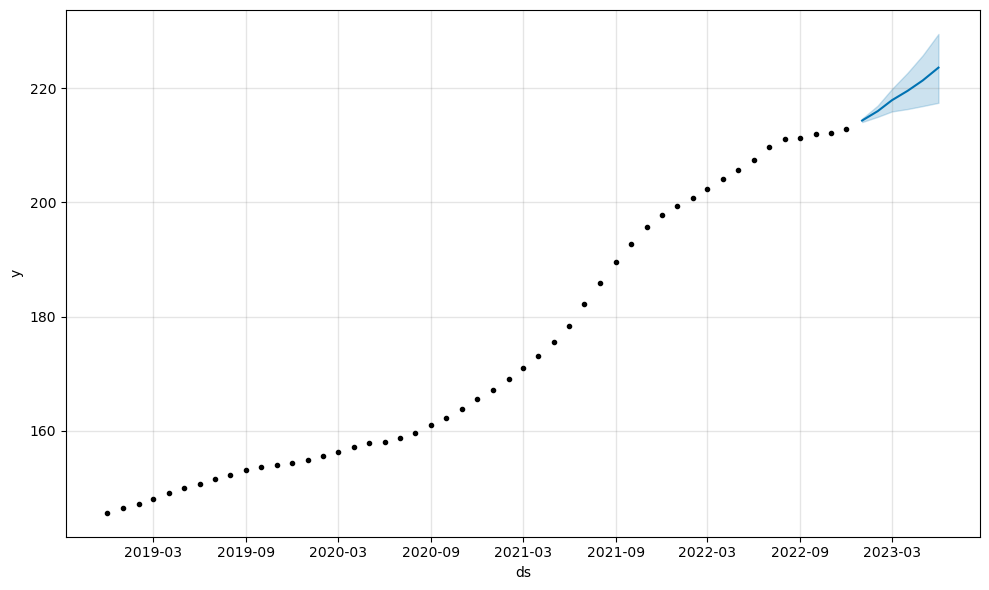

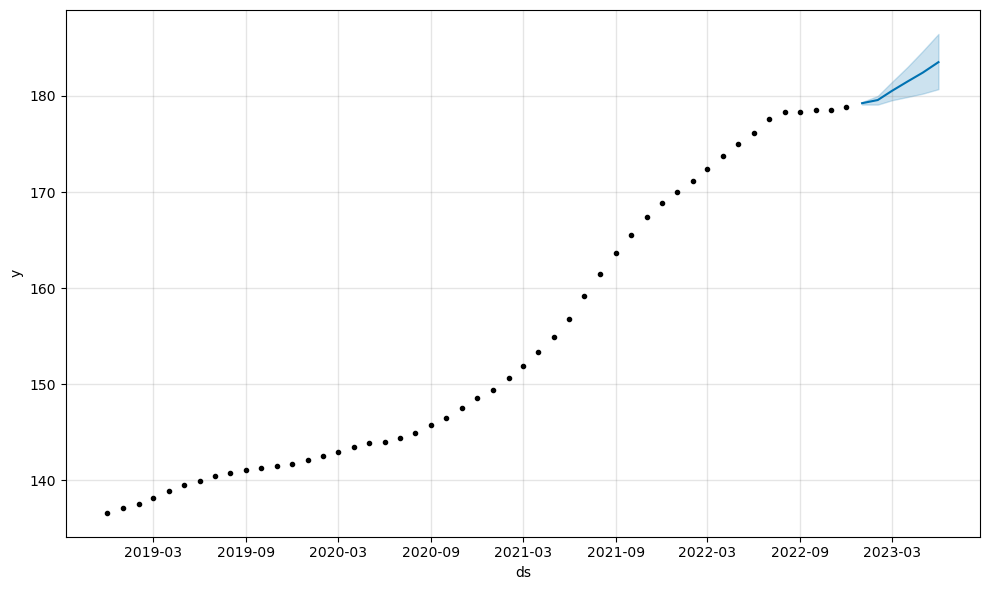

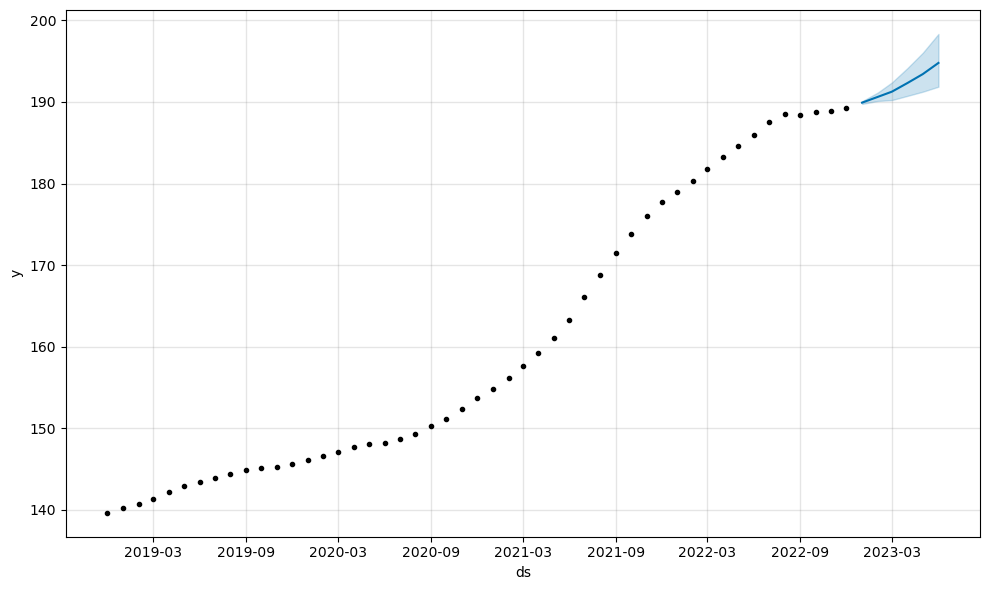

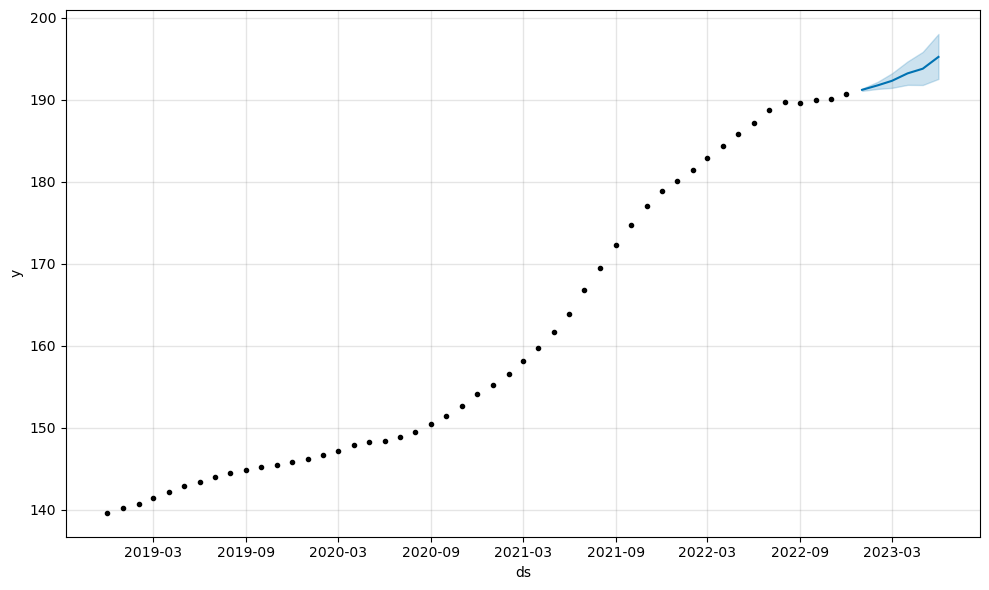

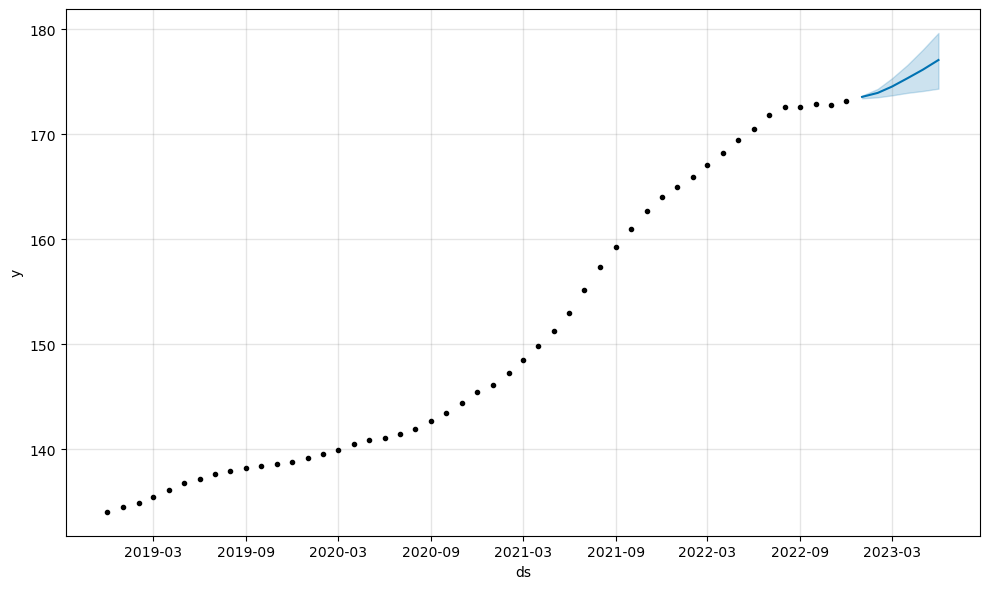

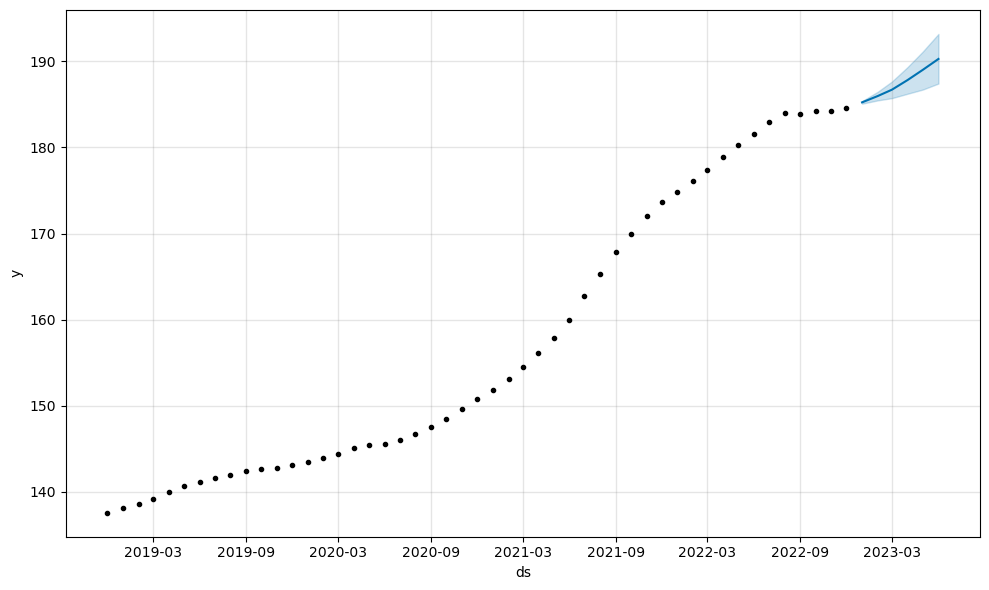

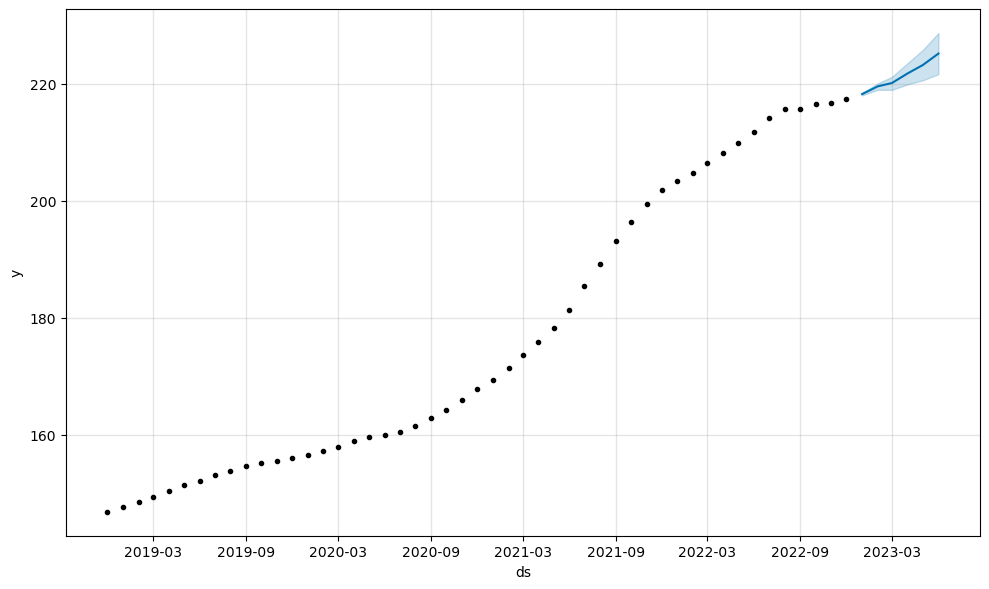

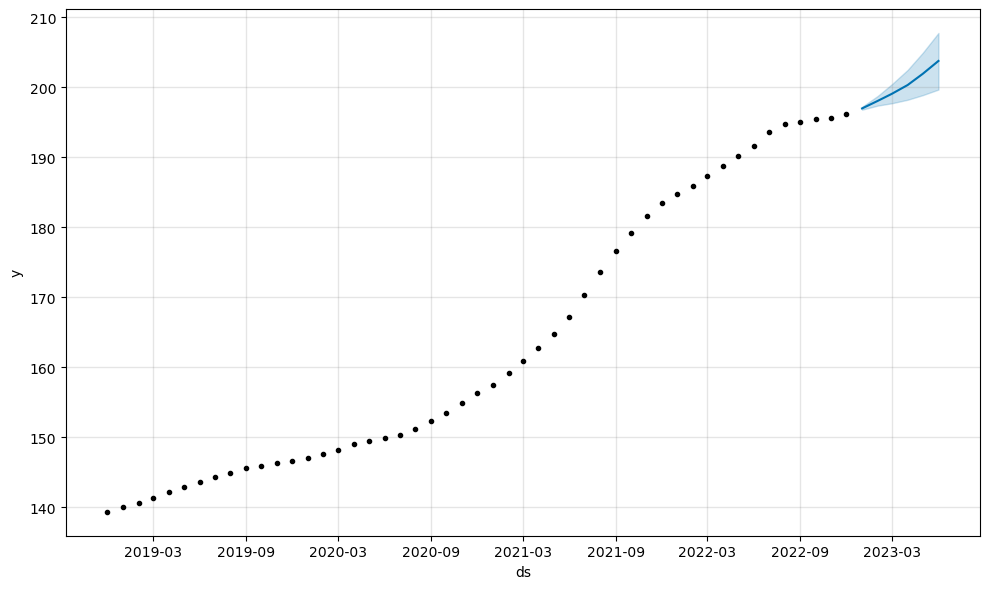

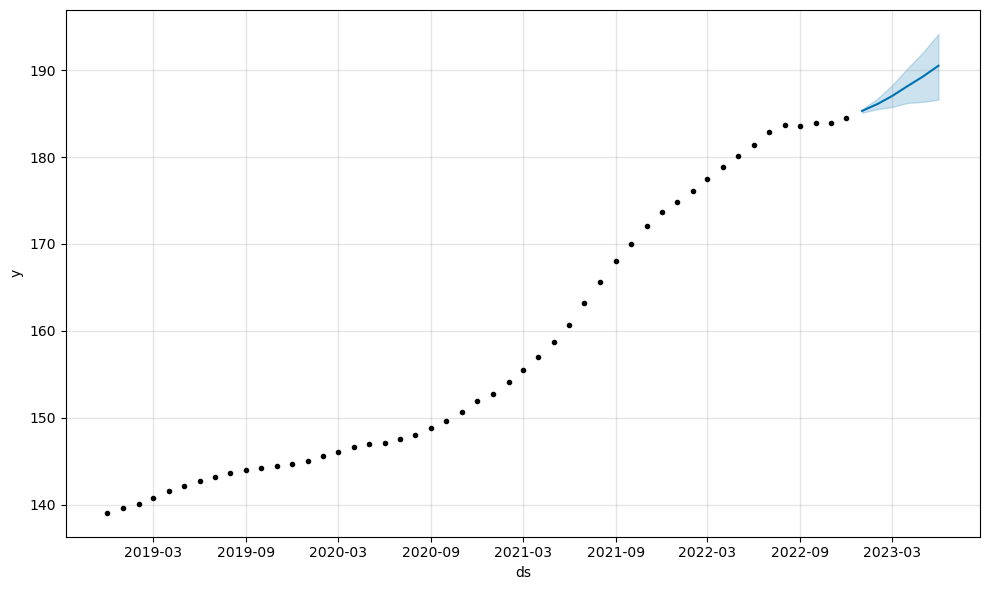

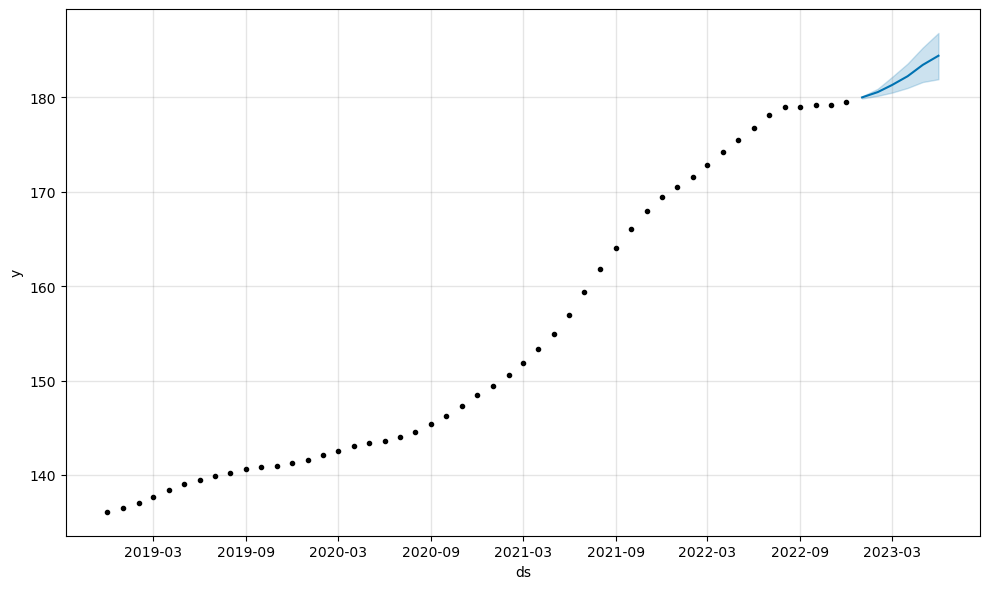

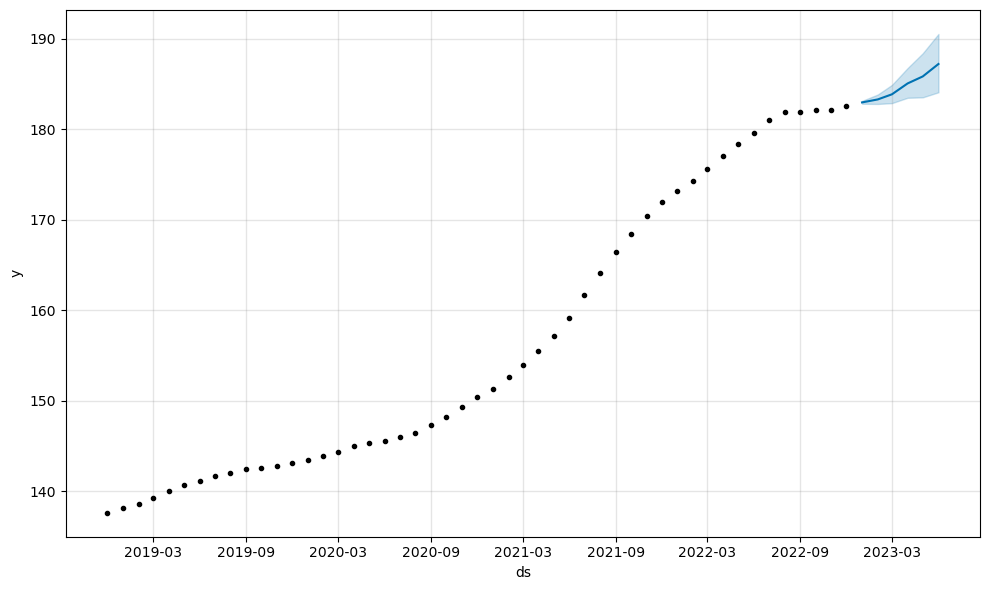

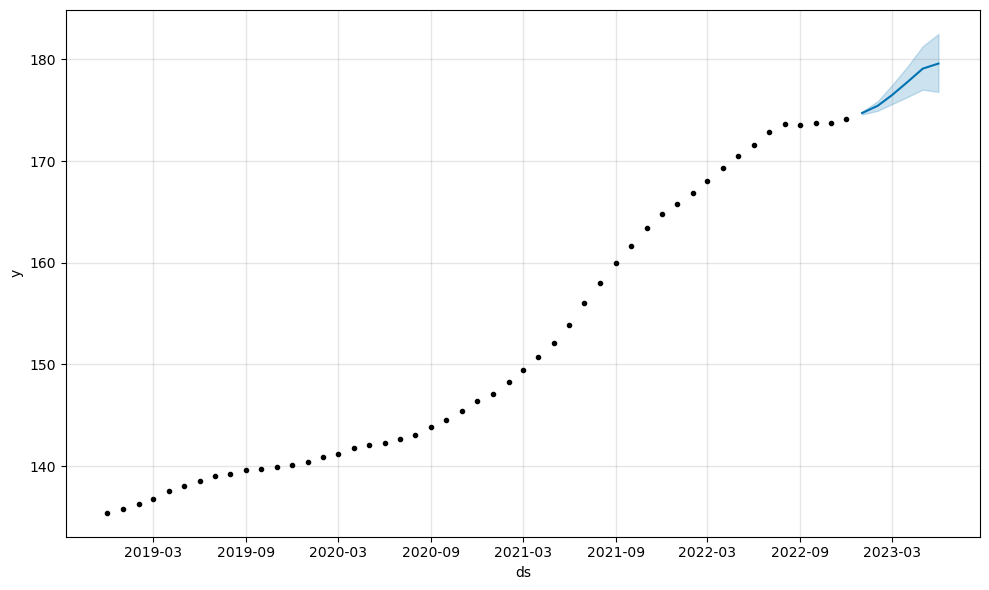

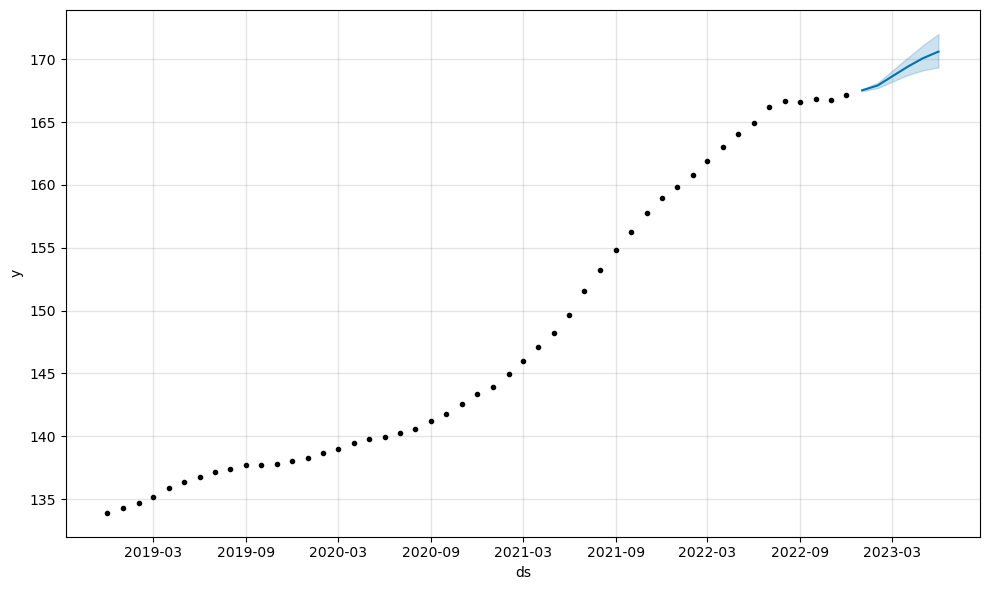

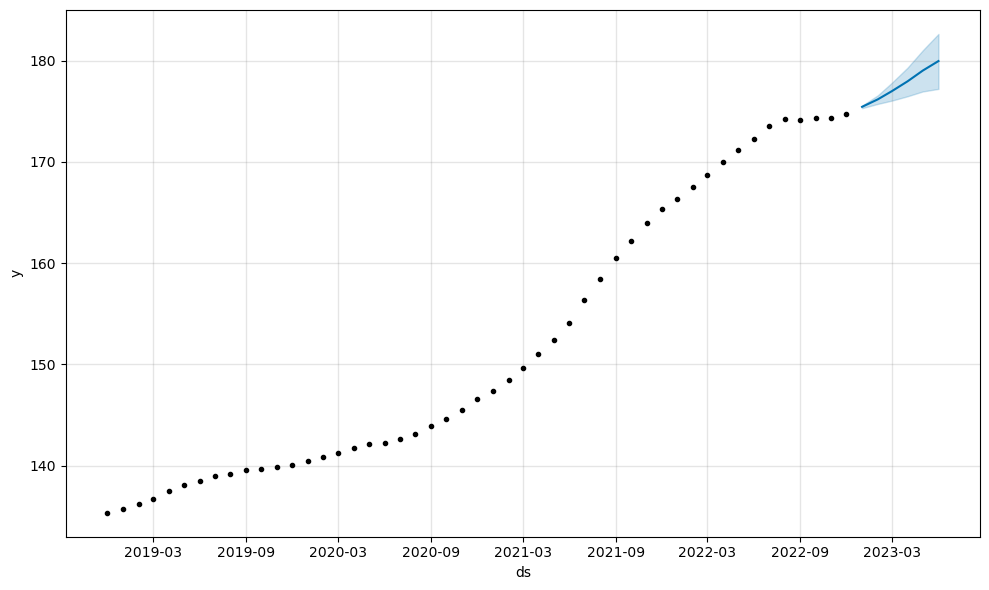

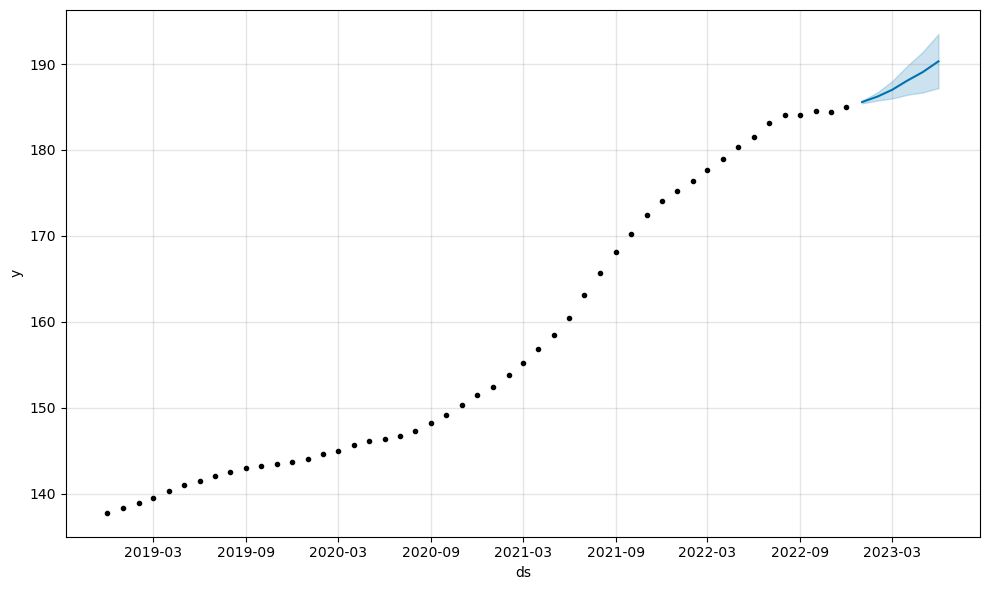

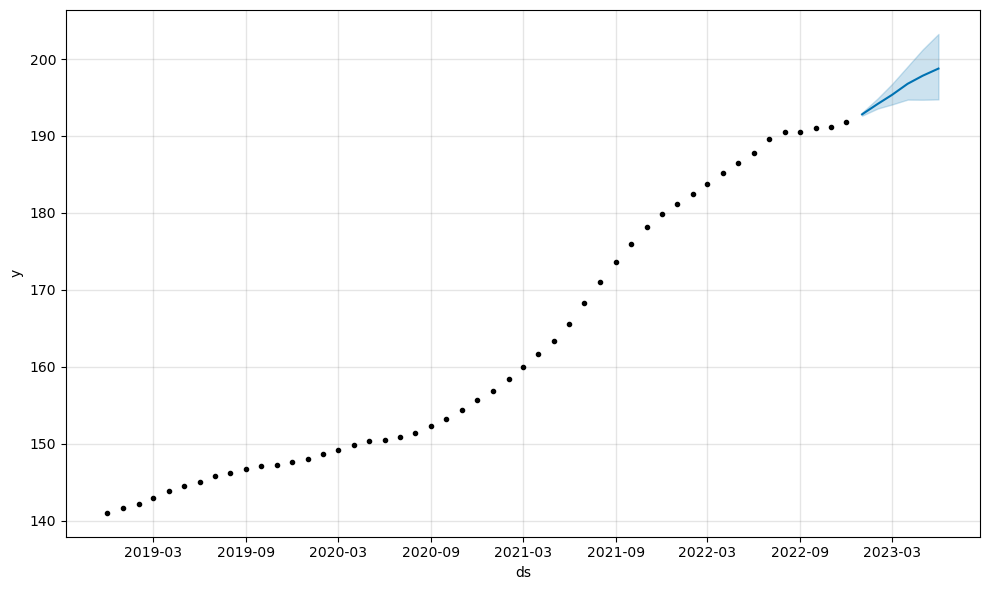

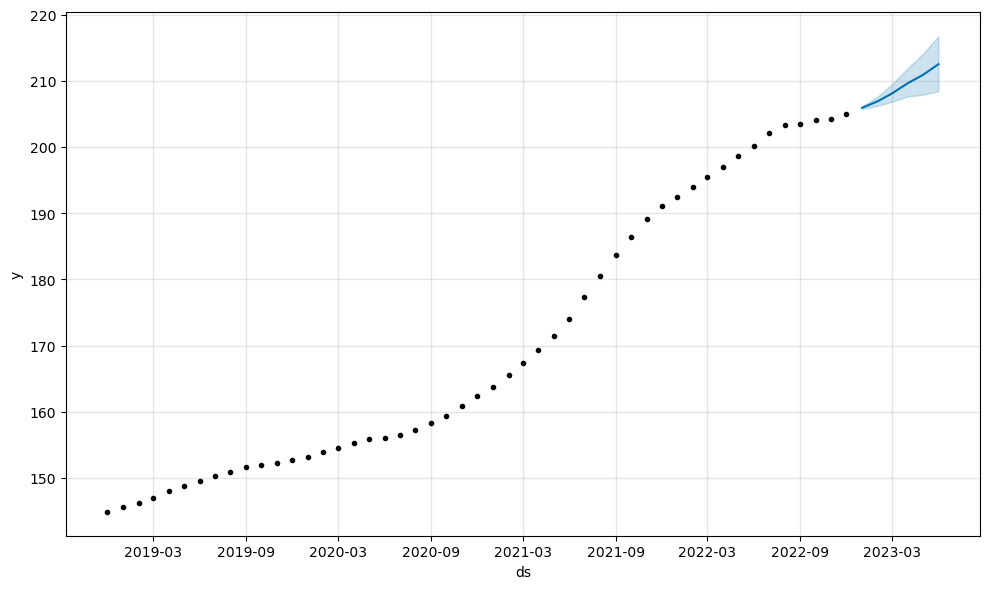

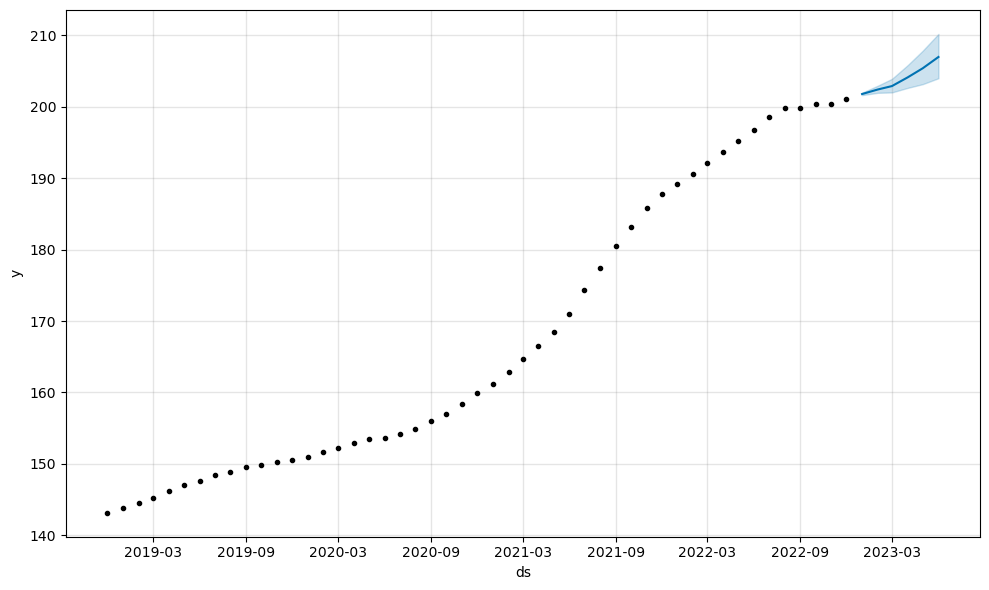

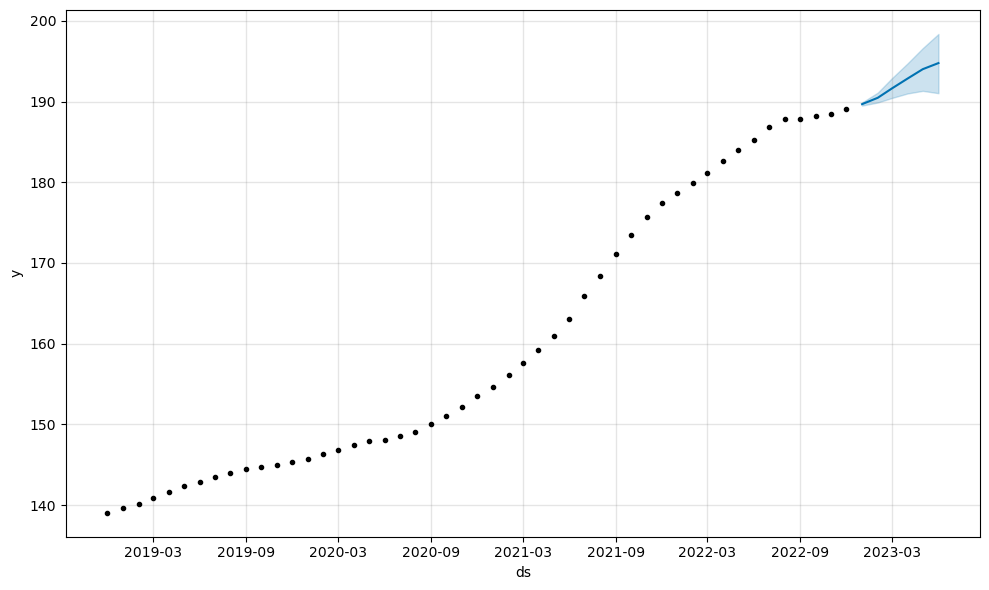

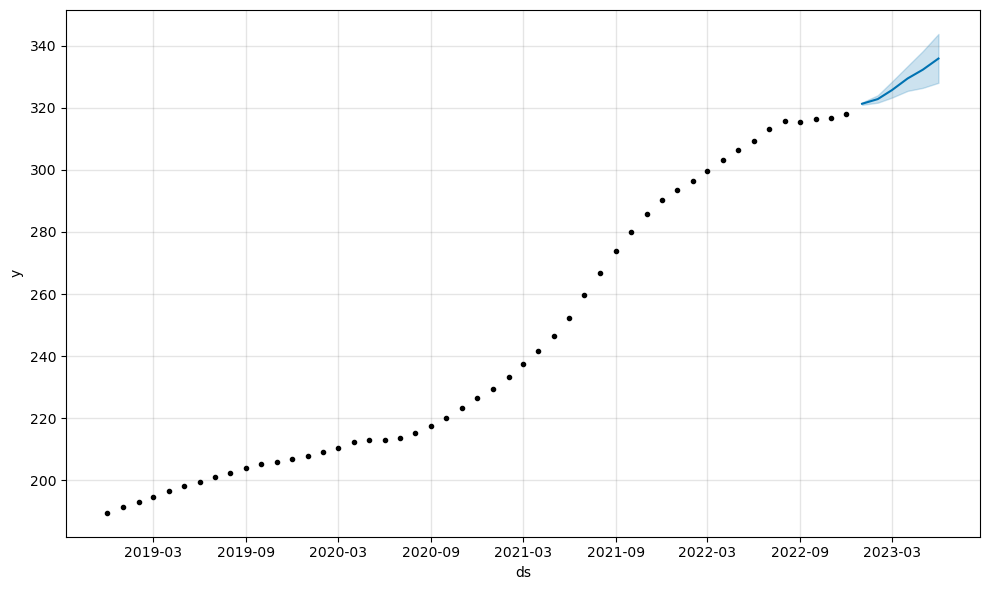

In [282]:
forecast_dict = {}
y_true_dict = {}
y_pred_dict = {}

for zipcode in atl_df['zipcode'].unique():
    # filter for single zipcode
    zipcode_df = atl_df[atl_df['zipcode'] == zipcode]
    
    # create train/test split
    for train_index, test_index in tss.split(zipcode_df):
        df_train, df_test = zipcode_df.iloc[train_index, :], zipcode_df.iloc[test_index,:]
    
    # initiate Prophet object and add regressors
    model = Prophet()
    model.add_regressor('zipcode', standardize = False)
    model.add_regressor('mean_rent_mf', standardize = False)
    model.add_regressor('sf_price_index', standardize = False)
    model.add_regressor('netflow_estimated', standardize = False)
    model.add_regressor('median_income_inflow', standardize = False)

    # fit model on training set
    model.fit(df_train) 
    
    # create and plot forecast
    forecast = model.predict(df_test)
    model.plot(forecast)
    
    # restore time series index store forecast 
    forecast.set_index('ds', inplace = True)
    forecast_dict[zipcode] = forecast
    
    # store y_true and y_pred
    y_true_dict[zipcode] = df_test['y']
    y_pred_dict[zipcode] = forecast['yhat']

In [283]:
forecast_dict

{30002:                 trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
 ds                                                                        
 2023-01-01  72.605804  190.030176  190.325583    72.444792    72.735653   
 2023-02-01  73.383566  190.485837  191.457270    72.865682    73.824616   
 2023-03-01  74.086060  190.827159  192.797248    72.943956    74.959839   
 2023-04-01  74.863822  191.353723  194.688092    73.021464    76.366589   
 2023-05-01  75.616495  191.681726  196.665335    72.946281    77.924139   
 2023-06-01  76.394256  191.980995  198.723756    72.806679    79.460704   
 
             additive_terms  additive_terms_lower  additive_terms_upper  \
 ds                                                                       
 2023-01-01      117.583939            117.583939            117.583939   
 2023-02-01      117.633396            117.633396            117.633396   
 2023-03-01      117.843391            117.843391            117.843391   
 2023-04

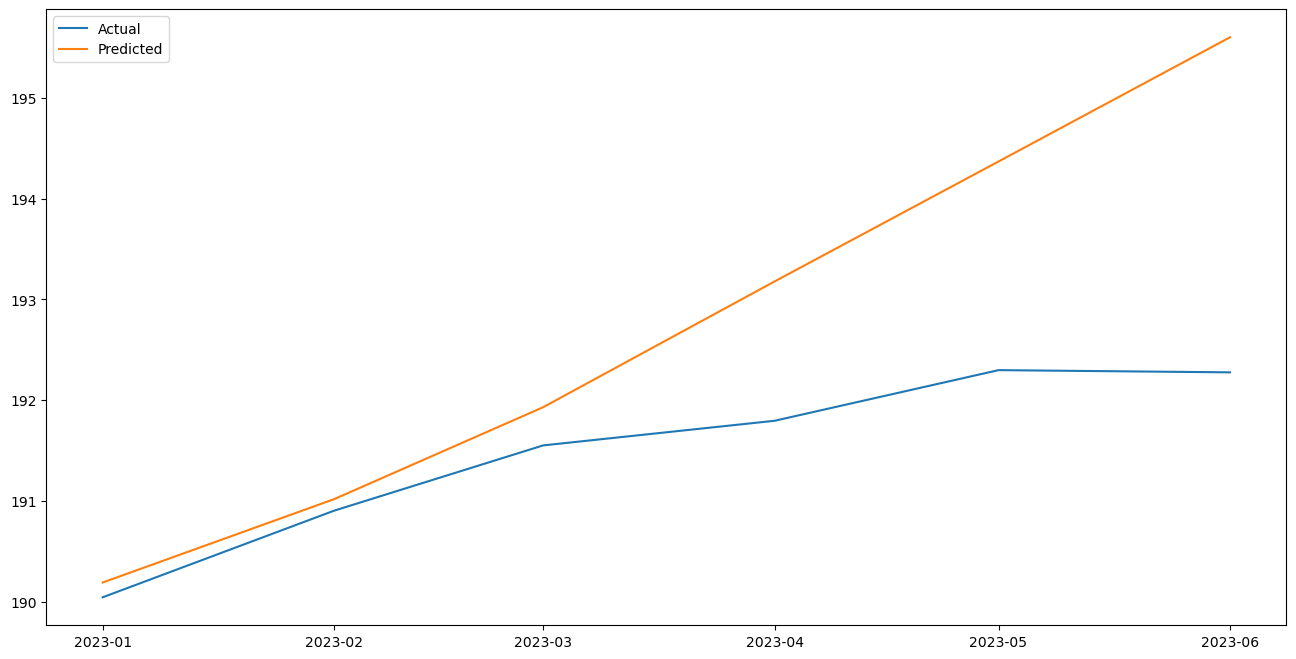

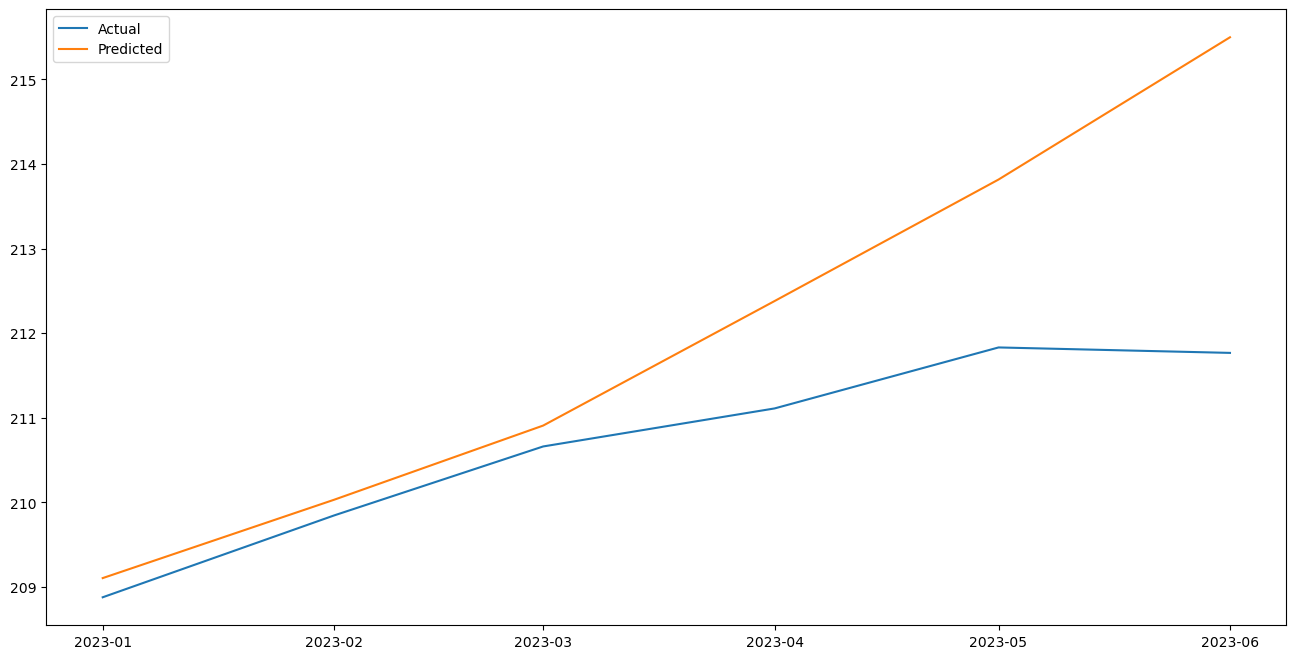

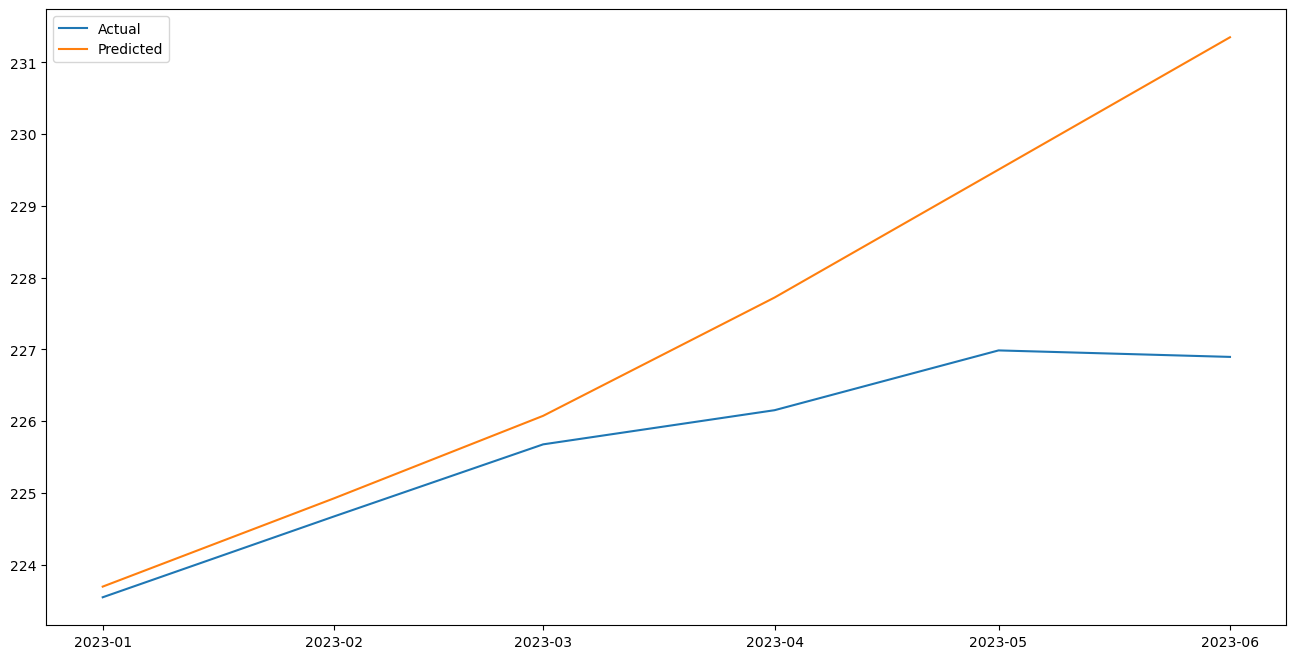

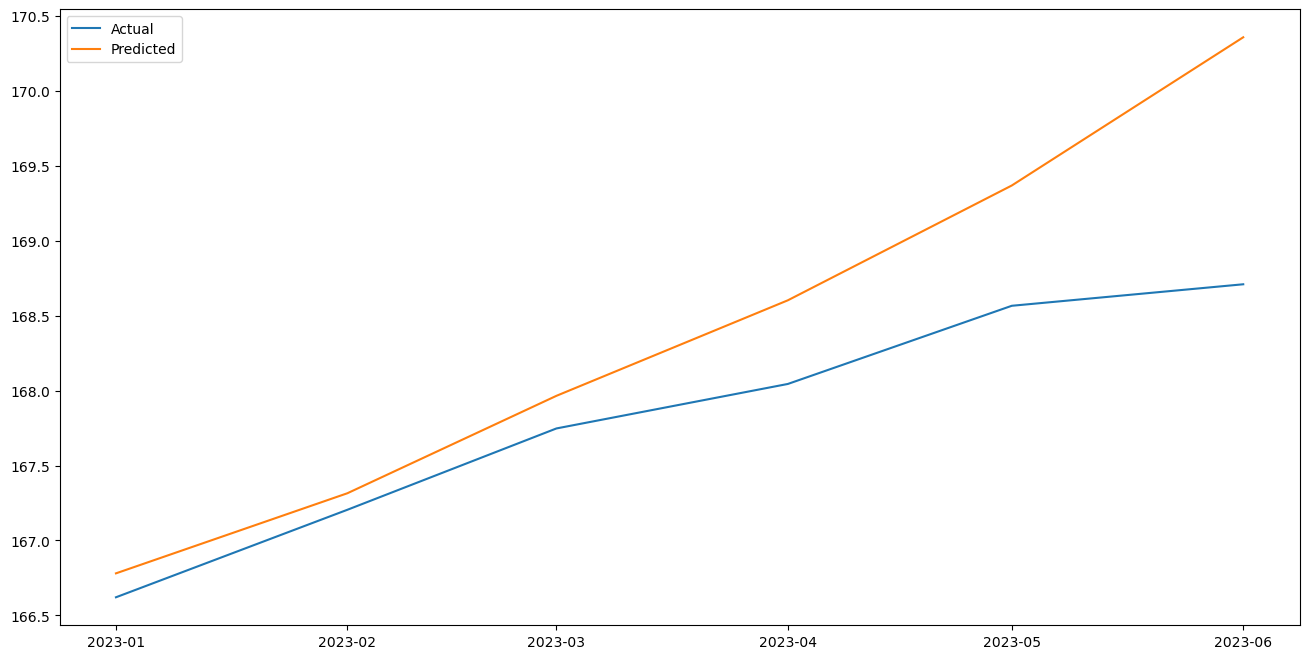

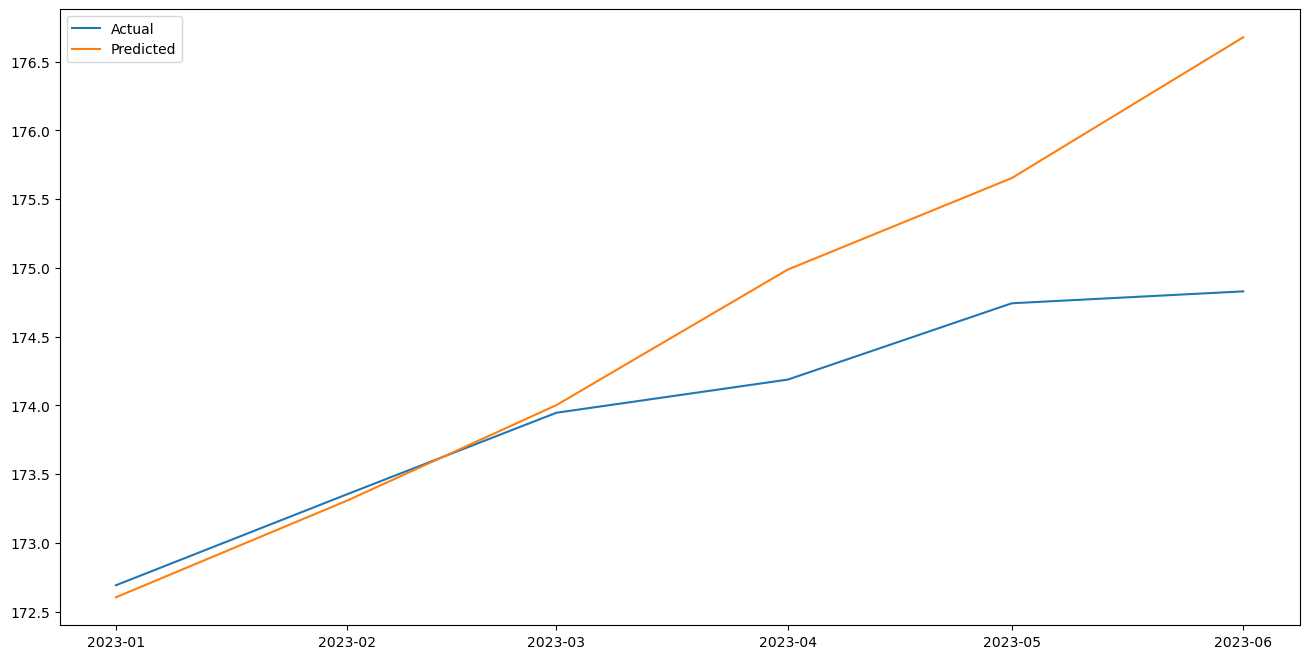

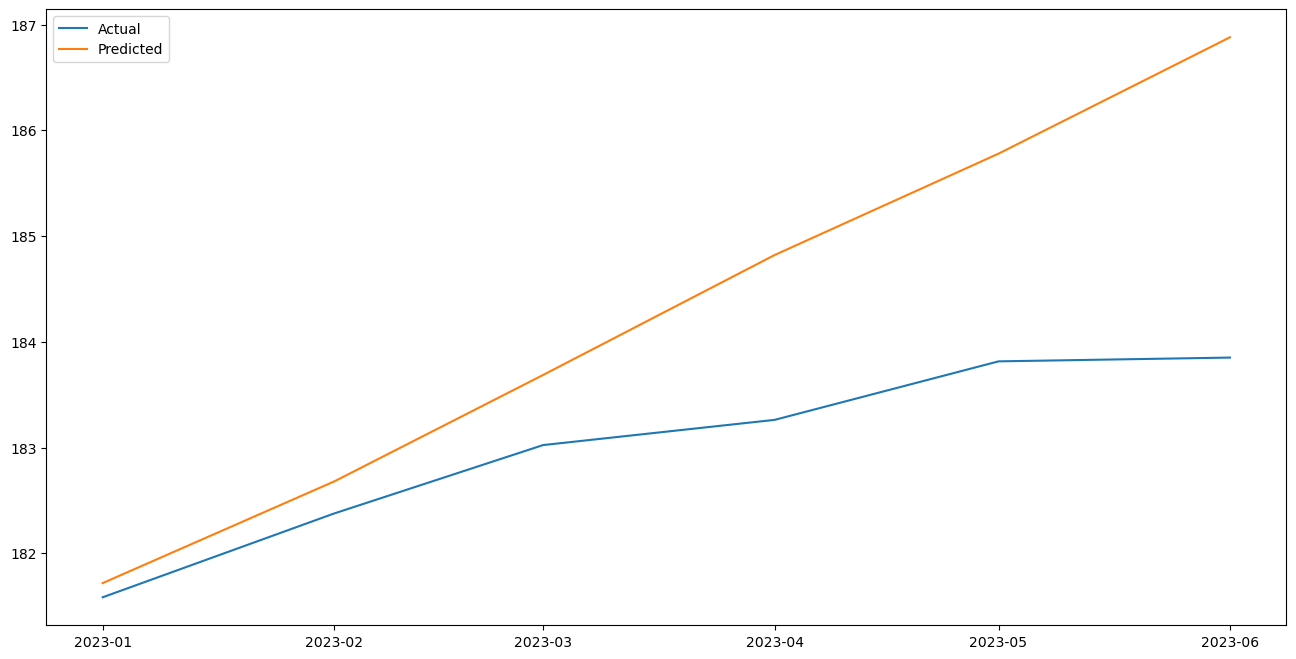

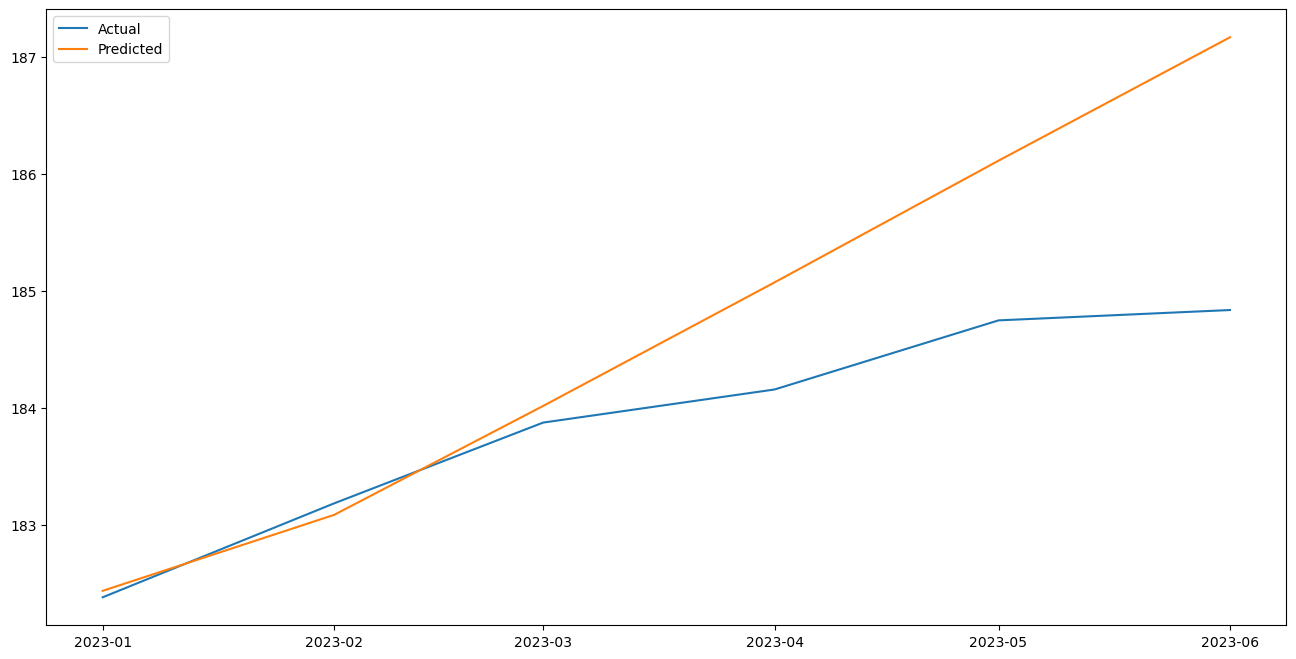

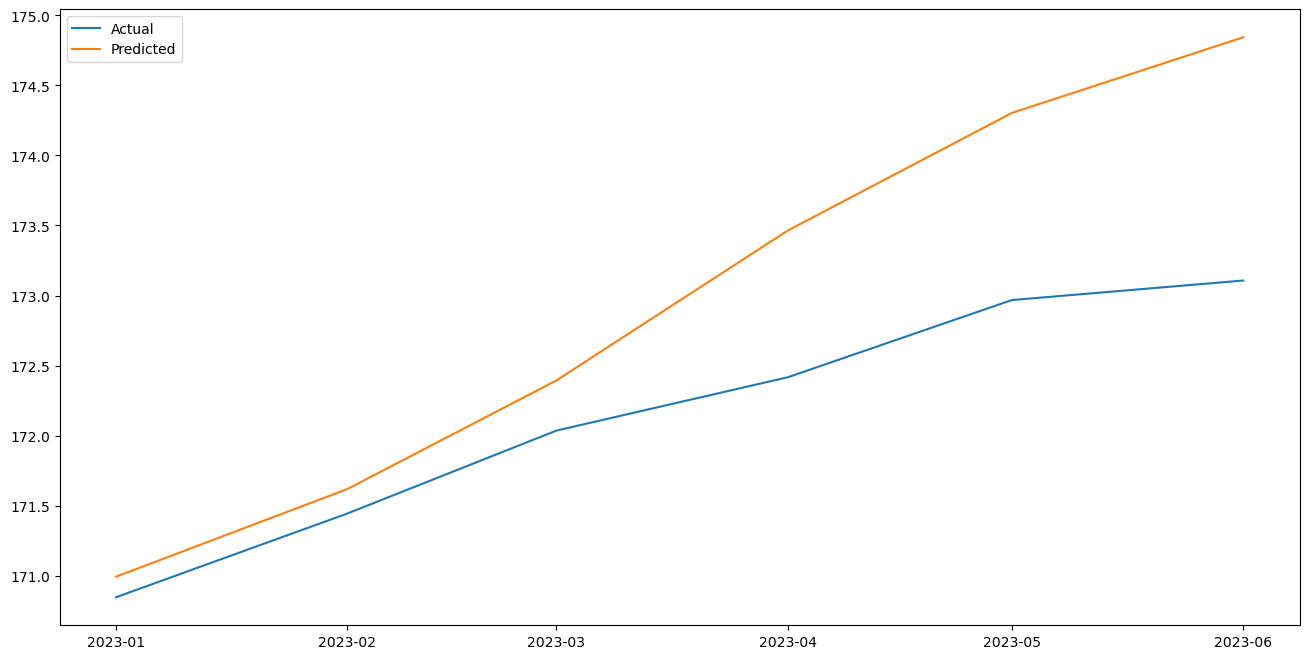

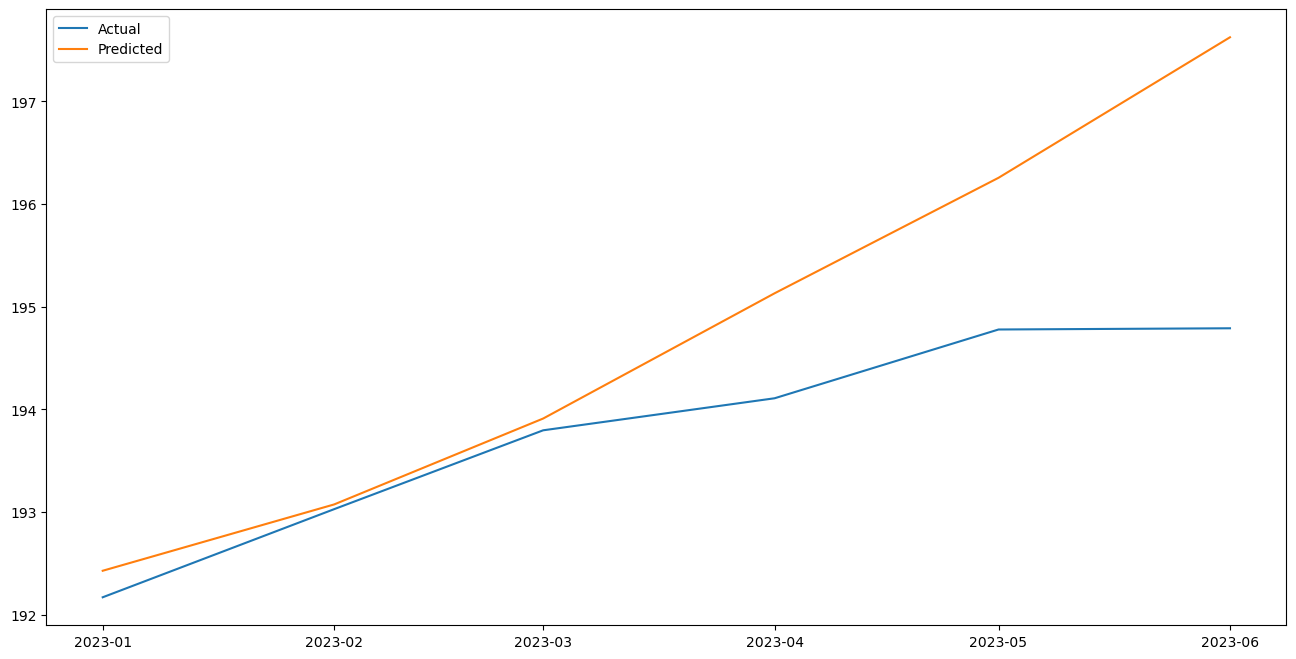

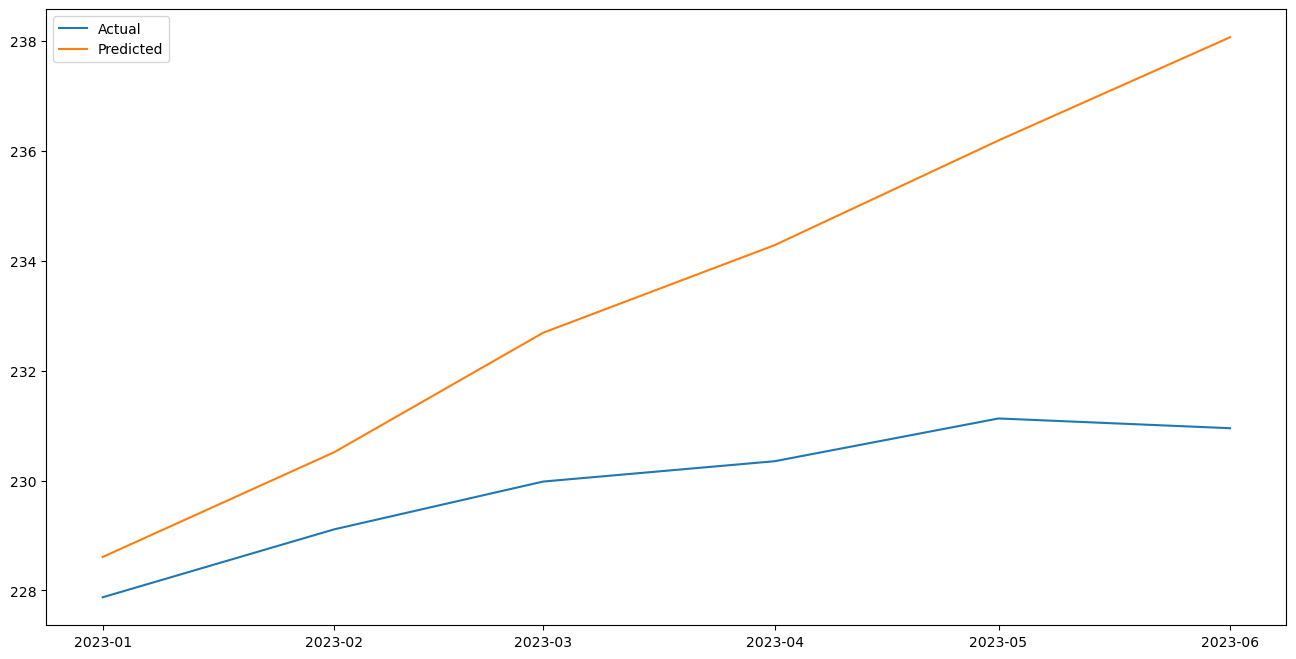

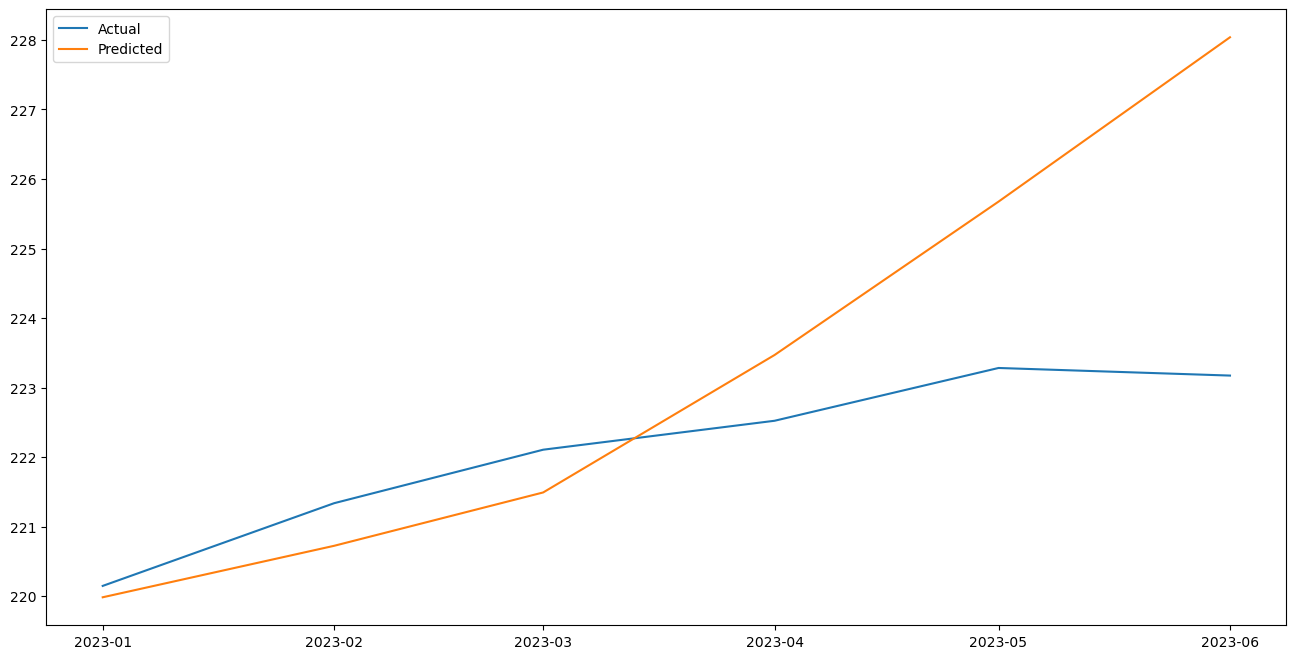

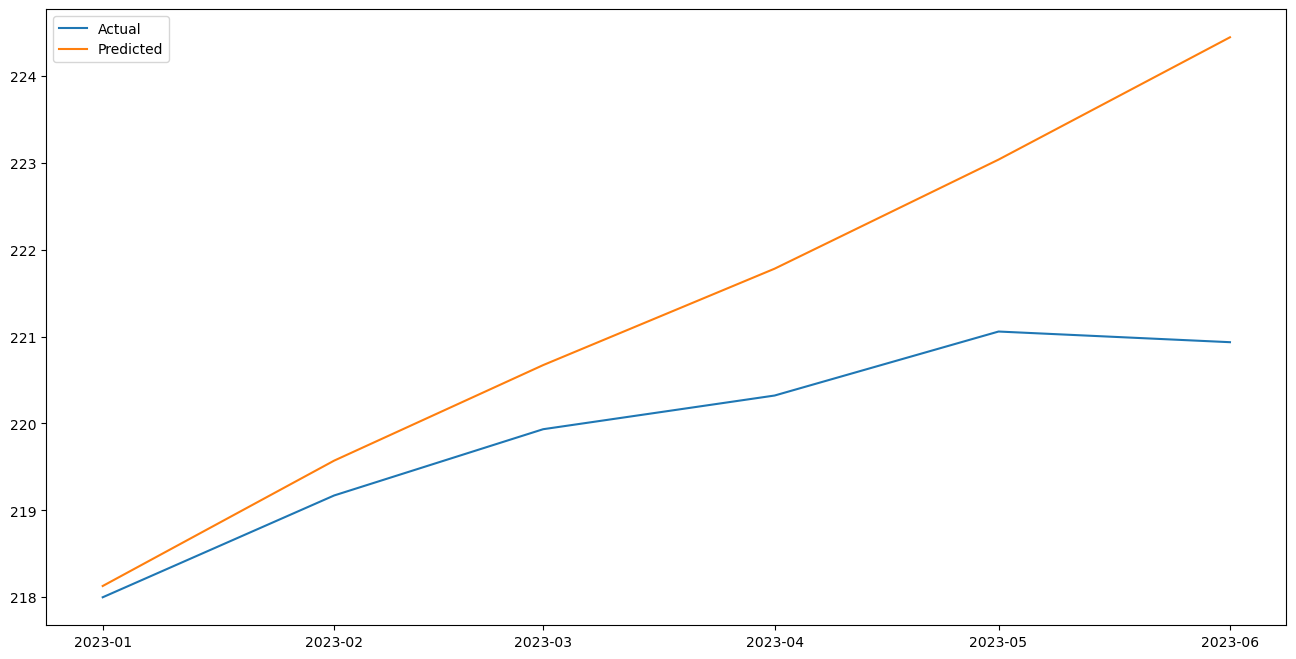

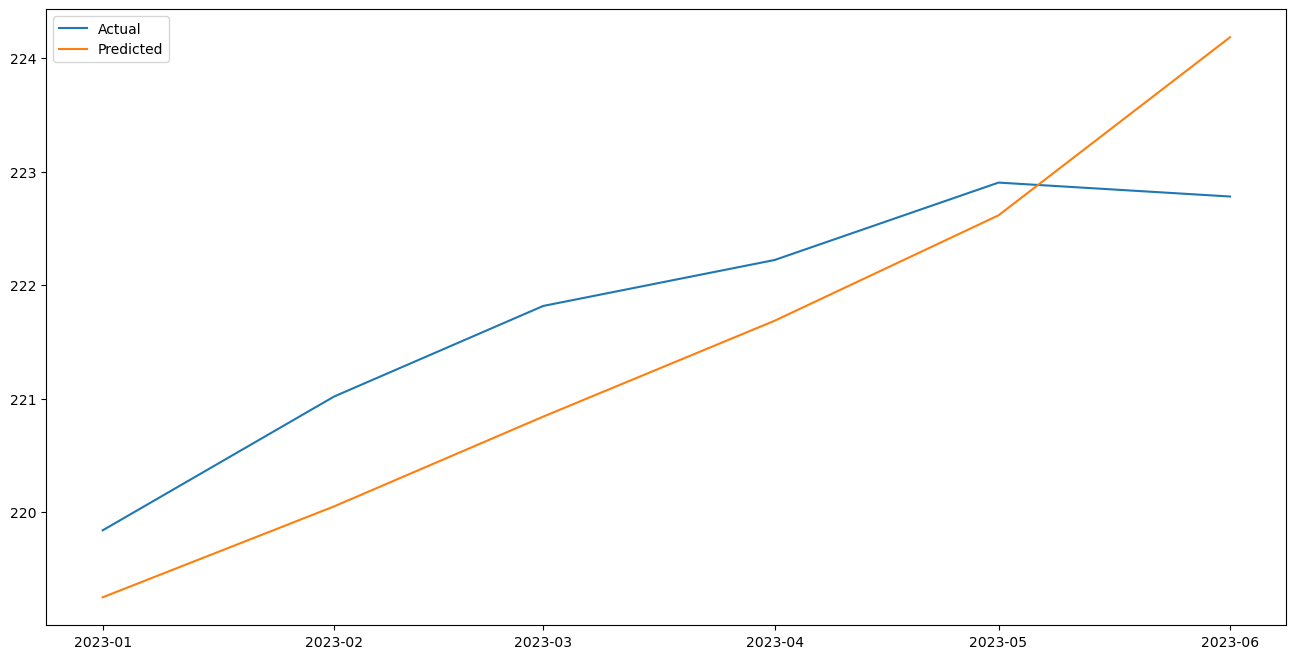

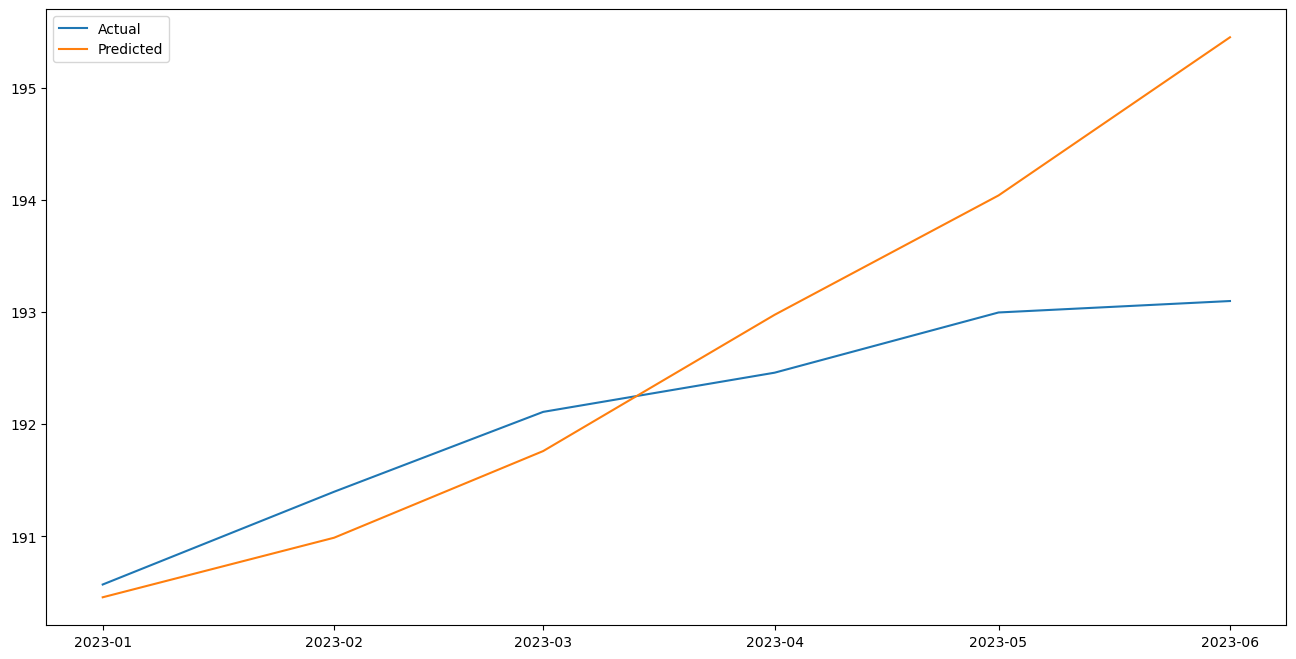

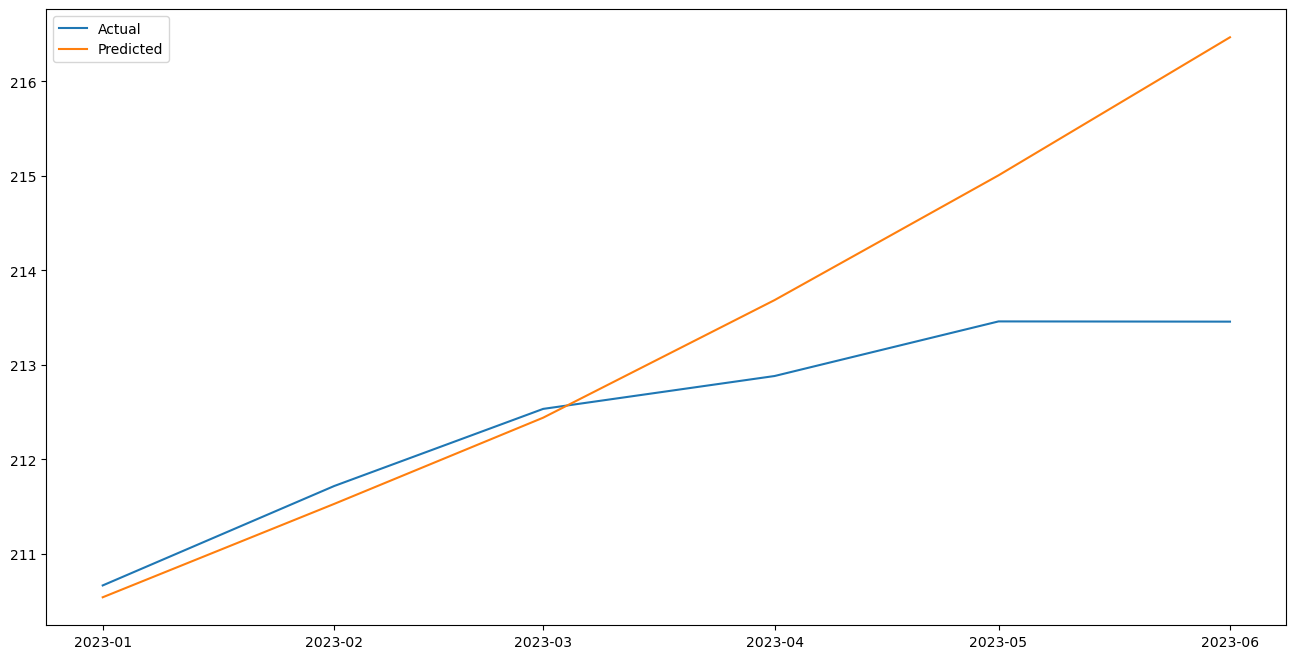

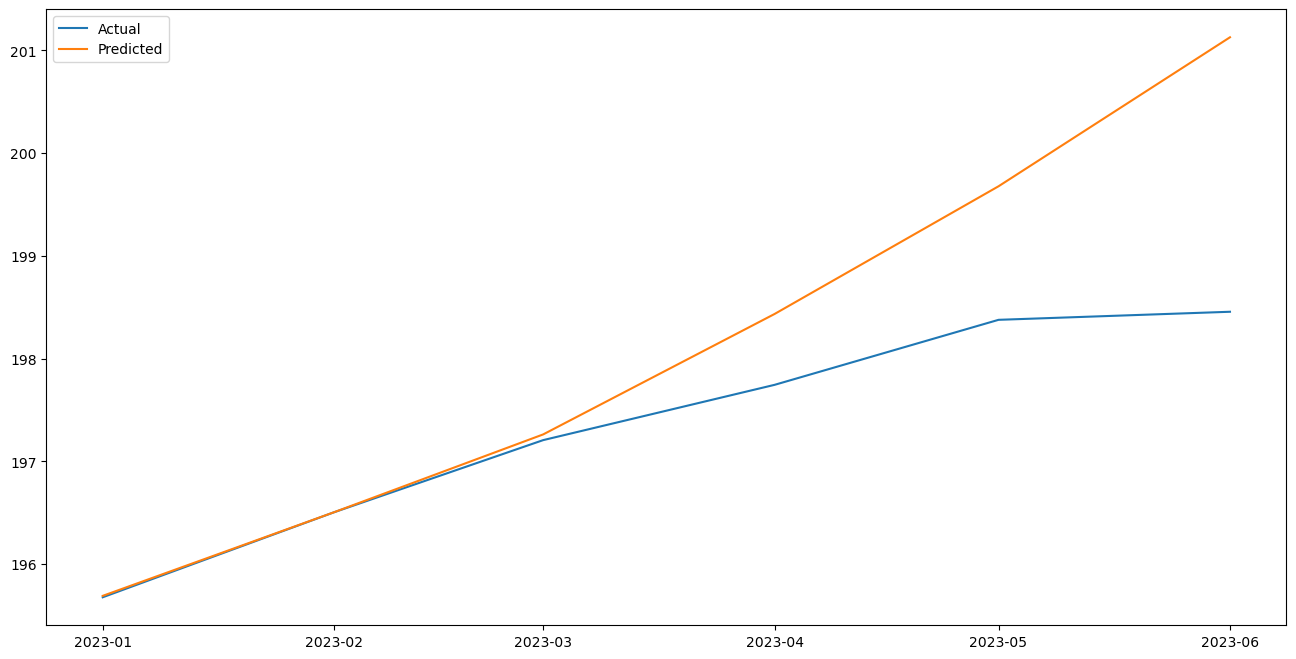

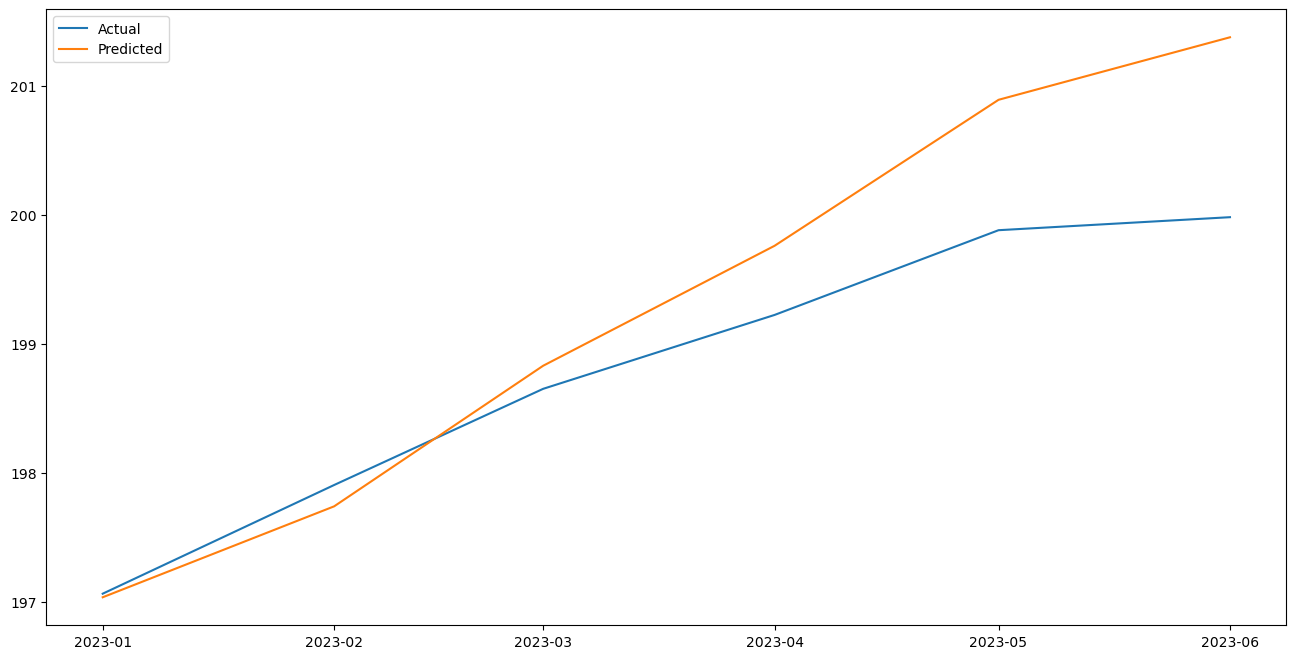

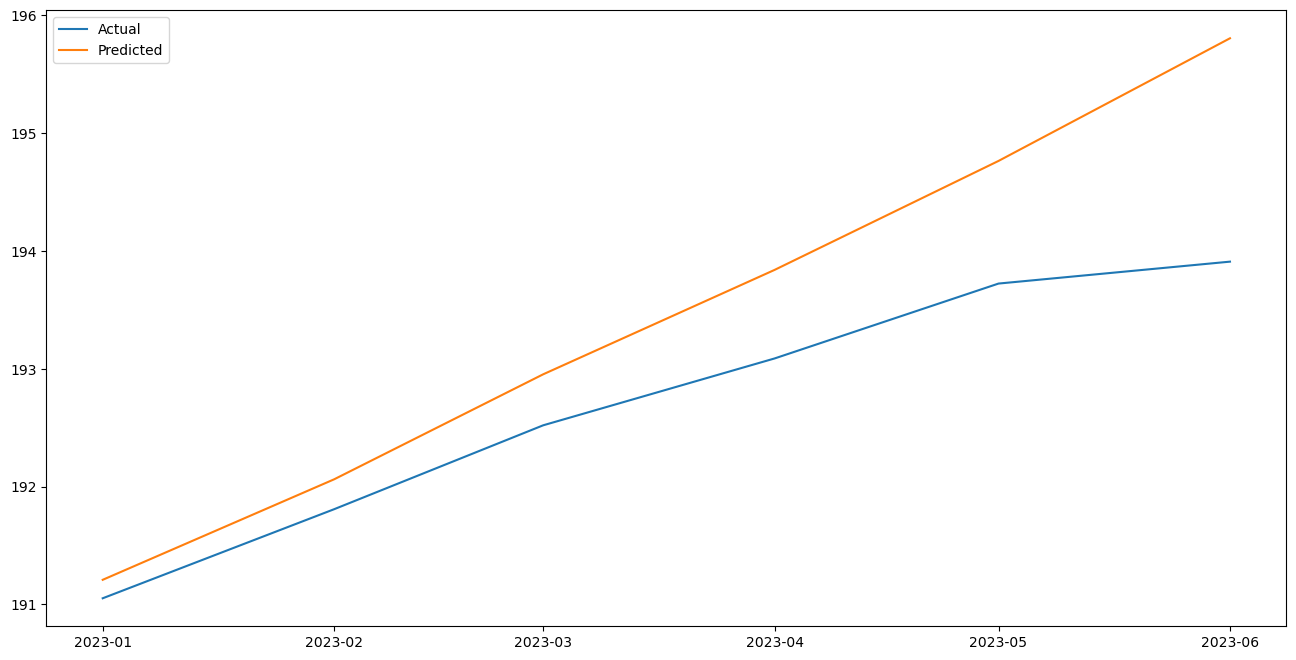

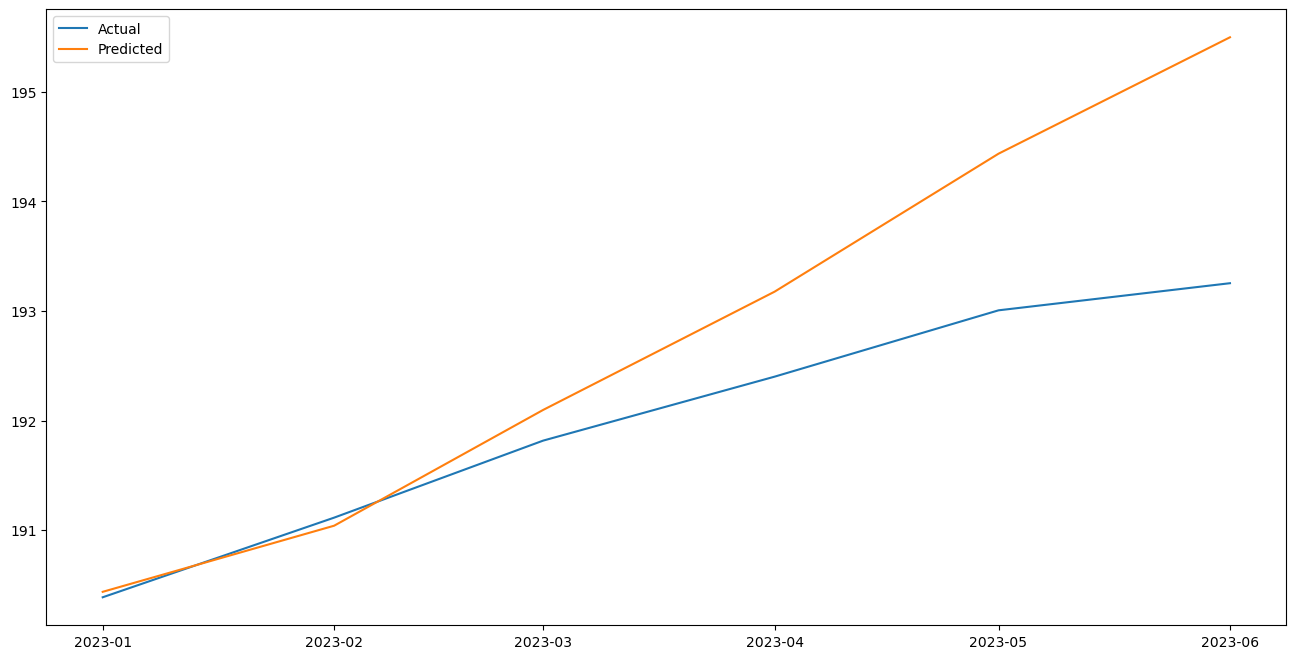

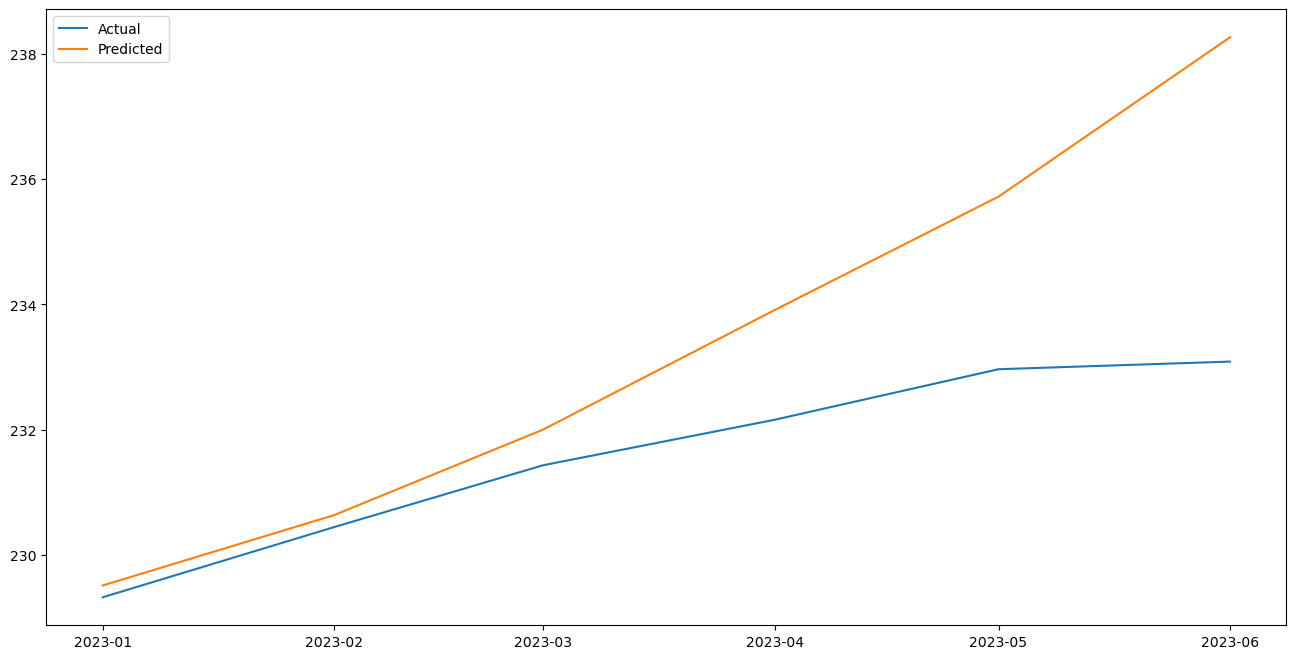

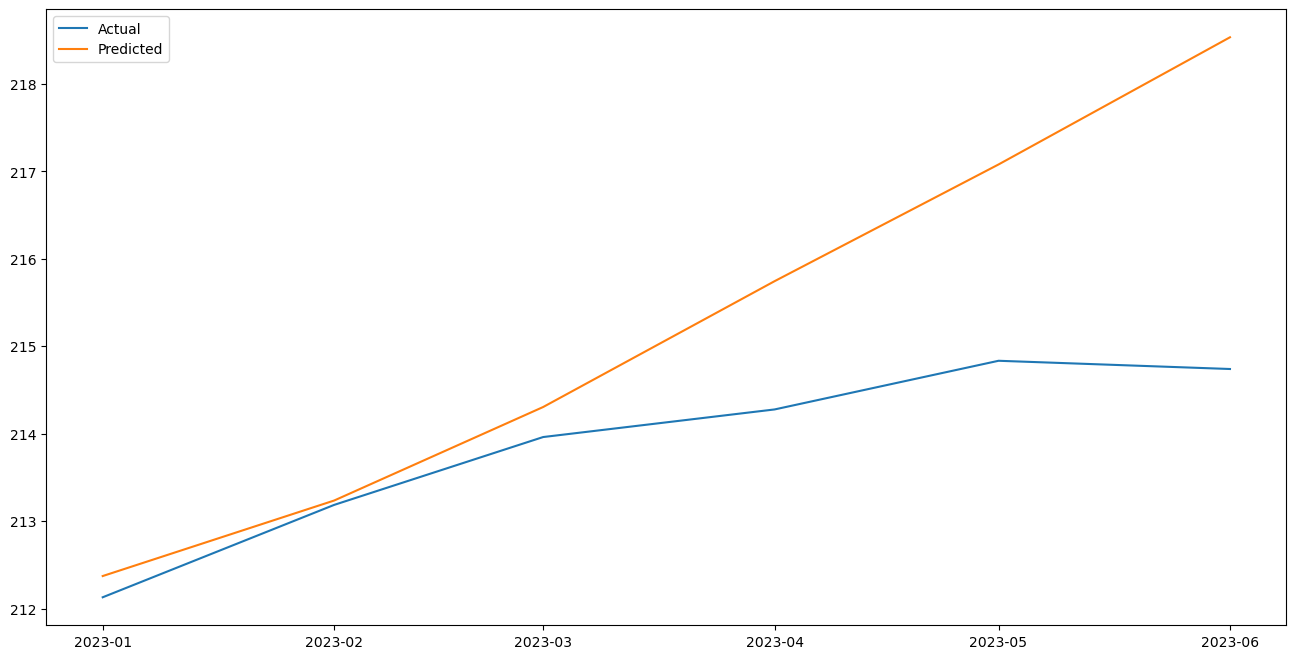

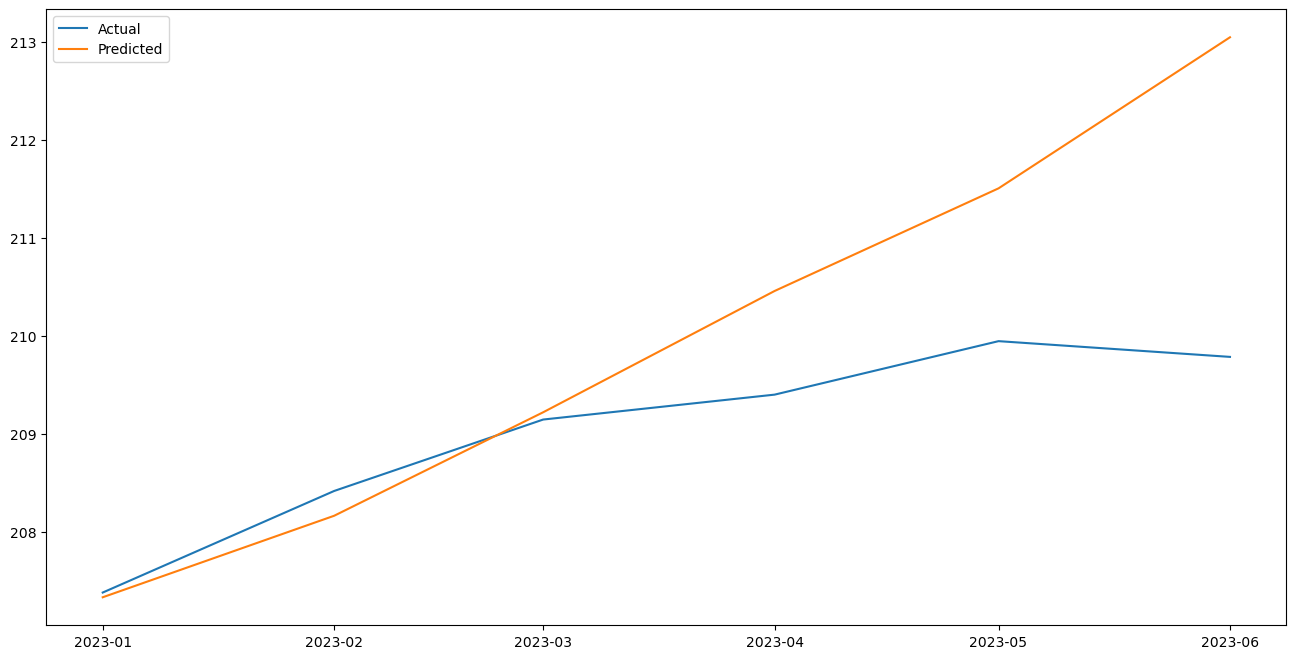

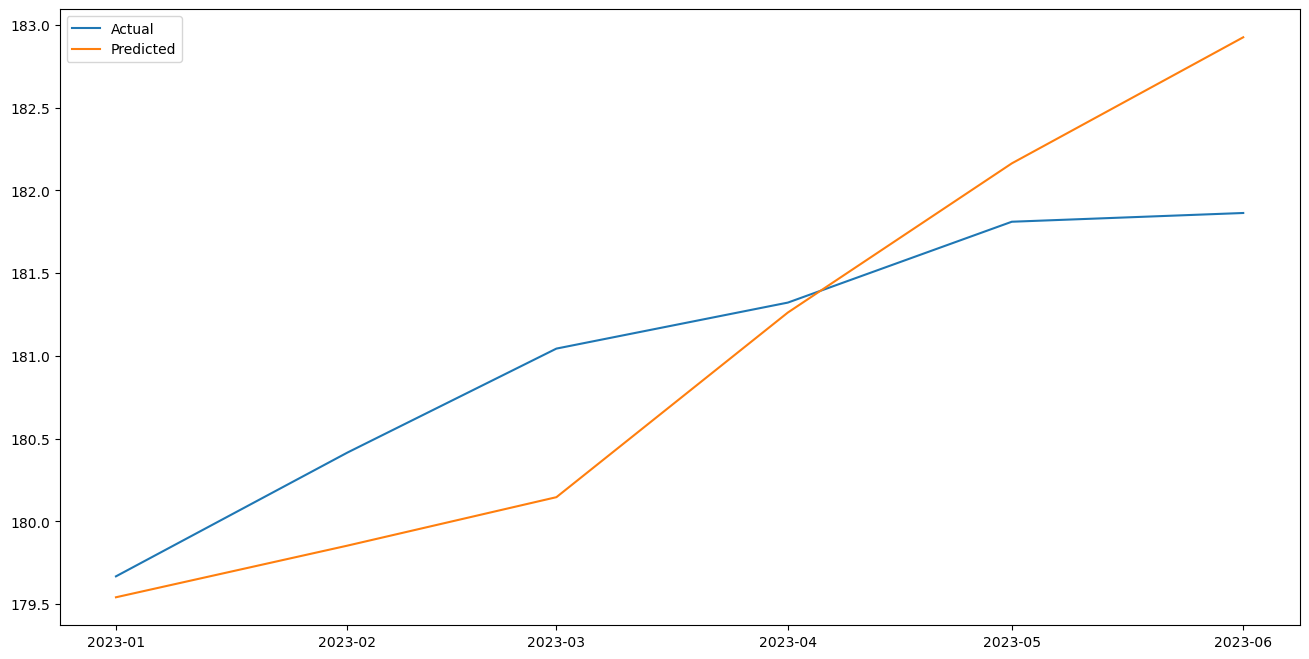

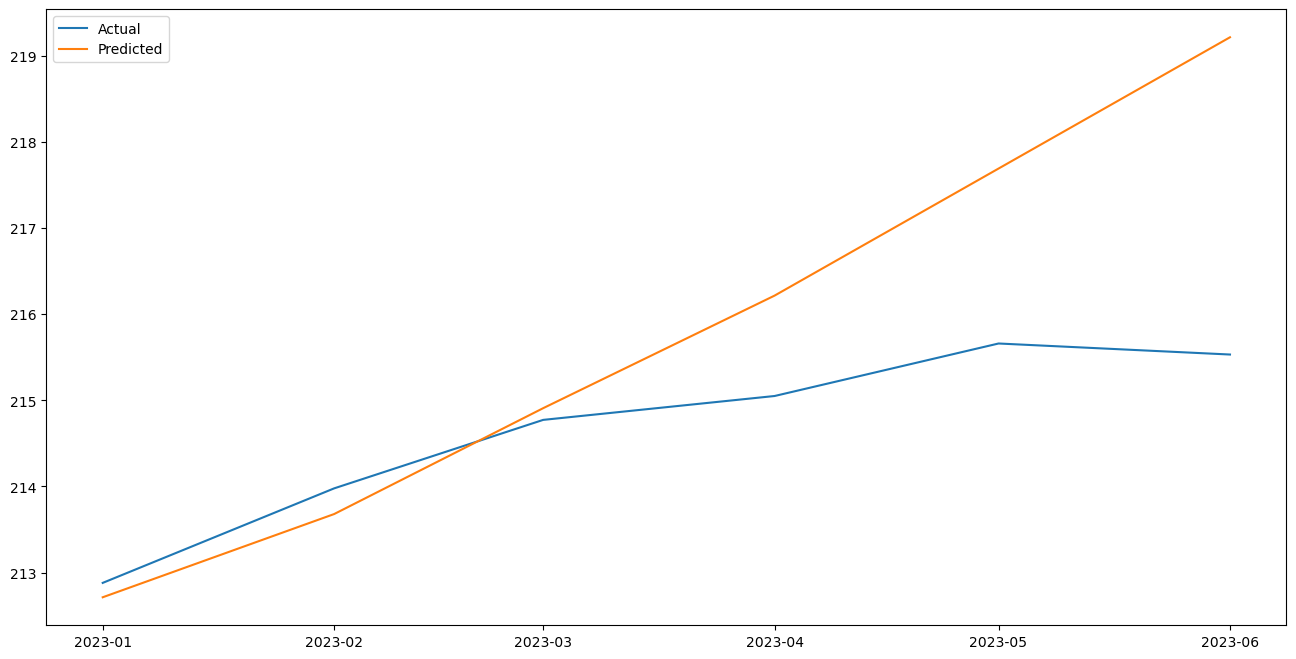

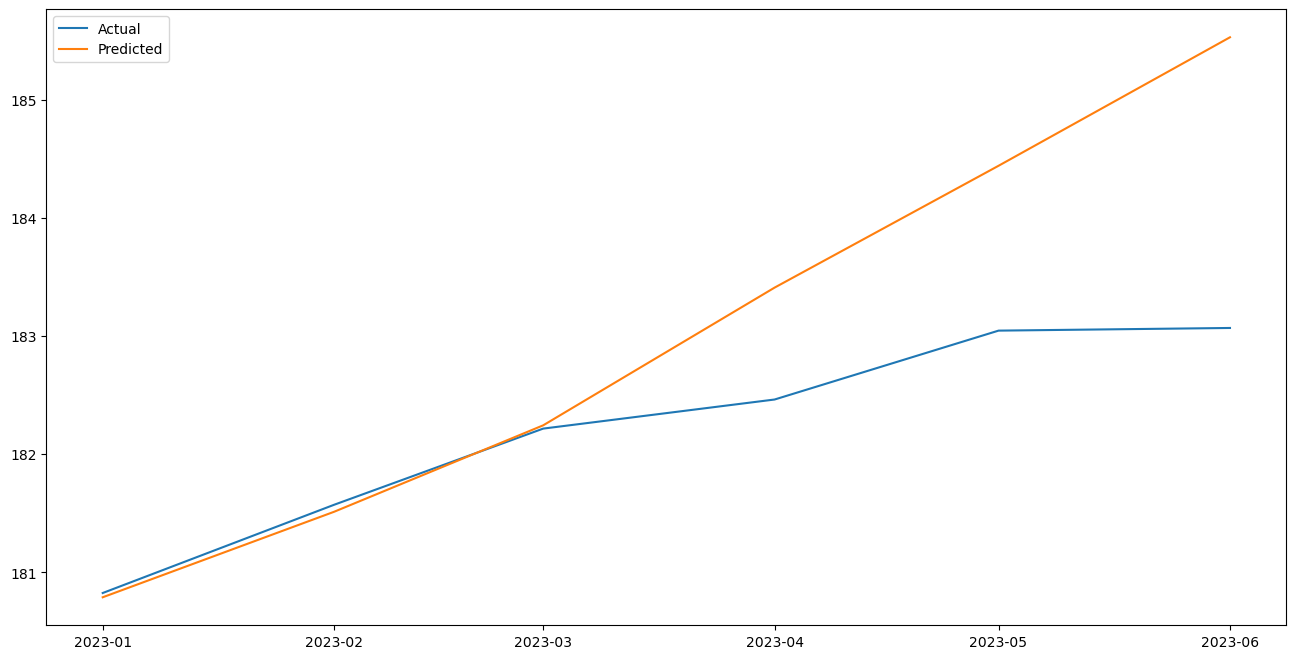

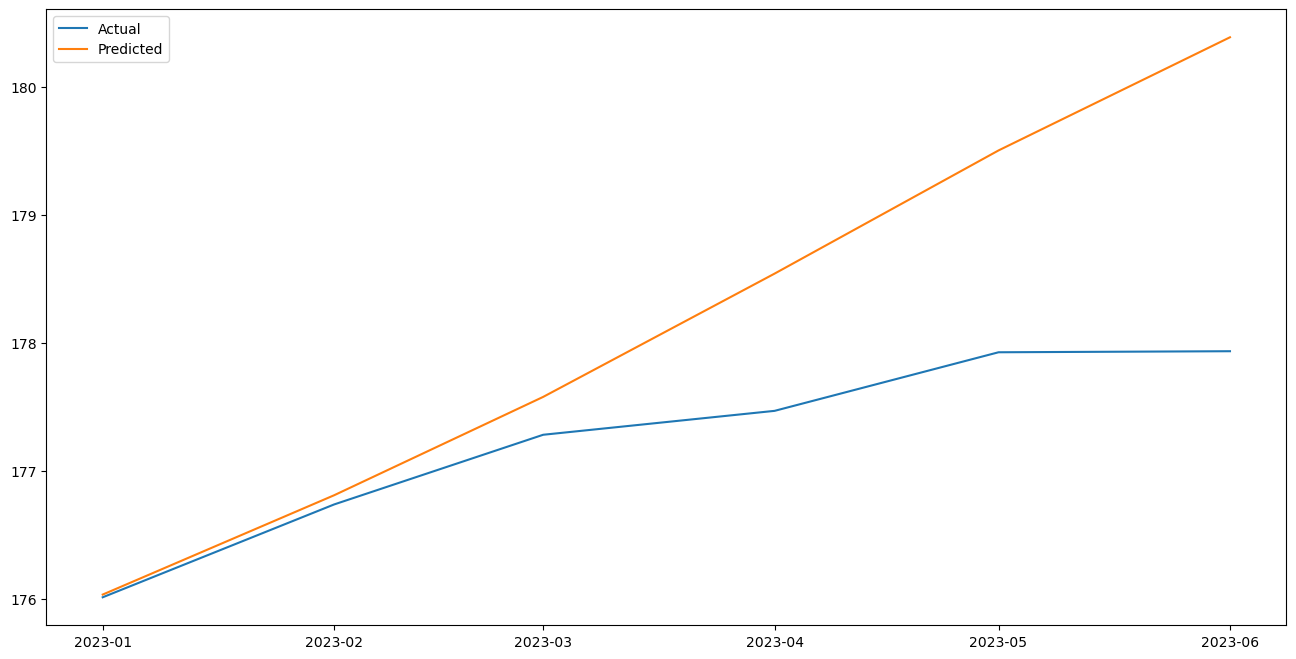

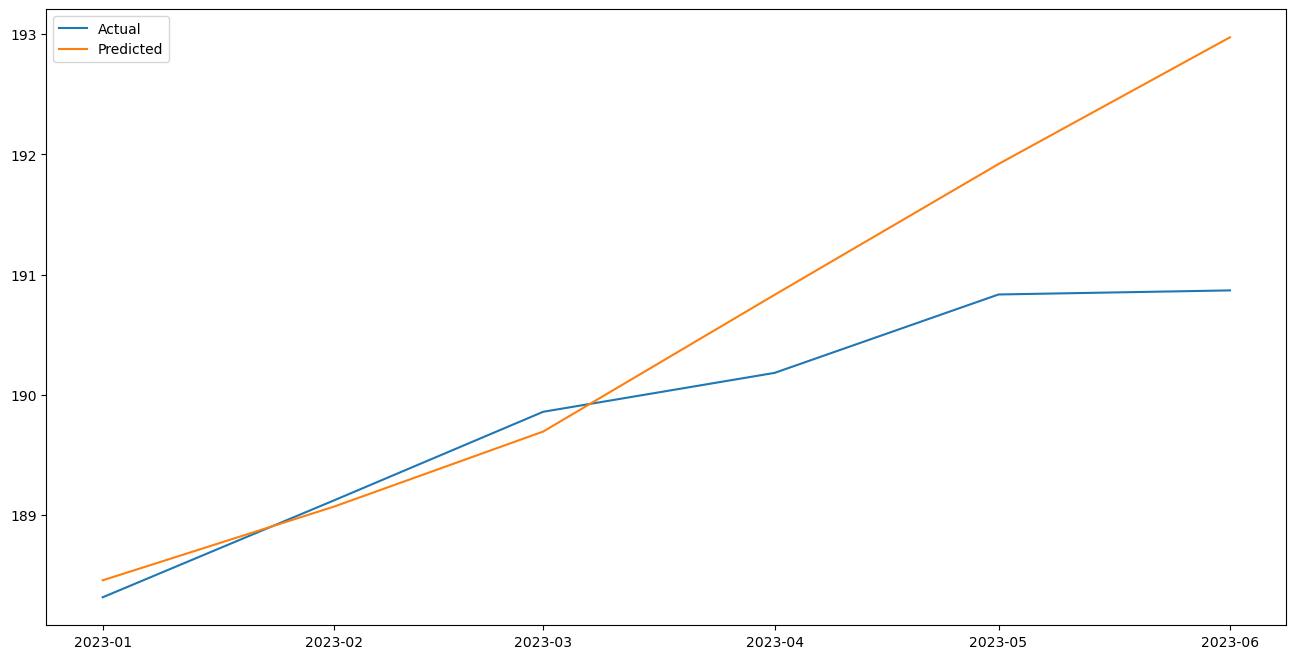

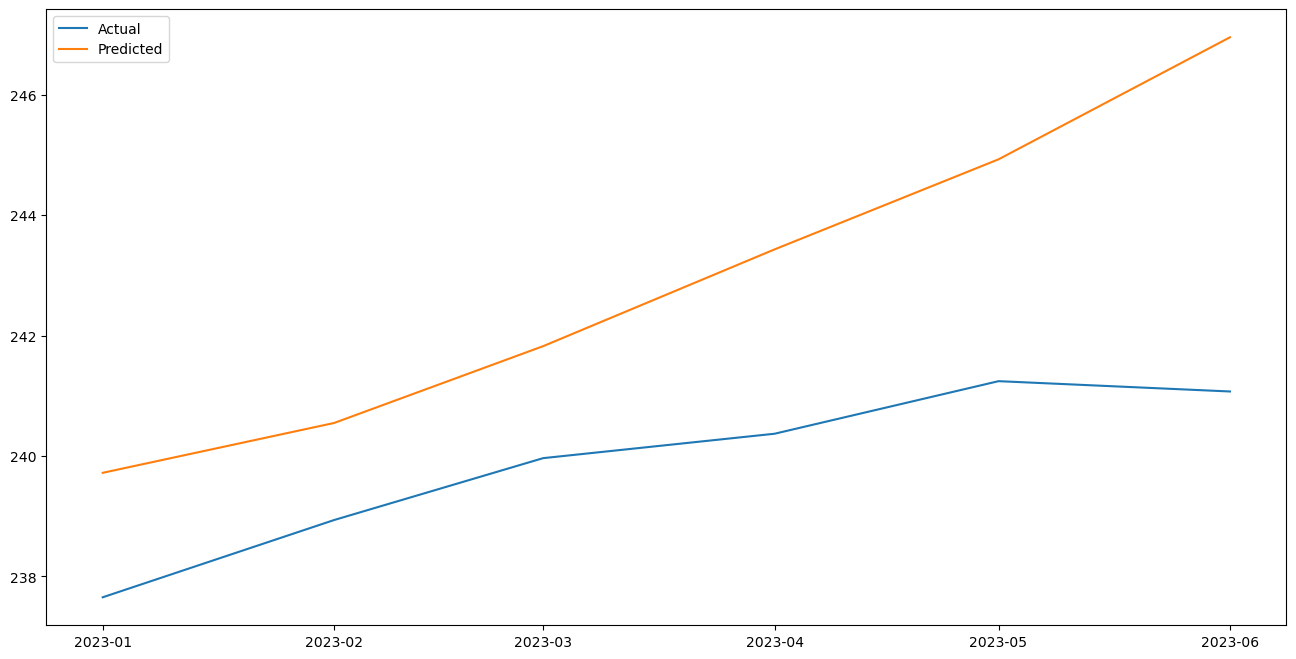

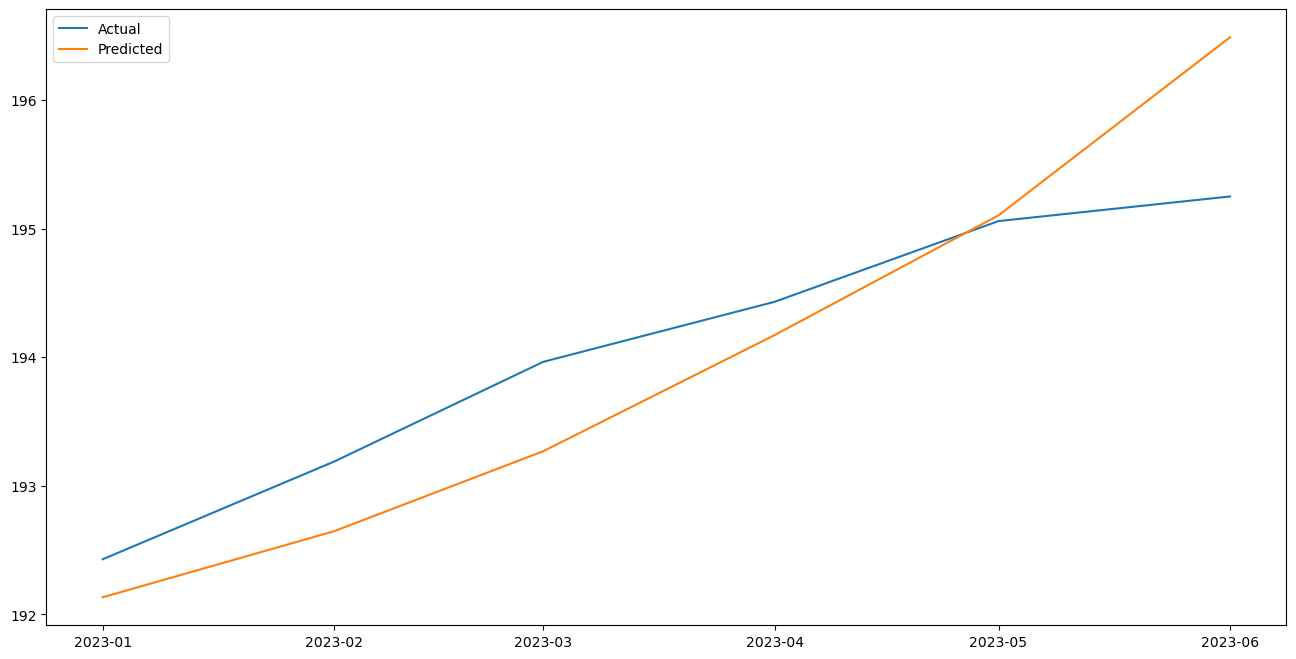

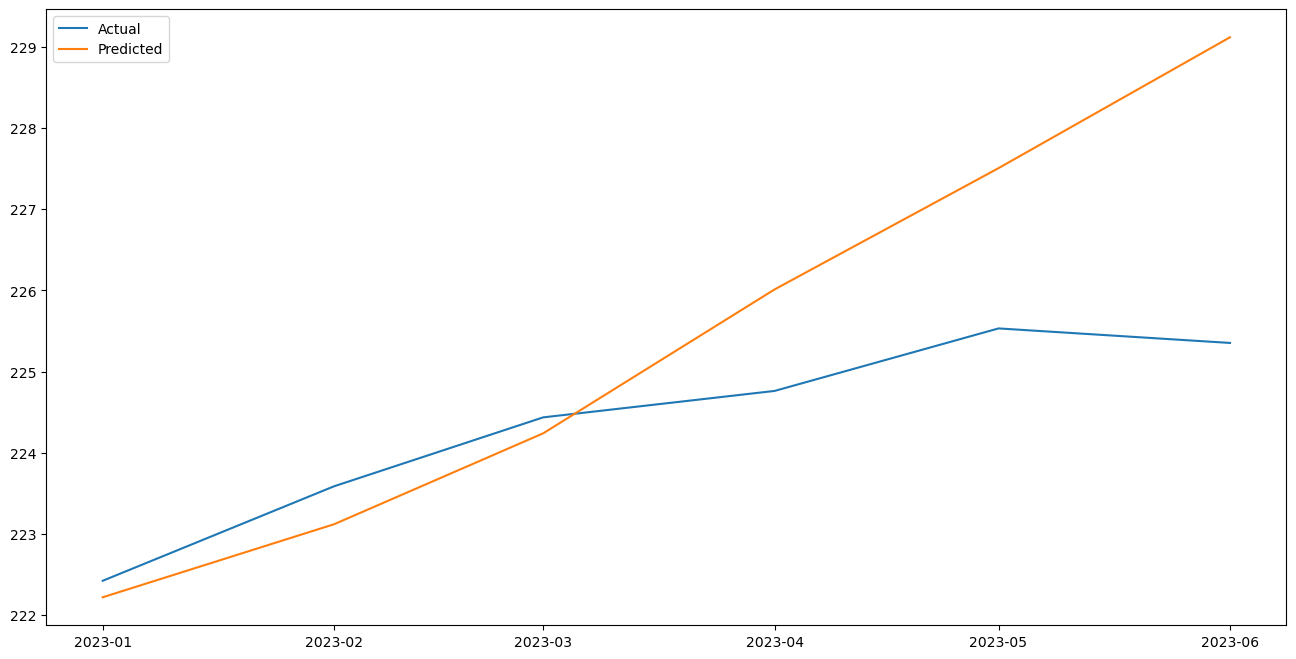

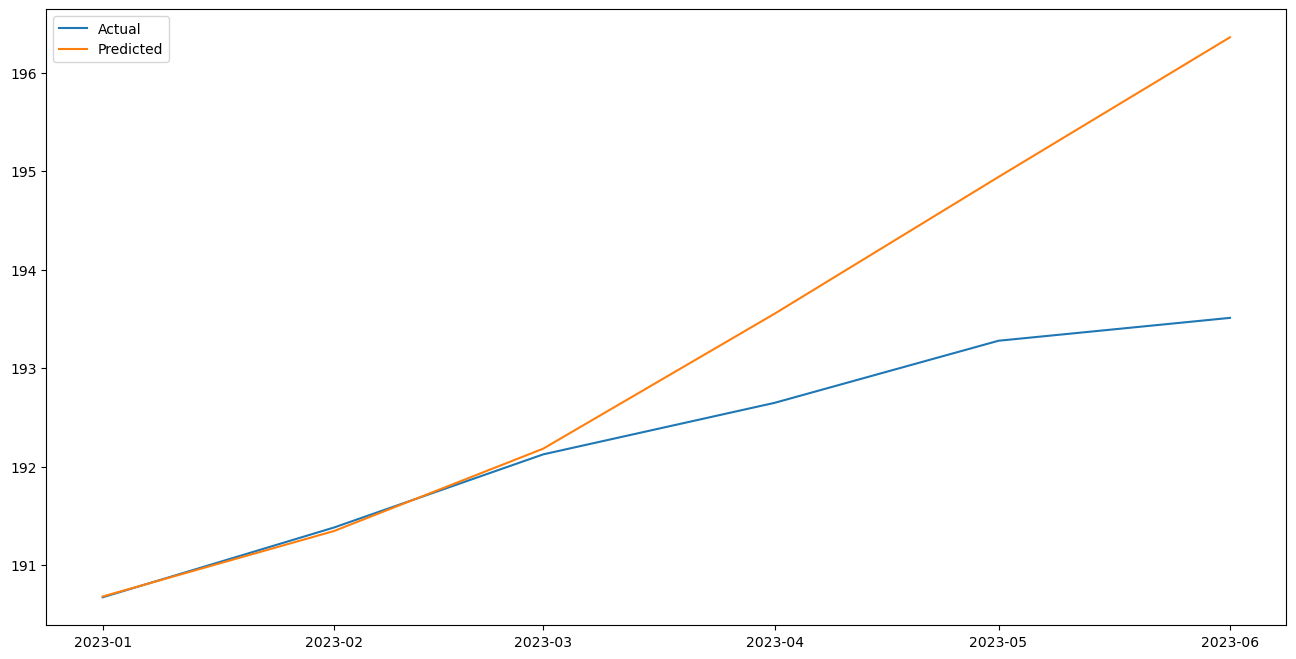

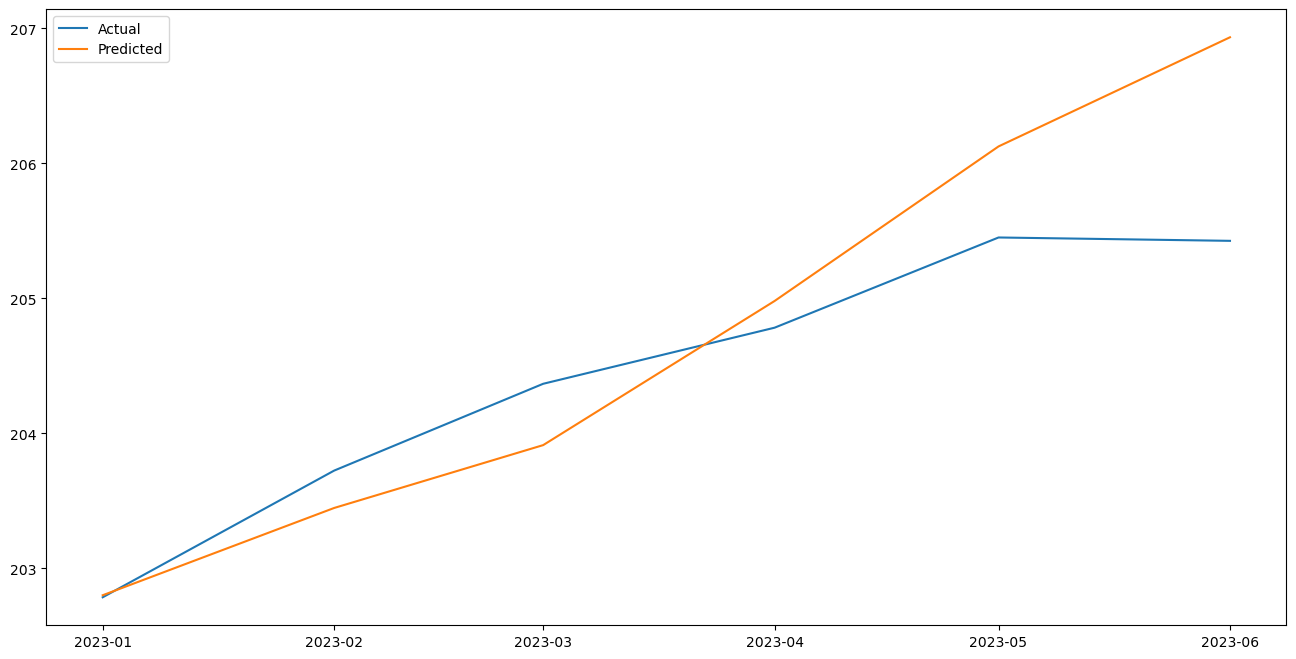

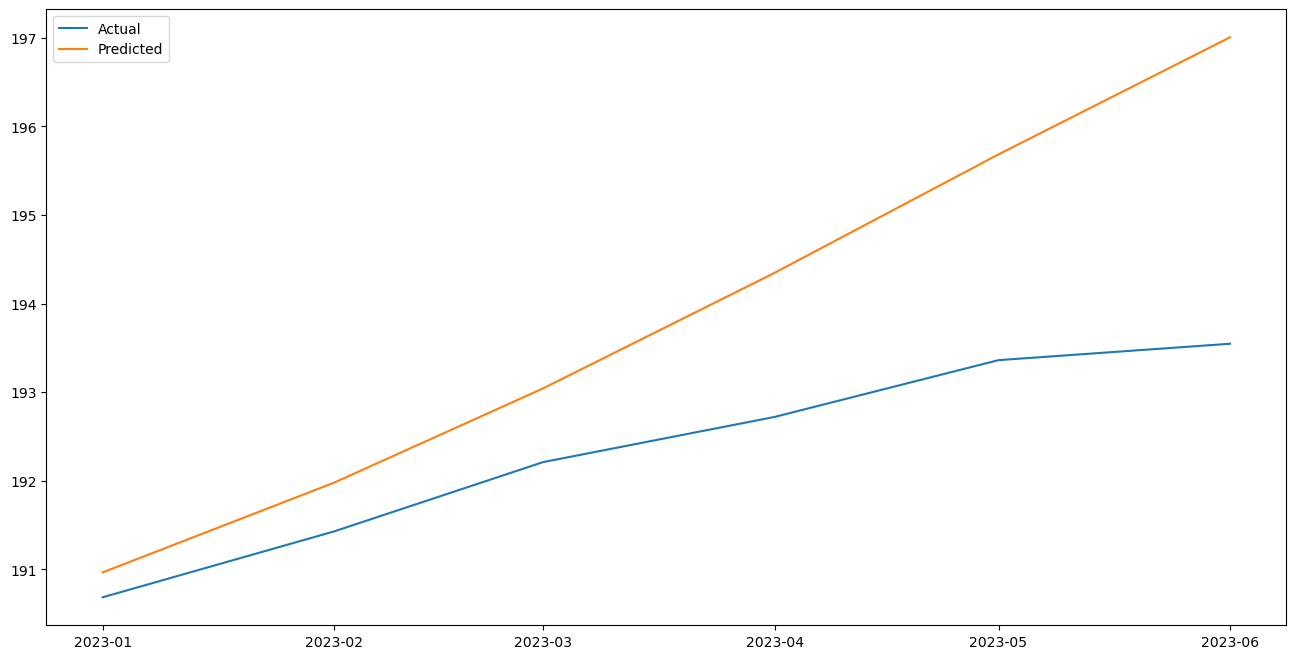

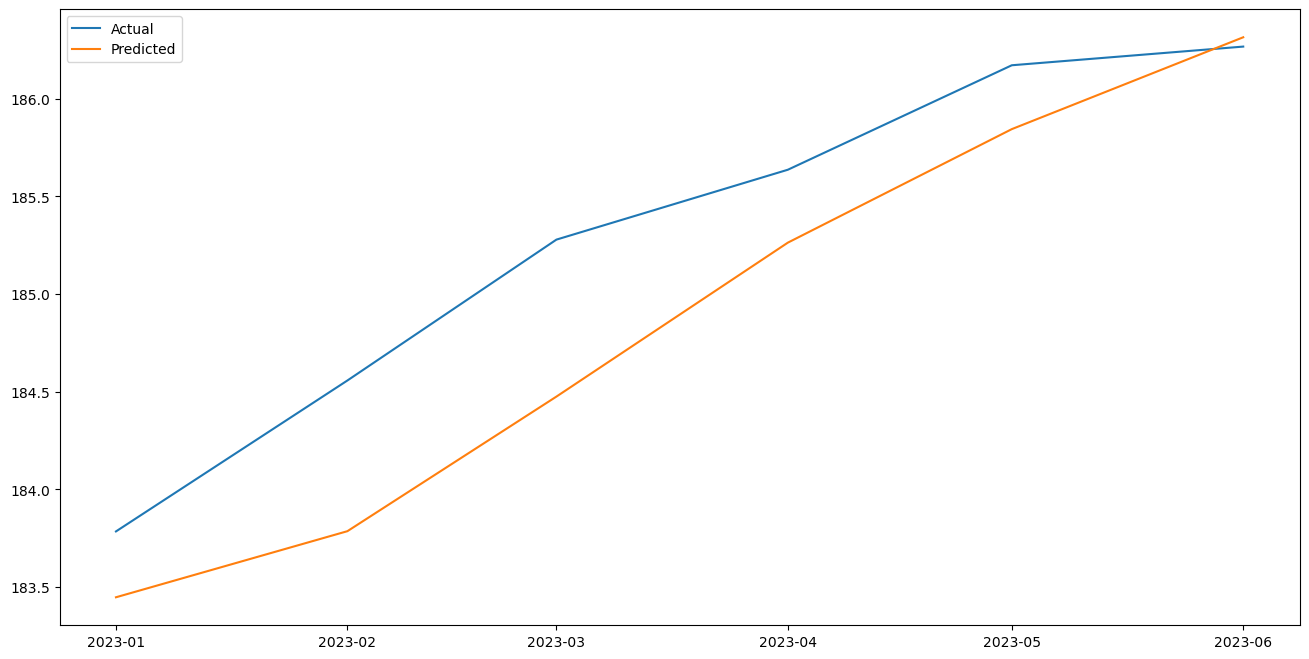

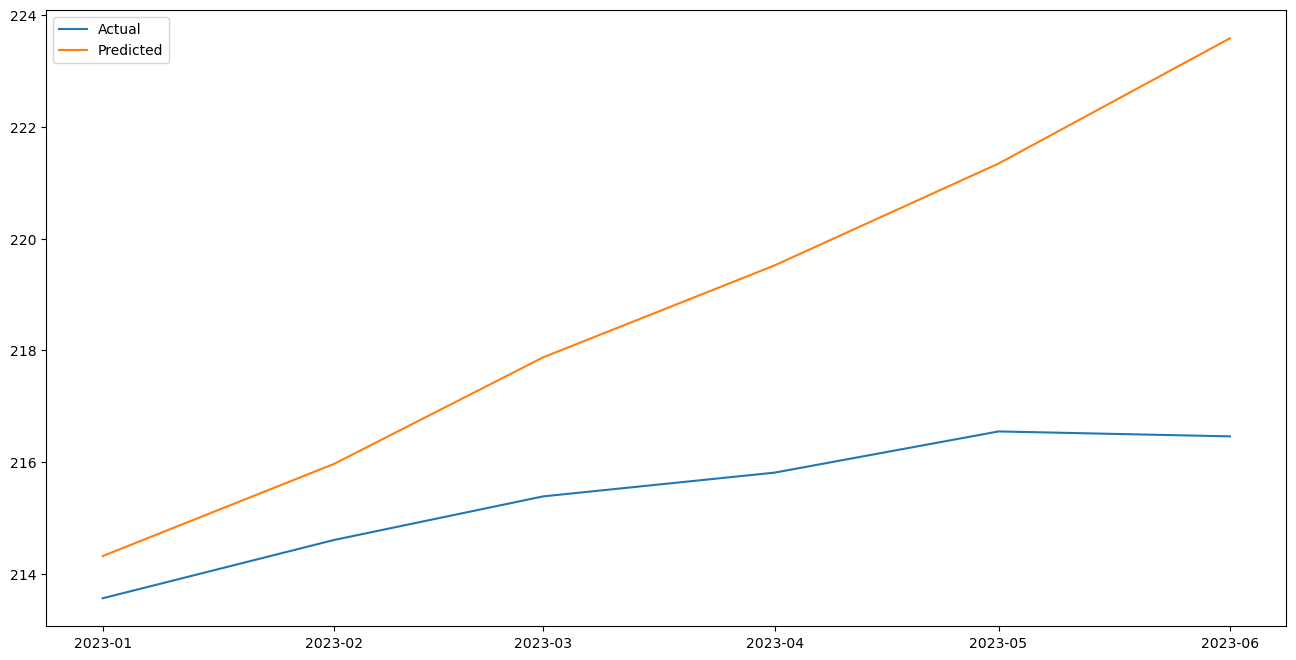

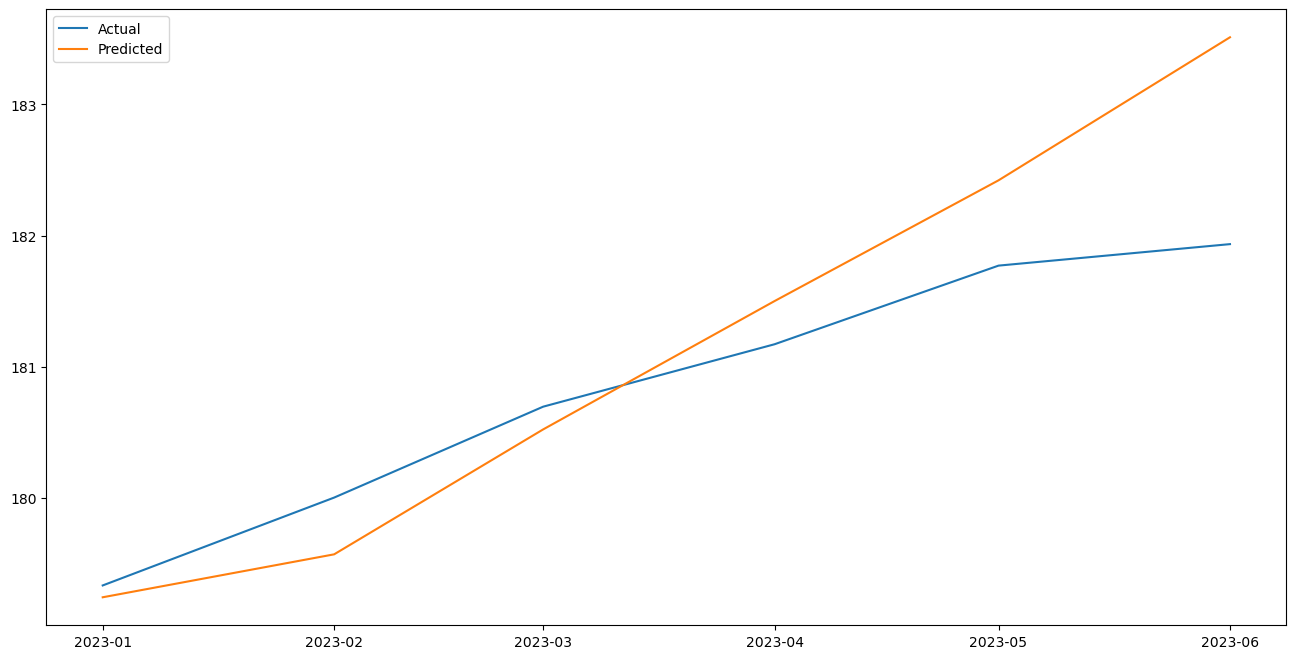

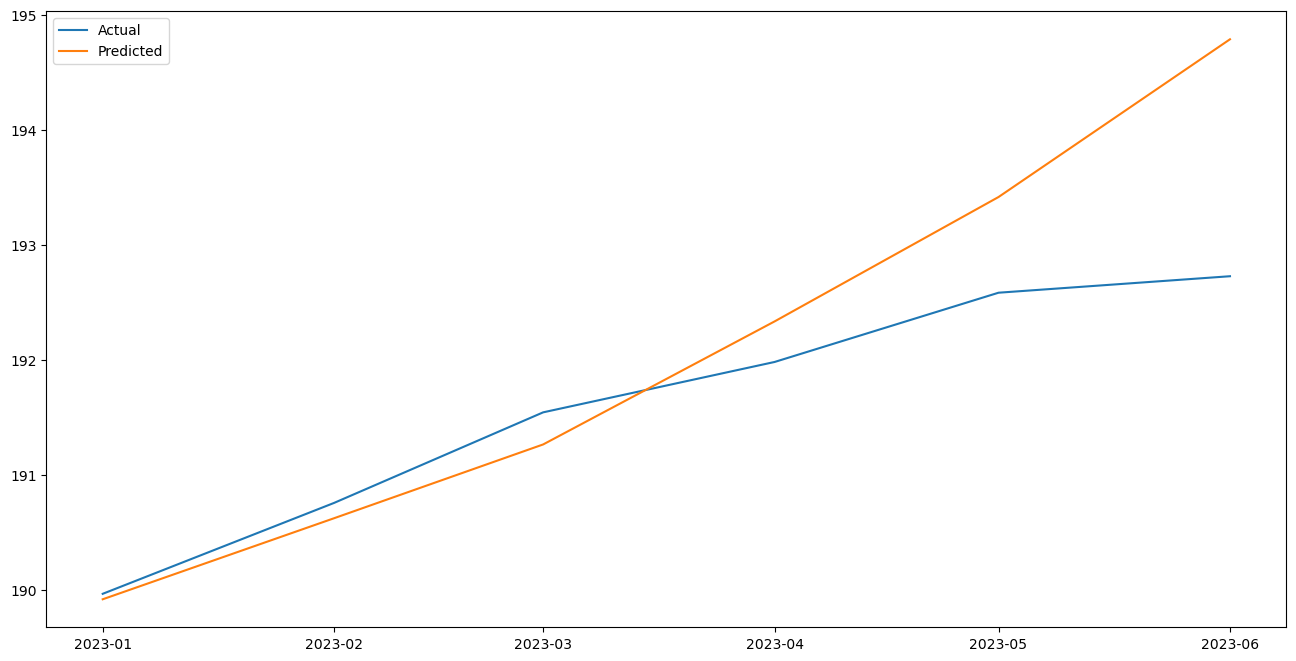

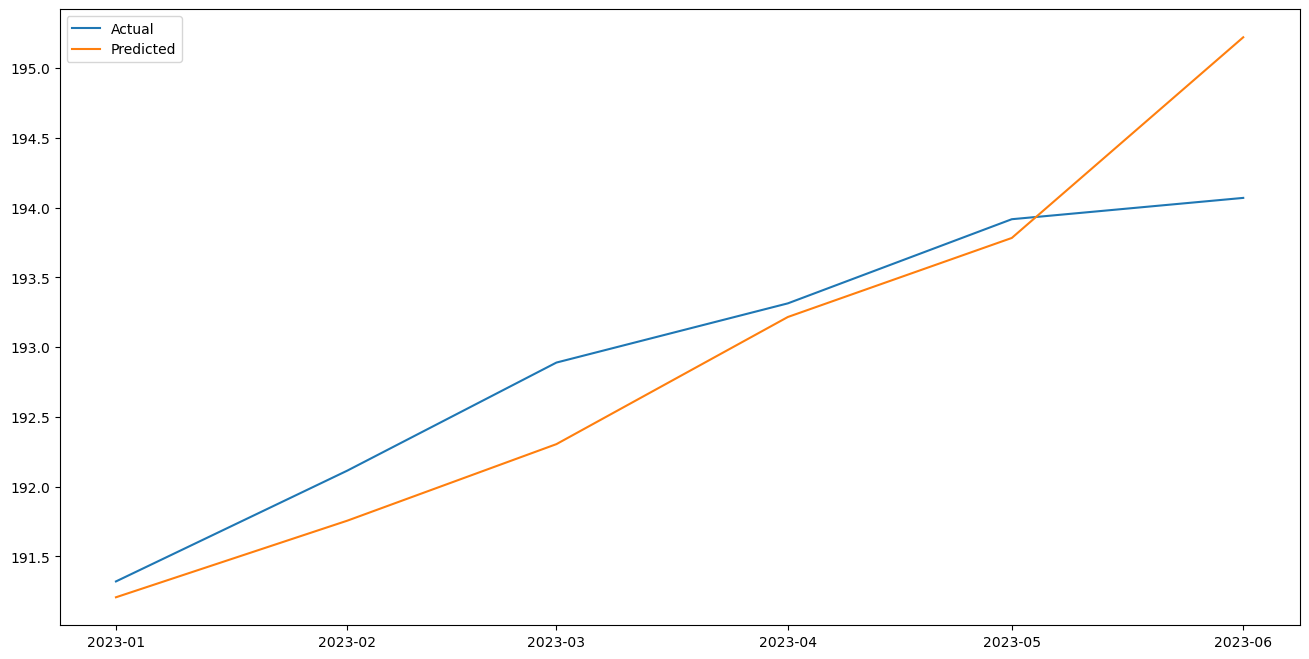

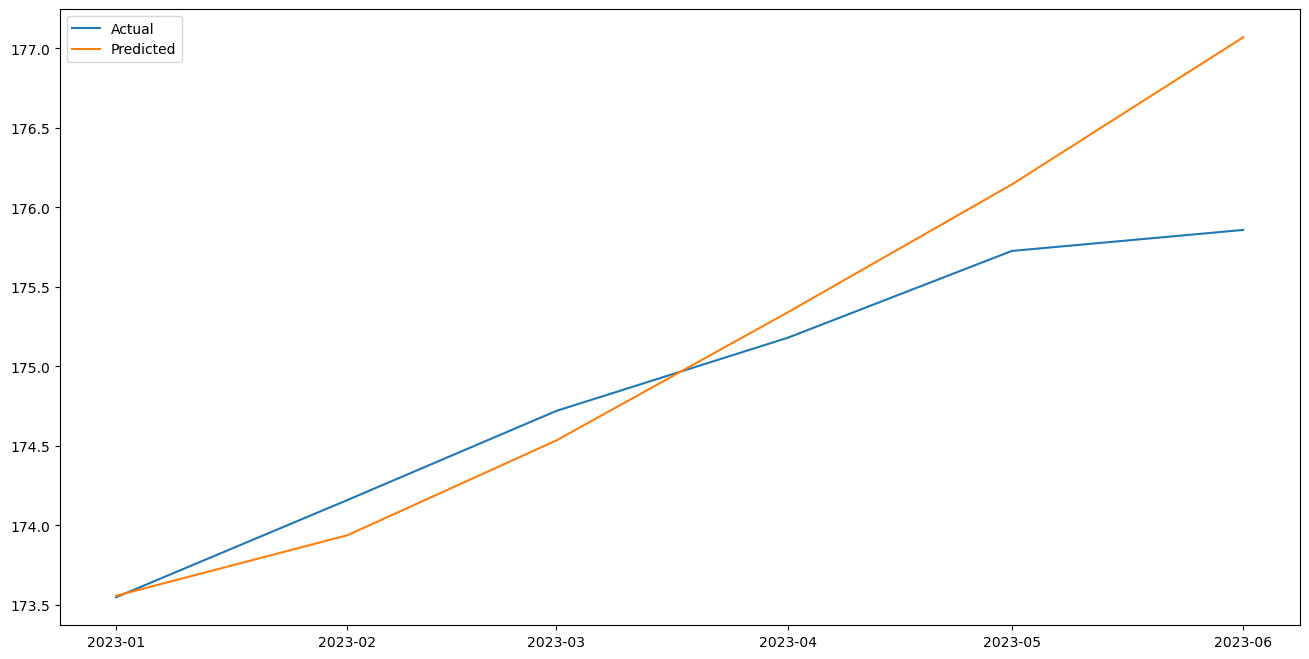

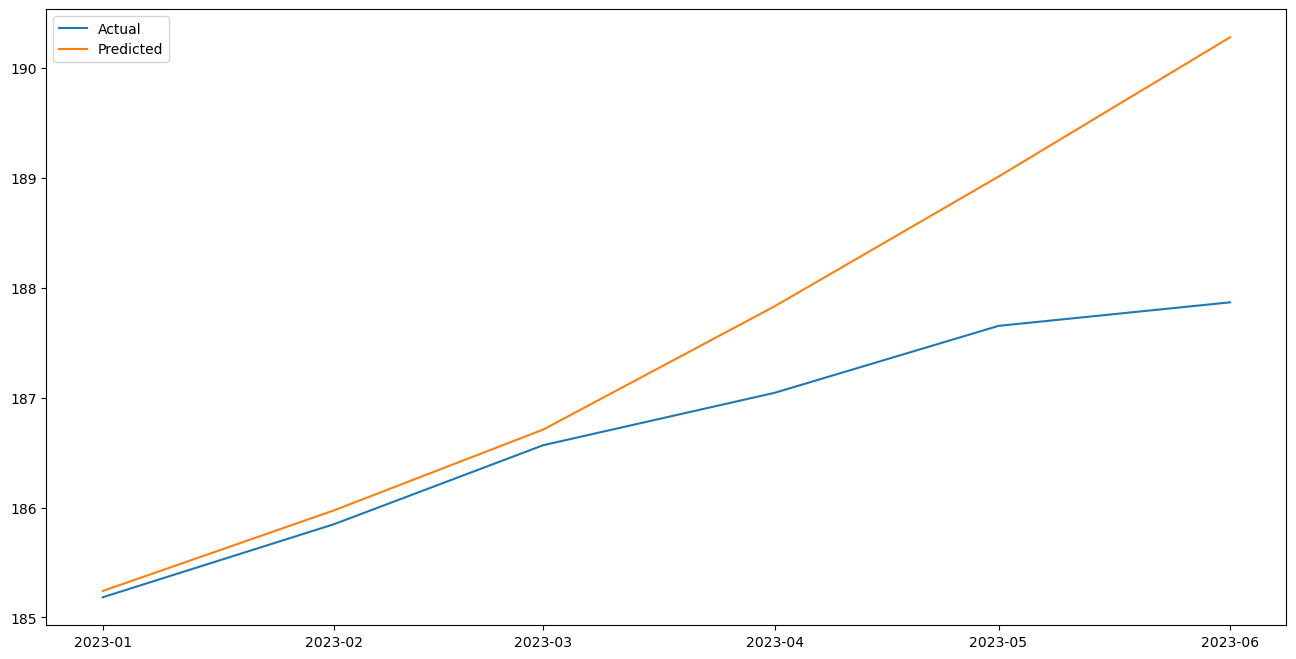

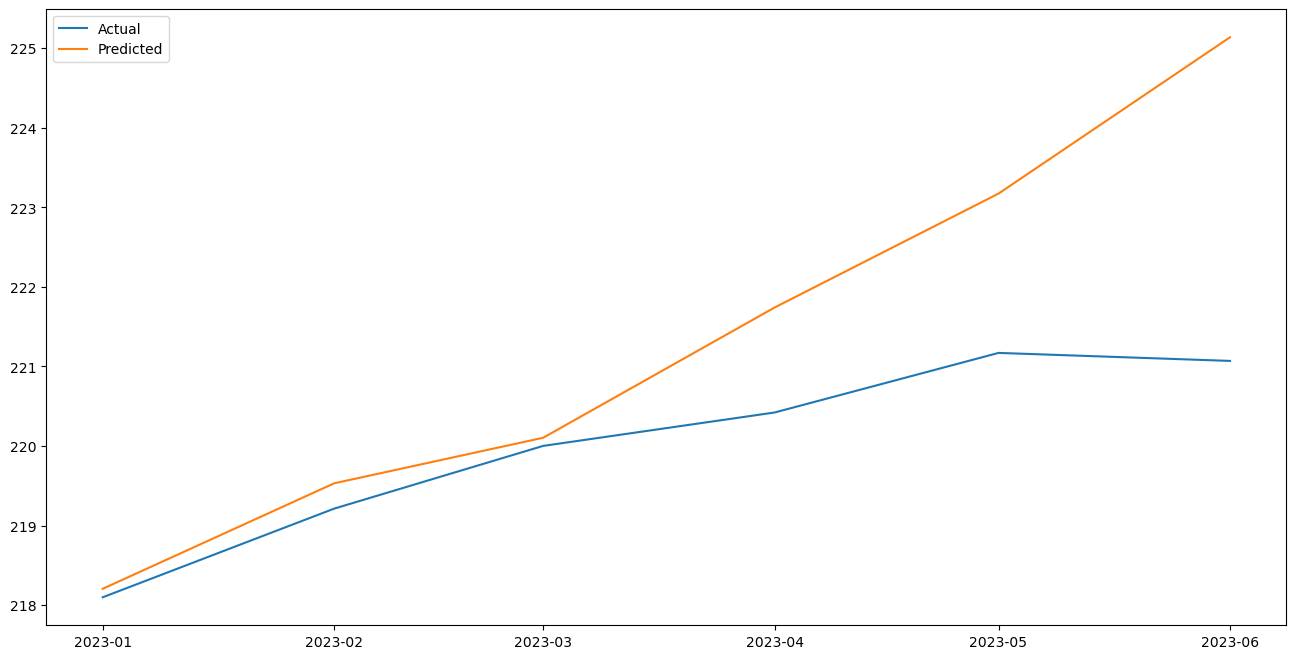

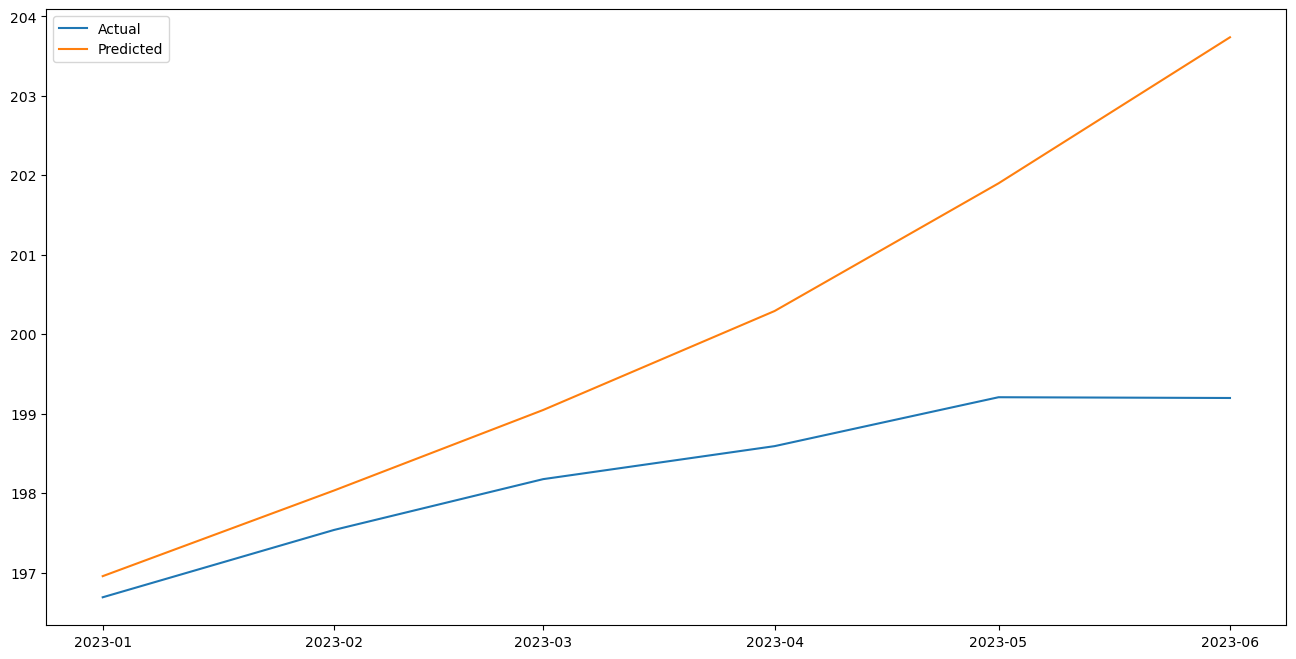

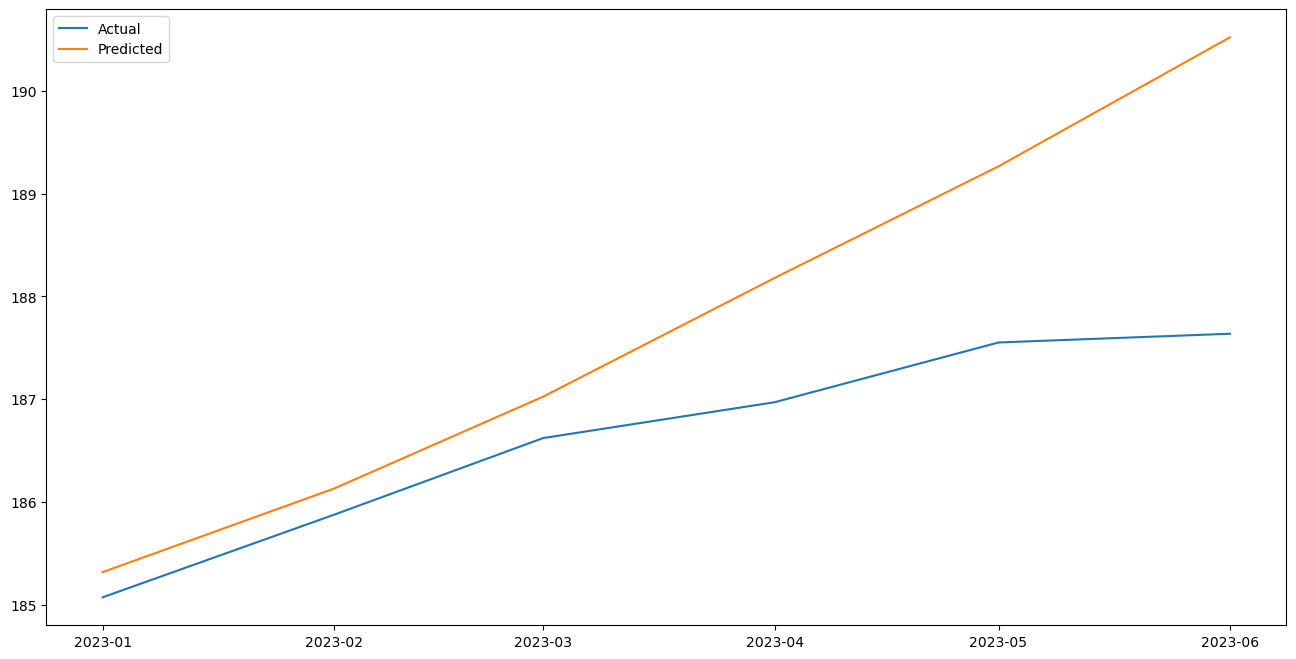

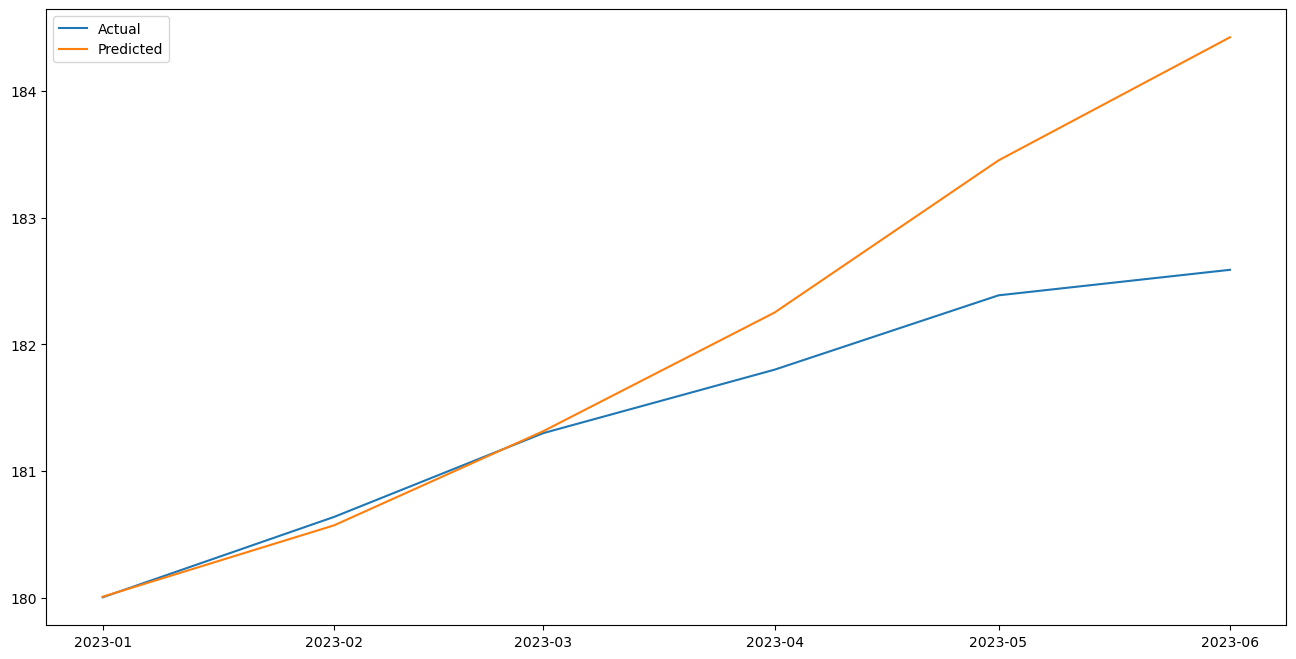

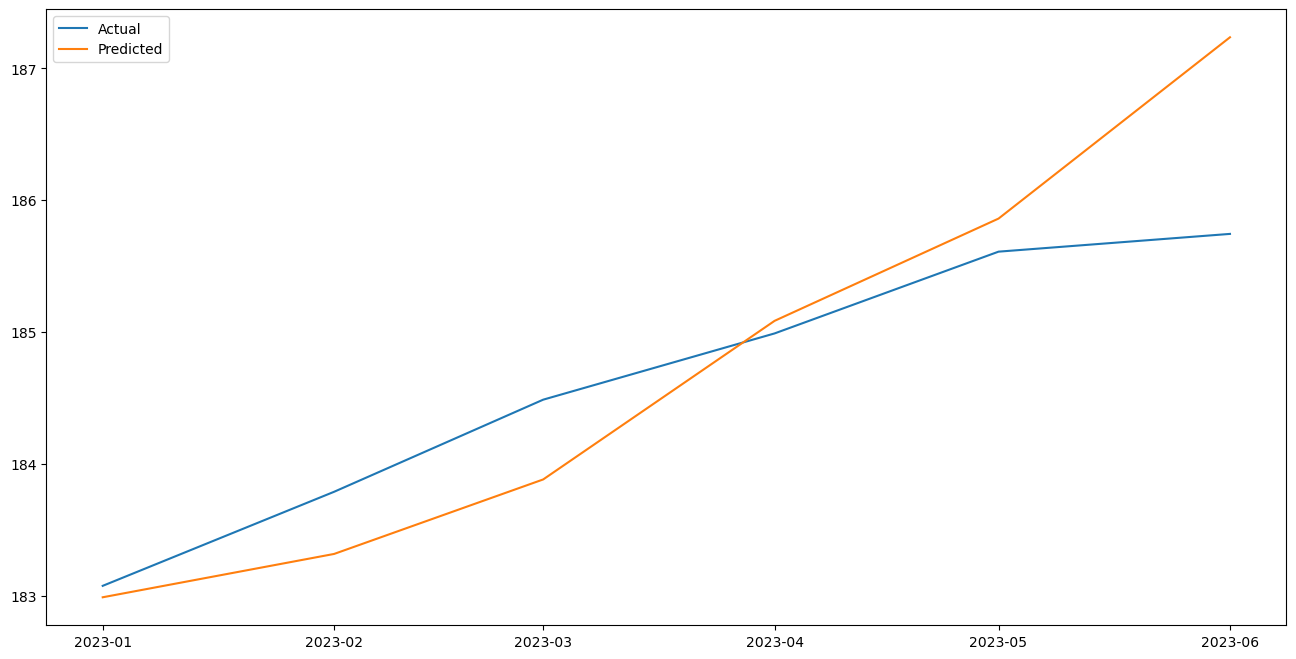

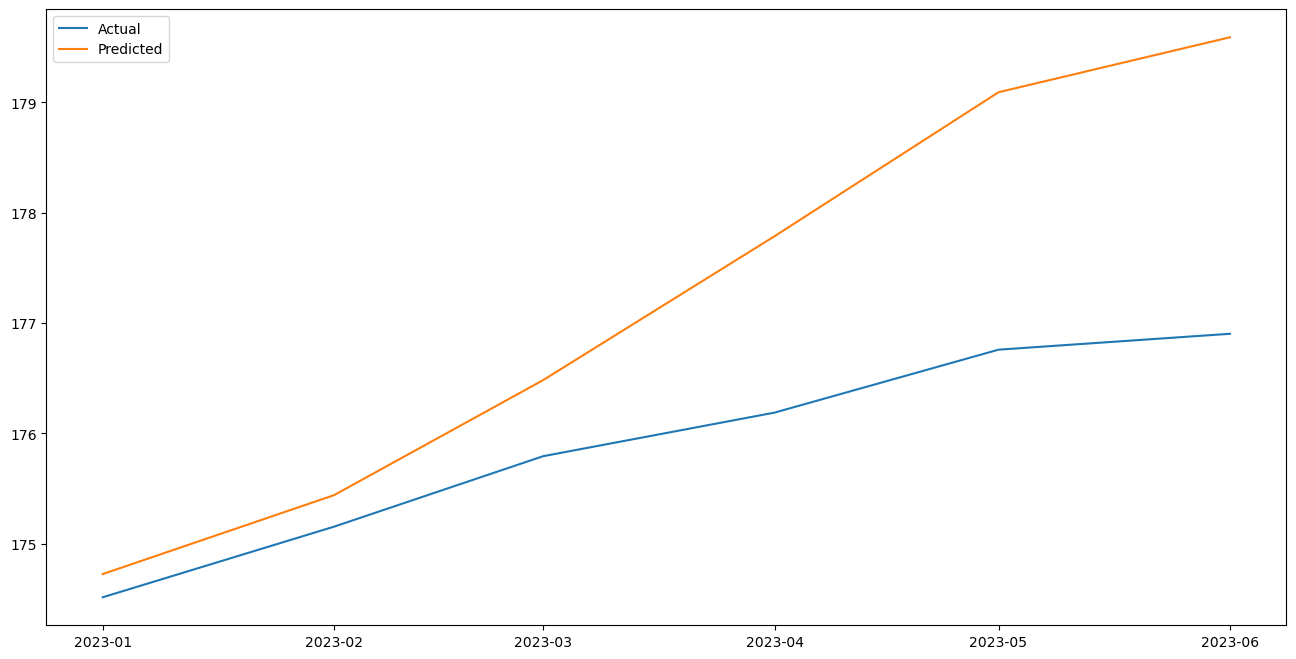

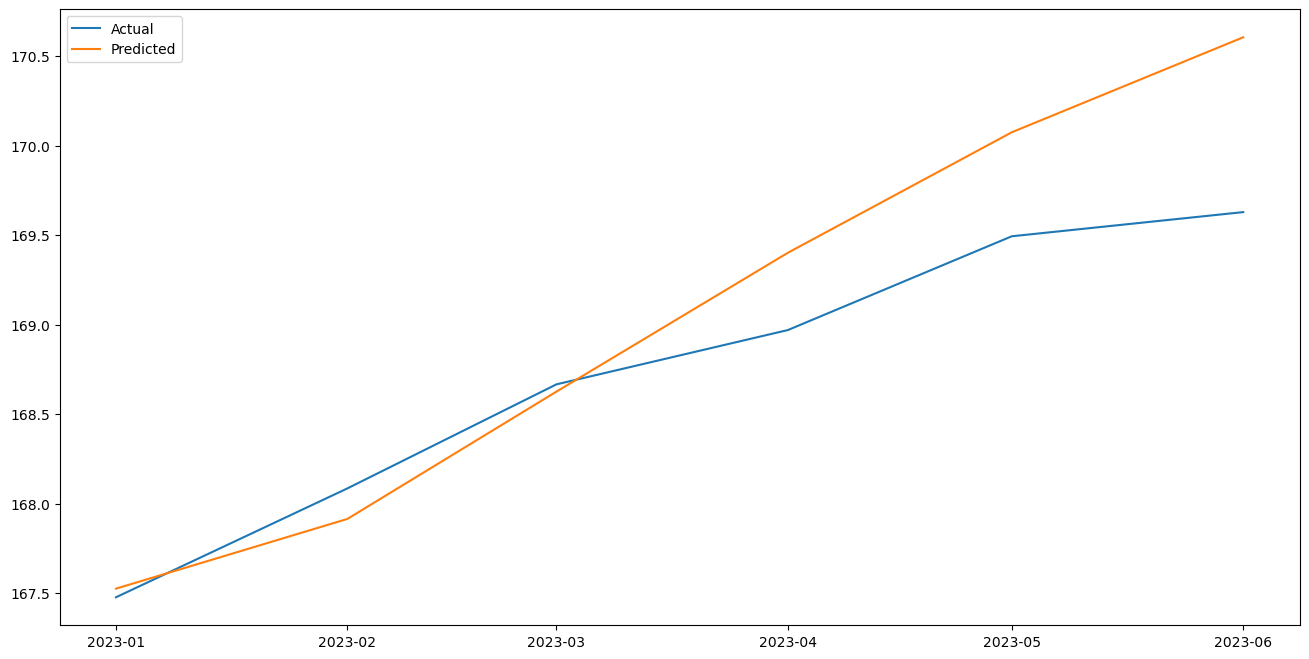

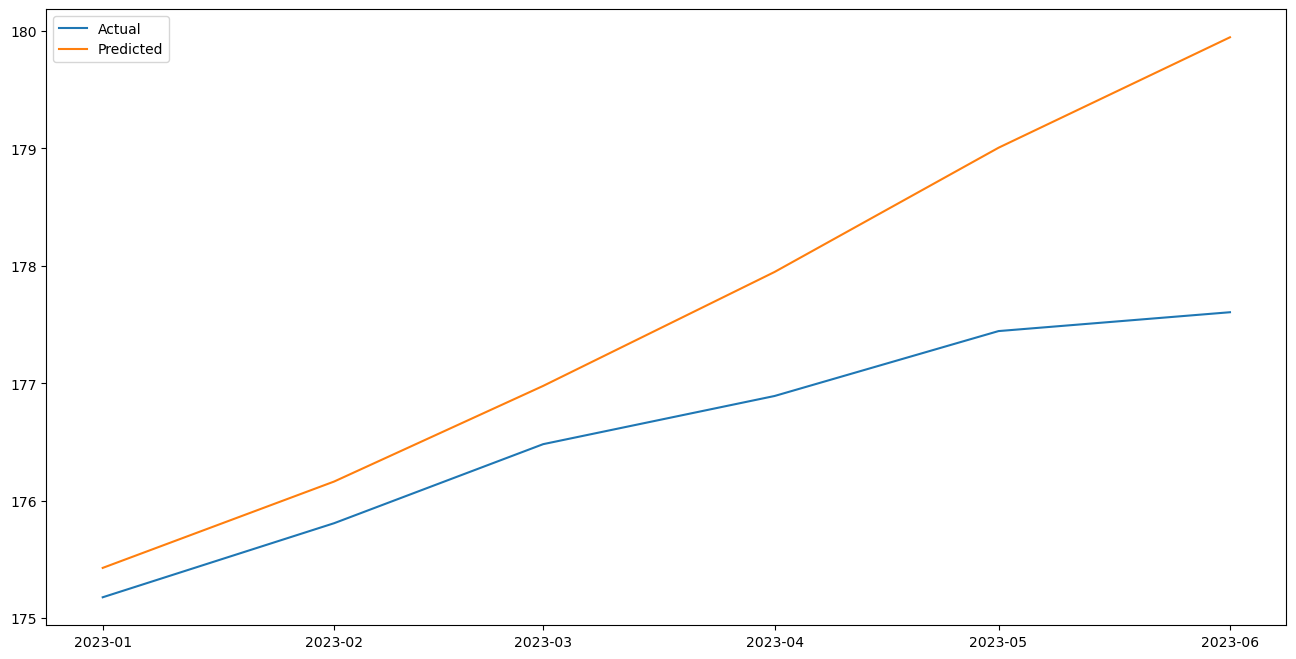

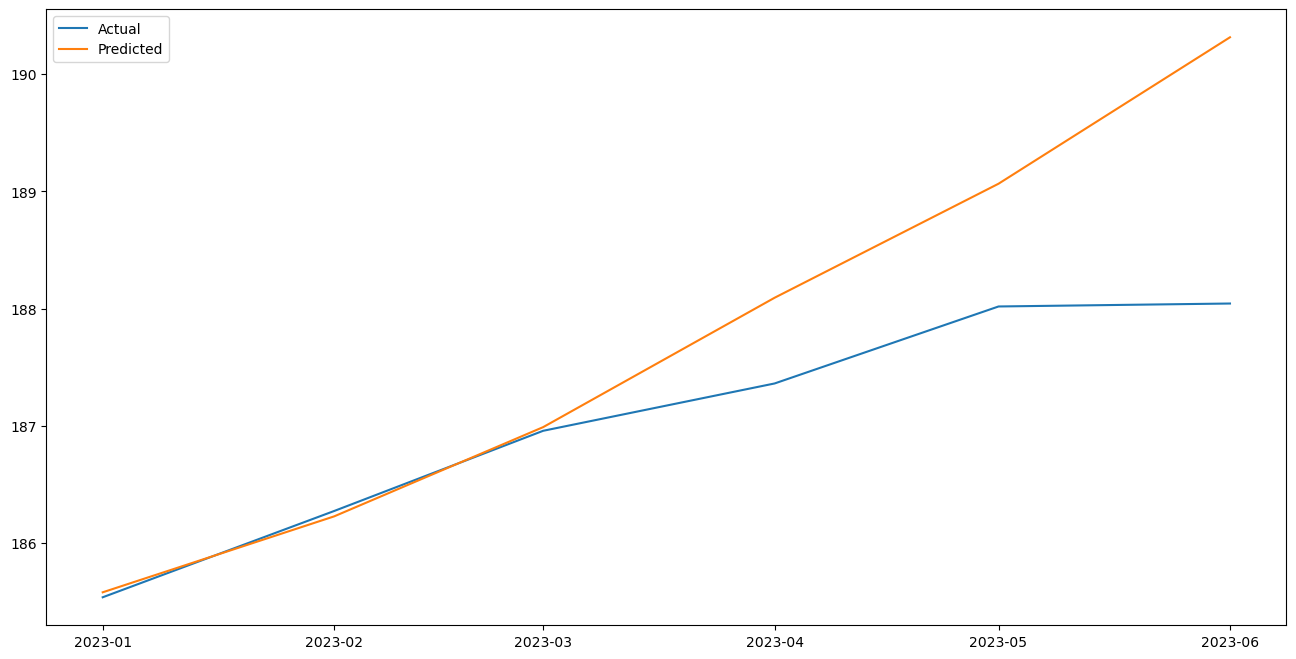

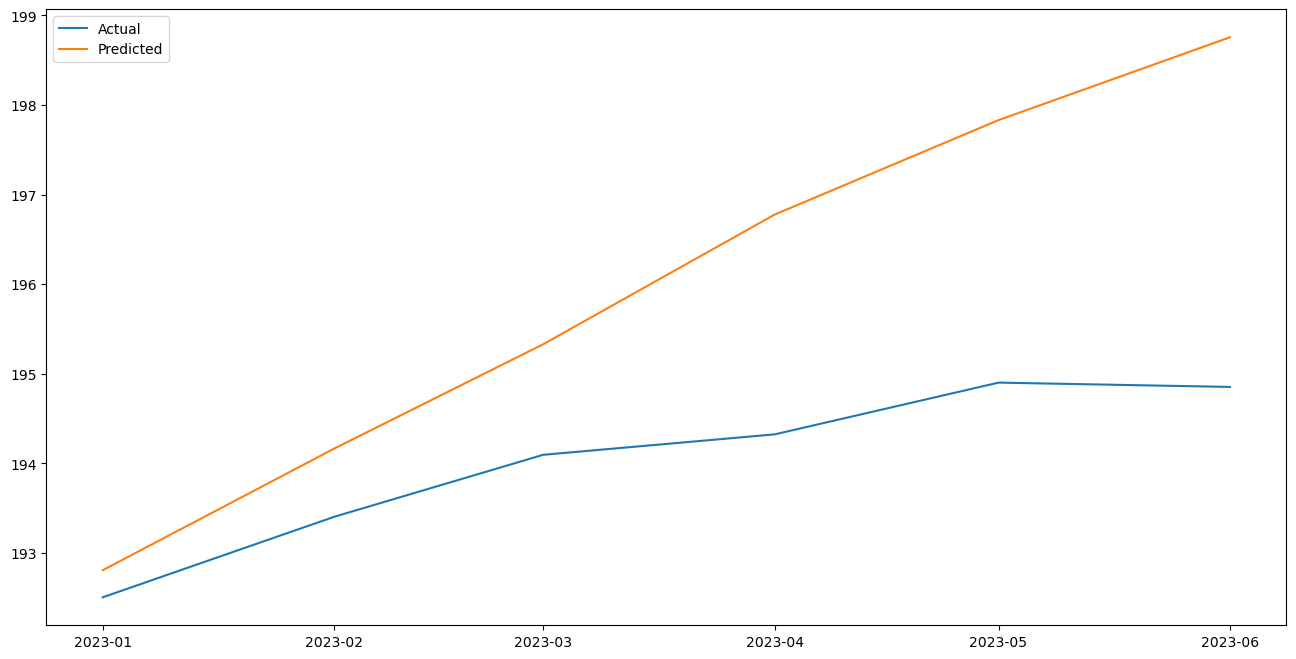

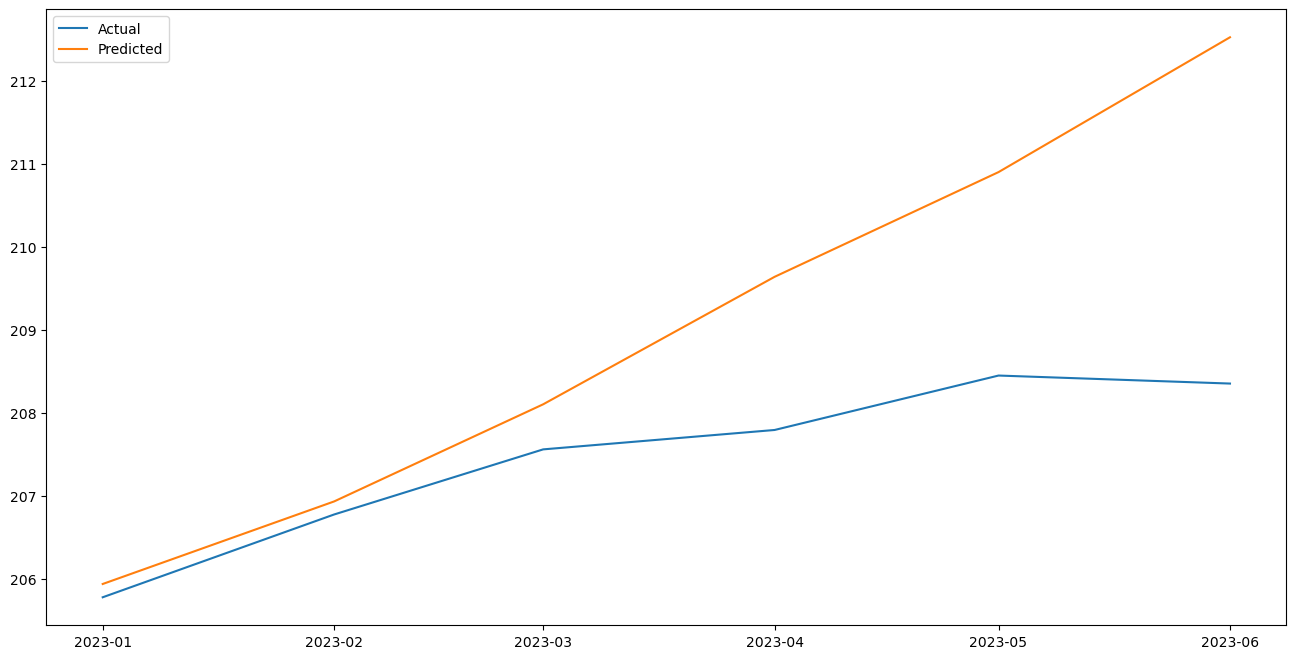

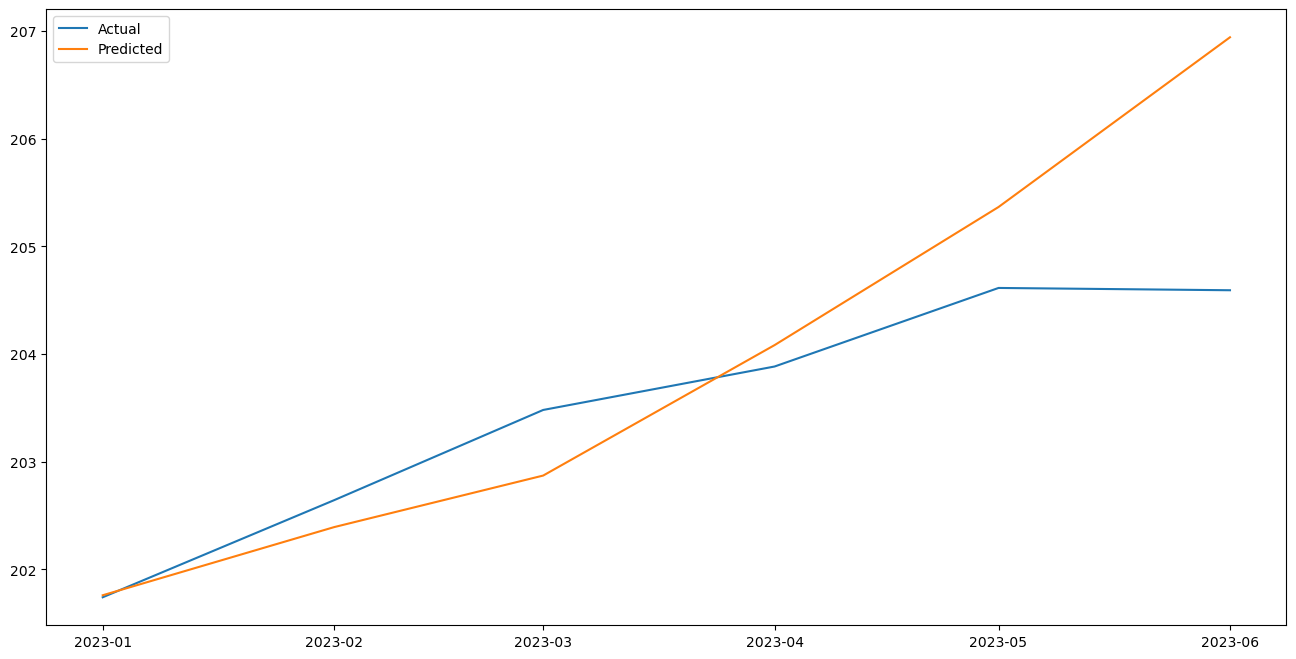

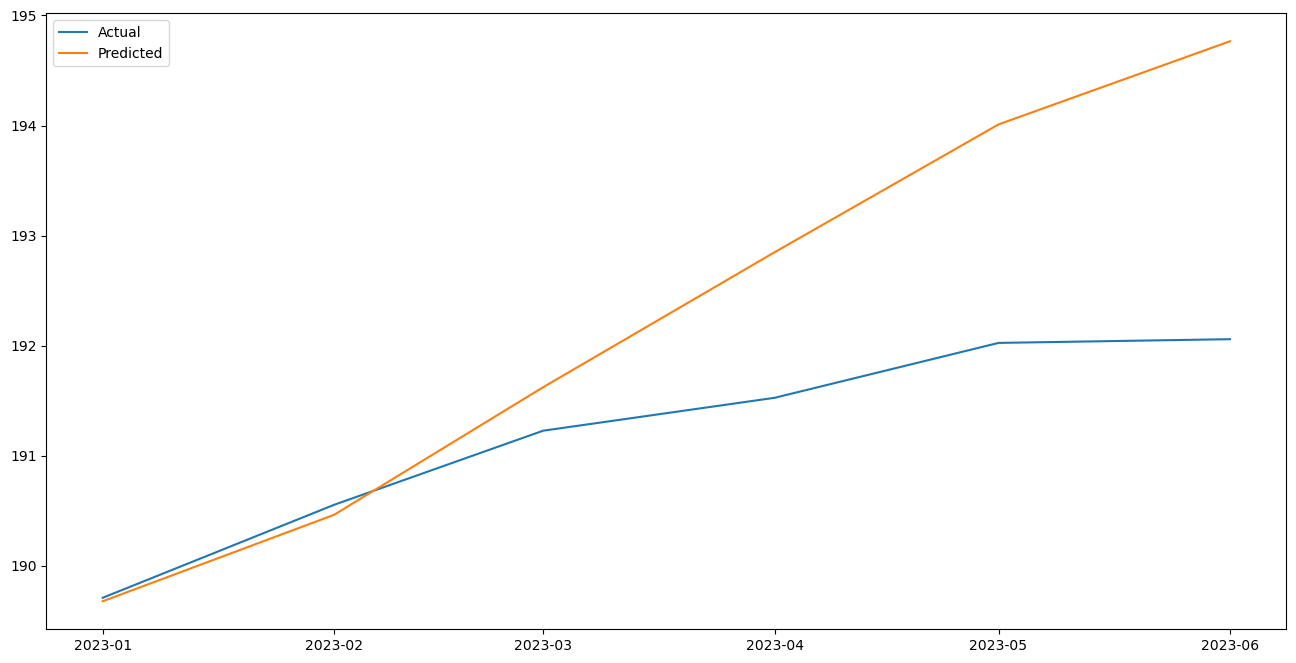

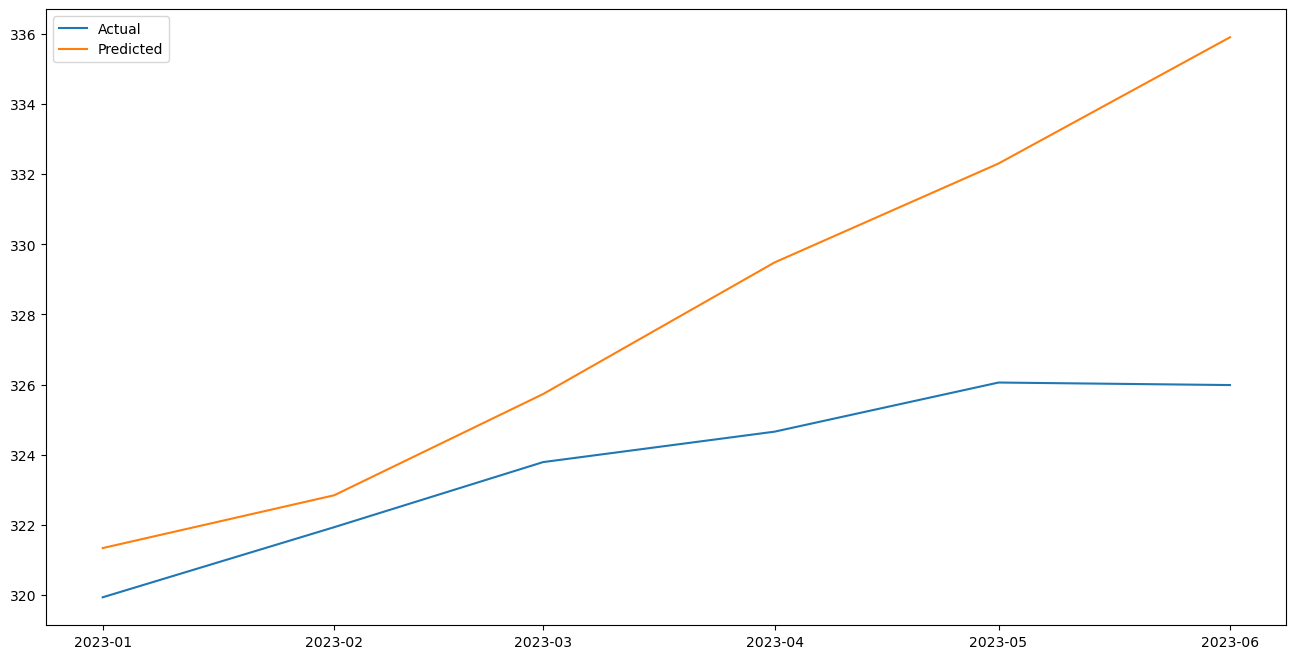

In [284]:
for zipcode in atl_df['zipcode'].unique():
    plt.plot(y_true_dict[zipcode], label='Actual')
    plt.plot(y_pred_dict[zipcode], label='Predicted')
    plt.legend()
    plt.show()

In [296]:
list(forecast_dict.keys())

[30002,
 30311,
 30310,
 30309,
 30308,
 30307,
 30306,
 30305,
 30303,
 30297,
 30296,
 30274,
 30236,
 30084,
 30083,
 30082,
 30080,
 30067,
 30062,
 30060,
 30035,
 30034,
 30033,
 30032,
 30312,
 30030,
 30313,
 30315,
 30360,
 30354,
 30350,
 30349,
 30346,
 30345,
 30344,
 30342,
 30341,
 30340,
 30339,
 30338,
 30337,
 30331,
 30329,
 30328,
 30327,
 30326,
 30324,
 30319,
 30318,
 30317,
 30316,
 30314,
 30021,
 30363]

TypeError: 'numpy.int64' object is not callable

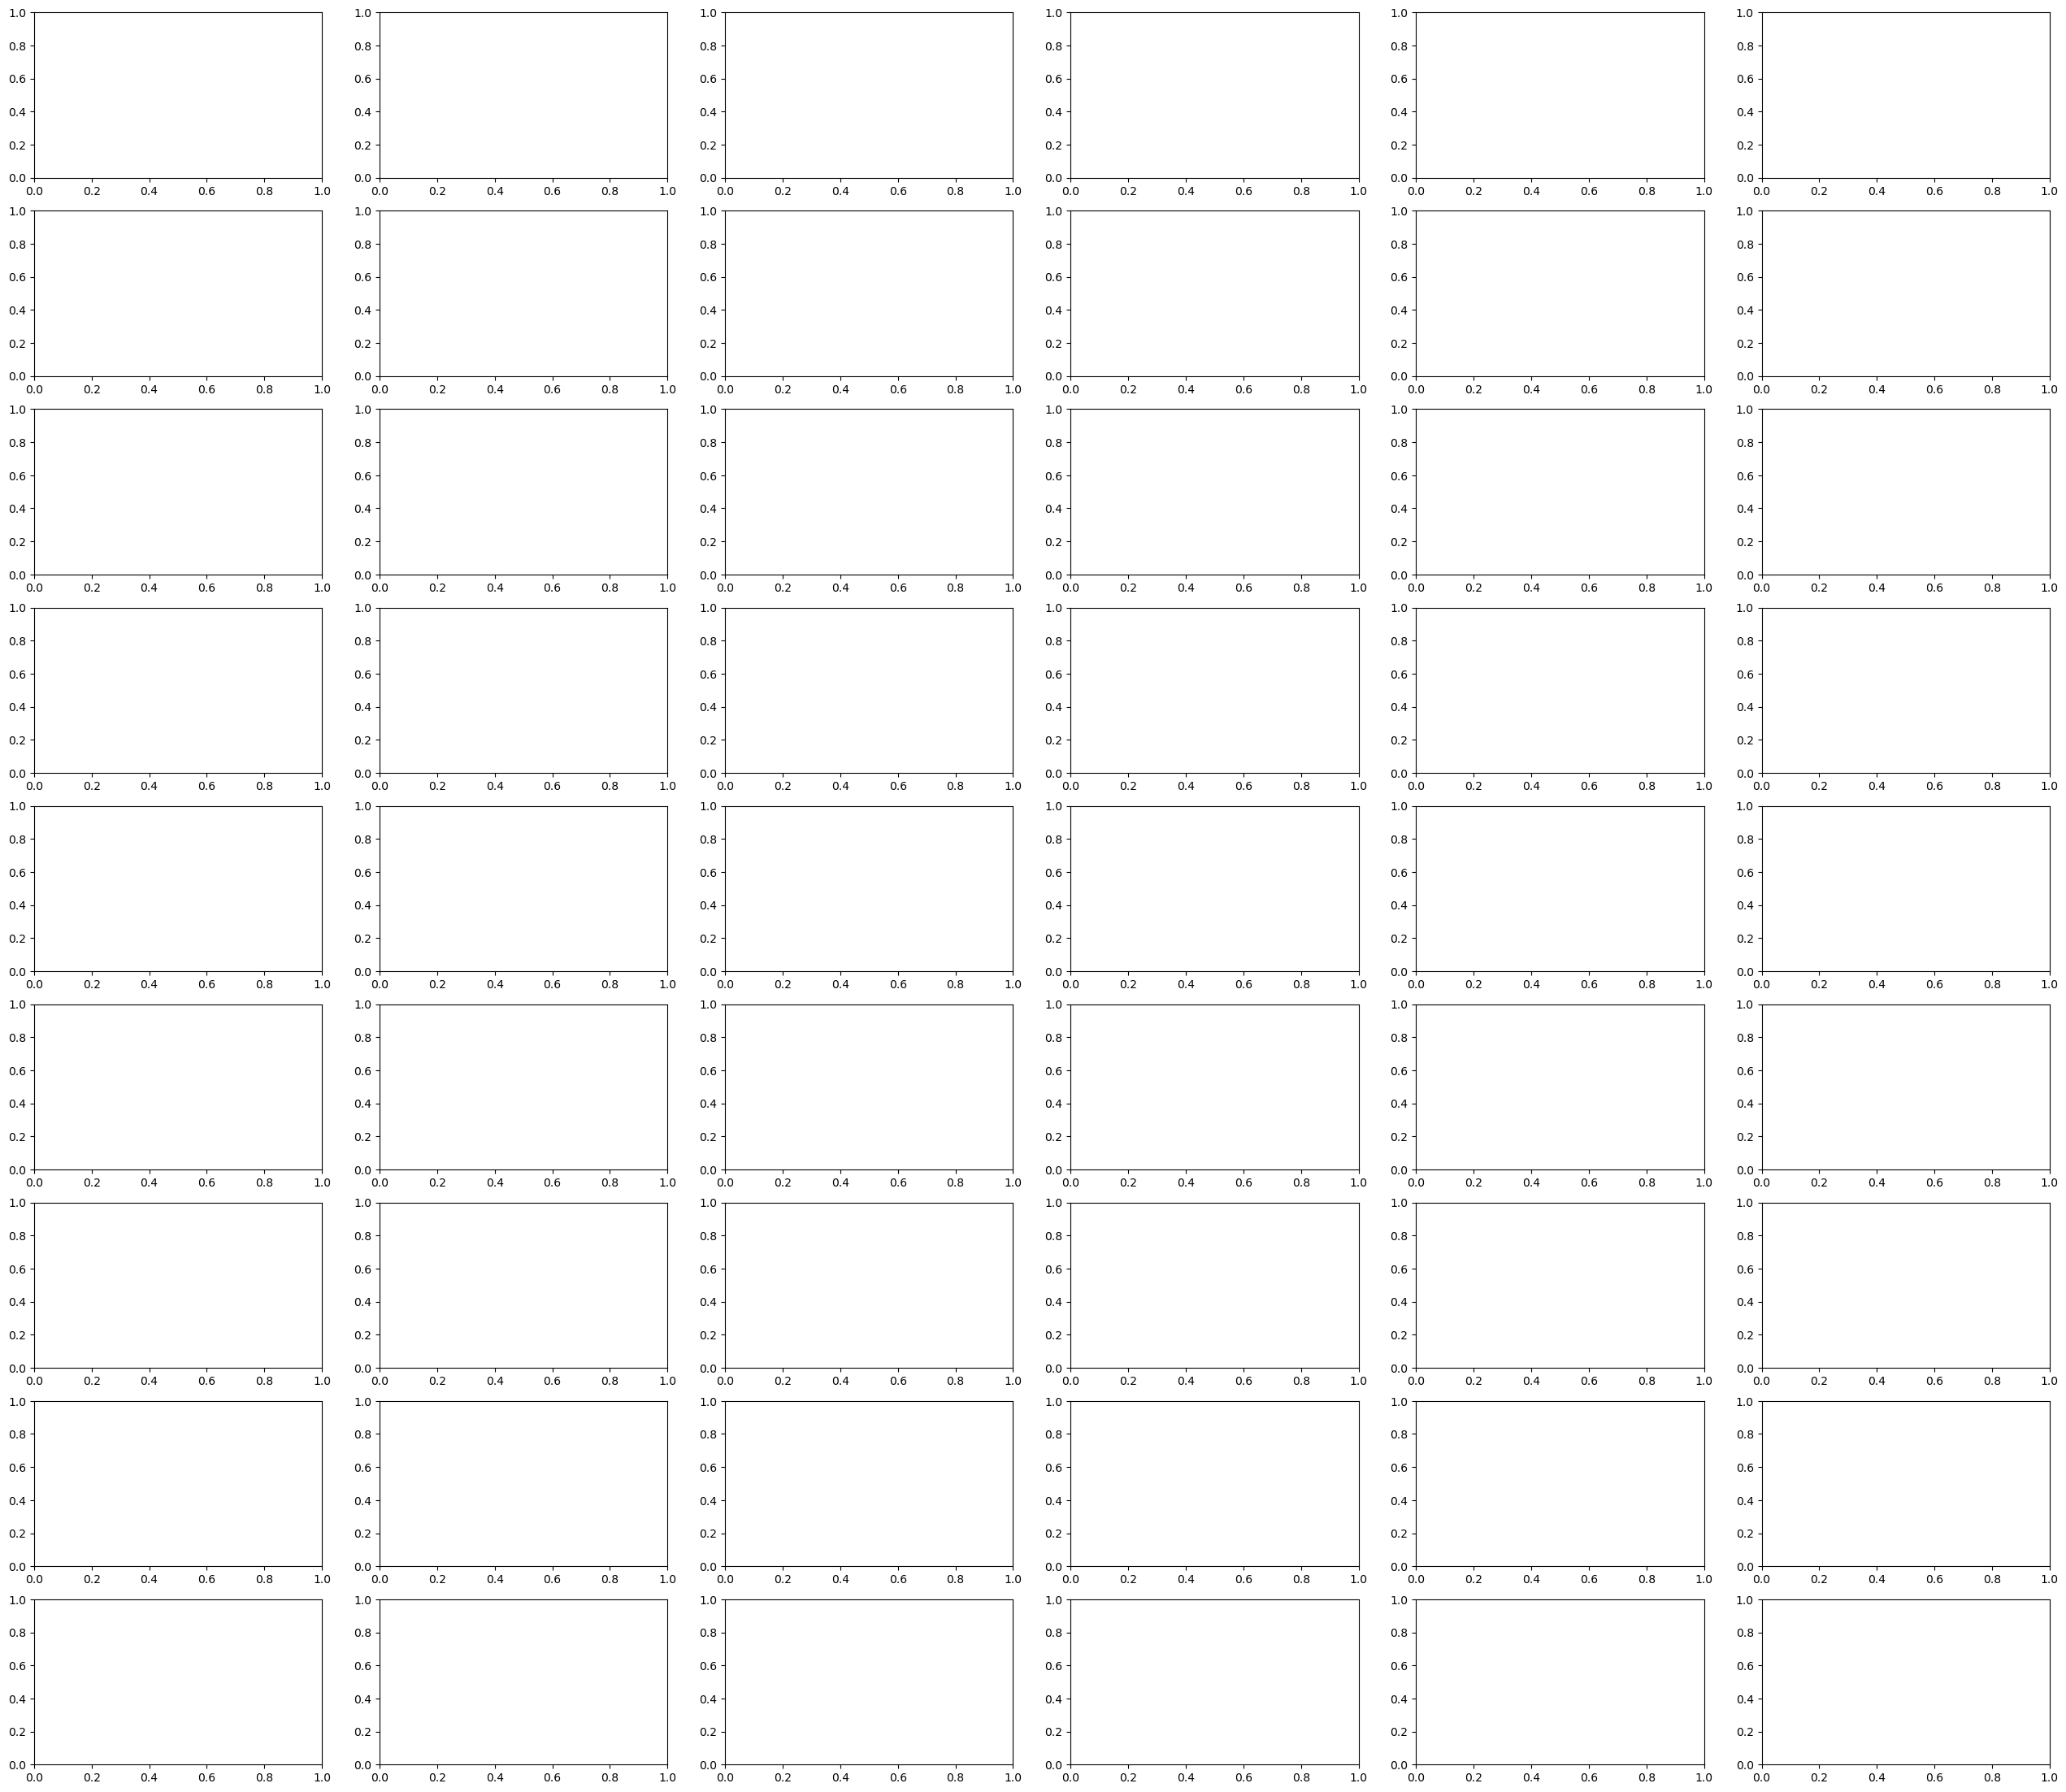

In [291]:
fig, axs = plt.subplots(9, 6, figsize = (32,28))

zip_list = list(atl_df['zipcode'].unique())

#for col, ax in zip(netflow.columns, axs.flatten()):
 #   netflow[col].plot(ax=ax)
  
# error here - need to convert keys to string??

for zipcode, ax in zip(forecast_dict.keys(), axs.flatten()):
    plt.plot(y_true_dict[zipcode], label='Actual', ax=ax)
    plt.plot(y_pred_dict[zipcode], label='Predicted', ax=ax)
    plt.legend()
    plt.show()

### Cross-Validation by Zip

08:55:44 - cmdstanpy - INFO - Chain [1] start processing
08:55:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

08:55:45 - cmdstanpy - INFO - Chain [1] start processing
08:55:46 - cmdstanpy - INFO - Chain [1] done processing
08:55:46 - cmdstanpy - INFO - Chain [1] start processing
08:55:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

08:55:47 - cmdstanpy - INFO - Chain [1] start processing
08:55:47 - cmdstanpy - INFO - Chain [1] done processing
08:55:48 - cmdstanpy - INFO - Chain [1] start processing
08:55:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

08:55:48 - cmdstanpy - INFO - Chain [1] start processing
08:55:49 - cmdstanpy - INFO - Chain [1] done processing
08:55:49 - cmdstanpy - INFO - Chain [1] start processing
08:55:49 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

08:55:49 - cmdstanpy - INFO - Chain [1] start processing
08:55:50 - cmdstanpy - INFO - Chain [1] done processing
08:55:50 - cmdstanpy - INFO - Chain [1] start processing
08:55:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

08:55:51 - cmdstanpy - INFO - Chain [1] start processing
08:55:51 - cmdstanpy - INFO - Chain [1] done processing
08:55:52 - cmdstanpy - INFO - Chain [1] start processing
08:55:52 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

08:55:52 - cmdstanpy - INFO - Chain [1] start processing
08:55:53 - cmdstanpy - INFO - Chain [1] done processing
08:55:53 - cmdstanpy - INFO - Chain [1] start processing
08:55:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

08:55:54 - cmdstanpy - INFO - Chain [1] start processing
08:55:55 - cmdstanpy - INFO - Chain [1] done processing
08:55:55 - cmdstanpy - INFO - Chain [1] start processing
08:55:55 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

08:55:55 - cmdstanpy - INFO - Chain [1] start processing
08:55:56 - cmdstanpy - INFO - Chain [1] done processing
08:55:56 - cmdstanpy - INFO - Chain [1] start processing
08:55:57 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

08:55:57 - cmdstanpy - INFO - Chain [1] start processing
08:55:57 - cmdstanpy - INFO - Chain [1] done processing
08:55:57 - cmdstanpy - INFO - Chain [1] start processing
08:55:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

08:55:58 - cmdstanpy - INFO - Chain [1] start processing
08:55:59 - cmdstanpy - INFO - Chain [1] done processing
08:55:59 - cmdstanpy - INFO - Chain [1] start processing
08:55:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

08:55:59 - cmdstanpy - INFO - Chain [1] start processing
08:56:00 - cmdstanpy - INFO - Chain [1] done processing
08:56:00 - cmdstanpy - INFO - Chain [1] start processing
08:56:01 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

08:56:01 - cmdstanpy - INFO - Chain [1] start processing
08:56:01 - cmdstanpy - INFO - Chain [1] done processing
08:56:01 - cmdstanpy - INFO - Chain [1] start processing
08:56:02 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

08:56:02 - cmdstanpy - INFO - Chain [1] start processing
08:56:02 - cmdstanpy - INFO - Chain [1] done processing
08:56:03 - cmdstanpy - INFO - Chain [1] start processing
08:56:03 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

08:56:03 - cmdstanpy - INFO - Chain [1] start processing
08:56:03 - cmdstanpy - INFO - Chain [1] done processing
08:56:04 - cmdstanpy - INFO - Chain [1] start processing
08:56:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

08:56:04 - cmdstanpy - INFO - Chain [1] start processing
08:56:05 - cmdstanpy - INFO - Chain [1] done processing
08:56:05 - cmdstanpy - INFO - Chain [1] start processing
08:56:05 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

08:56:05 - cmdstanpy - INFO - Chain [1] start processing
08:56:06 - cmdstanpy - INFO - Chain [1] done processing
08:56:06 - cmdstanpy - INFO - Chain [1] start processing
08:56:06 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

08:56:06 - cmdstanpy - INFO - Chain [1] start processing
08:56:07 - cmdstanpy - INFO - Chain [1] done processing
08:56:07 - cmdstanpy - INFO - Chain [1] start processing
08:56:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

08:56:08 - cmdstanpy - INFO - Chain [1] start processing
08:56:08 - cmdstanpy - INFO - Chain [1] done processing
08:56:08 - cmdstanpy - INFO - Chain [1] start processing
08:56:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

08:56:09 - cmdstanpy - INFO - Chain [1] start processing
08:56:09 - cmdstanpy - INFO - Chain [1] done processing
08:56:10 - cmdstanpy - INFO - Chain [1] start processing
08:56:10 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

08:56:10 - cmdstanpy - INFO - Chain [1] start processing
08:56:11 - cmdstanpy - INFO - Chain [1] done processing
08:56:11 - cmdstanpy - INFO - Chain [1] start processing
08:56:12 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

08:56:12 - cmdstanpy - INFO - Chain [1] start processing
08:56:12 - cmdstanpy - INFO - Chain [1] done processing
/Users/emmydanforth/anaconda3/lib/python3.10/site-packages/prophet/plot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(facecolor='w', figsize=figsize)
08:56:12 - cmdstanpy - INFO - Chain [1] start processing
08:56:13 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

08:56:13 - cmdstanpy - INFO - Chain [1] start processing
08:56:14 - cmdstanpy - INFO - Chain [1] done processing
08:56:14 - cmdstanpy - INFO - Chain [1] start processing
08:56:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

08:56:14 - cmdstanpy - INFO - Chain [1] start processing
08:56:15 - cmdstanpy - INFO - Chain [1] done processing
08:56:15 - cmdstanpy - INFO - Chain [1] start processing
08:56:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

08:56:15 - cmdstanpy - INFO - Chain [1] start processing
08:56:16 - cmdstanpy - INFO - Chain [1] done processing
08:56:16 - cmdstanpy - INFO - Chain [1] start processing
08:56:17 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

08:56:17 - cmdstanpy - INFO - Chain [1] start processing
08:56:17 - cmdstanpy - INFO - Chain [1] done processing
08:56:17 - cmdstanpy - INFO - Chain [1] start processing
08:56:18 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

08:56:18 - cmdstanpy - INFO - Chain [1] start processing
08:56:18 - cmdstanpy - INFO - Chain [1] done processing
08:56:19 - cmdstanpy - INFO - Chain [1] start processing
08:56:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

08:56:19 - cmdstanpy - INFO - Chain [1] start processing
08:56:19 - cmdstanpy - INFO - Chain [1] done processing
08:56:20 - cmdstanpy - INFO - Chain [1] start processing
08:56:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

08:56:20 - cmdstanpy - INFO - Chain [1] start processing
08:56:21 - cmdstanpy - INFO - Chain [1] done processing
08:56:21 - cmdstanpy - INFO - Chain [1] start processing
08:56:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

08:56:21 - cmdstanpy - INFO - Chain [1] start processing
08:56:22 - cmdstanpy - INFO - Chain [1] done processing
08:56:22 - cmdstanpy - INFO - Chain [1] start processing
08:56:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

08:56:23 - cmdstanpy - INFO - Chain [1] start processing
08:56:23 - cmdstanpy - INFO - Chain [1] done processing
08:56:23 - cmdstanpy - INFO - Chain [1] start processing
08:56:24 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

08:56:24 - cmdstanpy - INFO - Chain [1] start processing
08:56:24 - cmdstanpy - INFO - Chain [1] done processing
08:56:25 - cmdstanpy - INFO - Chain [1] start processing
08:56:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

08:56:25 - cmdstanpy - INFO - Chain [1] start processing
08:56:26 - cmdstanpy - INFO - Chain [1] done processing
08:56:26 - cmdstanpy - INFO - Chain [1] start processing
08:56:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

08:56:26 - cmdstanpy - INFO - Chain [1] start processing
08:56:27 - cmdstanpy - INFO - Chain [1] done processing
08:56:27 - cmdstanpy - INFO - Chain [1] start processing
08:56:27 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

08:56:27 - cmdstanpy - INFO - Chain [1] start processing
08:56:28 - cmdstanpy - INFO - Chain [1] done processing
08:56:28 - cmdstanpy - INFO - Chain [1] start processing
08:56:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

08:56:29 - cmdstanpy - INFO - Chain [1] start processing
08:56:29 - cmdstanpy - INFO - Chain [1] done processing
08:56:29 - cmdstanpy - INFO - Chain [1] start processing
08:56:30 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

08:56:30 - cmdstanpy - INFO - Chain [1] start processing
08:56:30 - cmdstanpy - INFO - Chain [1] done processing
08:56:30 - cmdstanpy - INFO - Chain [1] start processing
08:56:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

08:56:31 - cmdstanpy - INFO - Chain [1] start processing
08:56:31 - cmdstanpy - INFO - Chain [1] done processing
08:56:31 - cmdstanpy - INFO - Chain [1] start processing
08:56:32 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

08:56:32 - cmdstanpy - INFO - Chain [1] start processing
08:56:32 - cmdstanpy - INFO - Chain [1] done processing
08:56:33 - cmdstanpy - INFO - Chain [1] start processing
08:56:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

08:56:33 - cmdstanpy - INFO - Chain [1] start processing
08:56:34 - cmdstanpy - INFO - Chain [1] done processing
08:56:34 - cmdstanpy - INFO - Chain [1] start processing
08:56:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

08:56:34 - cmdstanpy - INFO - Chain [1] start processing
08:56:35 - cmdstanpy - INFO - Chain [1] done processing
08:56:35 - cmdstanpy - INFO - Chain [1] start processing
08:56:36 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

08:56:36 - cmdstanpy - INFO - Chain [1] start processing
08:56:36 - cmdstanpy - INFO - Chain [1] done processing
08:56:36 - cmdstanpy - INFO - Chain [1] start processing
08:56:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

08:56:37 - cmdstanpy - INFO - Chain [1] start processing
08:56:38 - cmdstanpy - INFO - Chain [1] done processing
08:56:38 - cmdstanpy - INFO - Chain [1] start processing
08:56:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

08:56:38 - cmdstanpy - INFO - Chain [1] start processing
08:56:39 - cmdstanpy - INFO - Chain [1] done processing
08:56:39 - cmdstanpy - INFO - Chain [1] start processing
08:56:39 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

08:56:40 - cmdstanpy - INFO - Chain [1] start processing
08:56:40 - cmdstanpy - INFO - Chain [1] done processing
08:56:40 - cmdstanpy - INFO - Chain [1] start processing
08:56:41 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

08:56:41 - cmdstanpy - INFO - Chain [1] start processing
08:56:41 - cmdstanpy - INFO - Chain [1] done processing
08:56:41 - cmdstanpy - INFO - Chain [1] start processing
08:56:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

08:56:42 - cmdstanpy - INFO - Chain [1] start processing
08:56:43 - cmdstanpy - INFO - Chain [1] done processing
08:56:43 - cmdstanpy - INFO - Chain [1] start processing
08:56:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

08:56:43 - cmdstanpy - INFO - Chain [1] start processing
08:56:44 - cmdstanpy - INFO - Chain [1] done processing
08:56:44 - cmdstanpy - INFO - Chain [1] start processing
08:56:44 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

08:56:44 - cmdstanpy - INFO - Chain [1] start processing
08:56:45 - cmdstanpy - INFO - Chain [1] done processing
08:56:45 - cmdstanpy - INFO - Chain [1] start processing
08:56:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

08:56:45 - cmdstanpy - INFO - Chain [1] start processing
08:56:46 - cmdstanpy - INFO - Chain [1] done processing
08:56:46 - cmdstanpy - INFO - Chain [1] start processing
08:56:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

08:56:47 - cmdstanpy - INFO - Chain [1] start processing
08:56:47 - cmdstanpy - INFO - Chain [1] done processing
08:56:47 - cmdstanpy - INFO - Chain [1] start processing
08:56:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

08:56:48 - cmdstanpy - INFO - Chain [1] start processing
08:56:49 - cmdstanpy - INFO - Chain [1] done processing
08:56:49 - cmdstanpy - INFO - Chain [1] start processing
08:56:50 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

08:56:50 - cmdstanpy - INFO - Chain [1] start processing
08:56:50 - cmdstanpy - INFO - Chain [1] done processing
08:56:50 - cmdstanpy - INFO - Chain [1] start processing
08:56:51 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

08:56:51 - cmdstanpy - INFO - Chain [1] start processing
08:56:51 - cmdstanpy - INFO - Chain [1] done processing
08:56:52 - cmdstanpy - INFO - Chain [1] start processing
08:56:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1 [00:00<?, ?it/s]

08:56:53 - cmdstanpy - INFO - Chain [1] start processing
08:56:54 - cmdstanpy - INFO - Chain [1] done processing


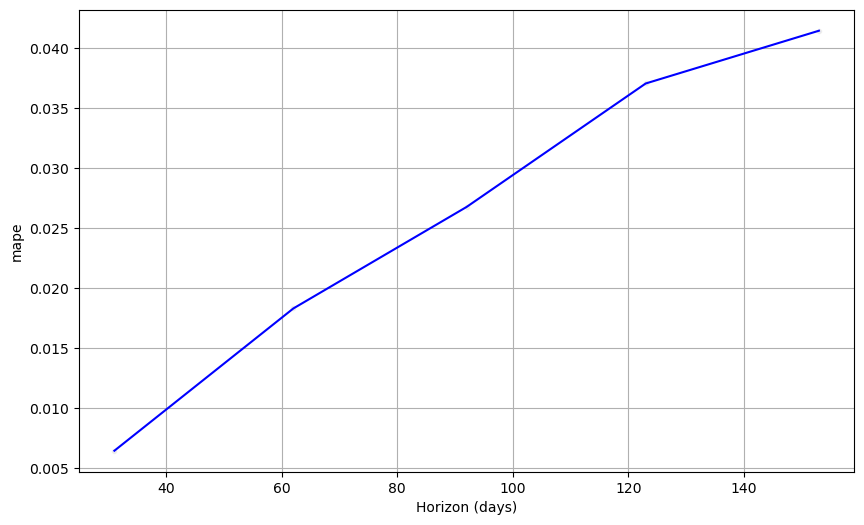

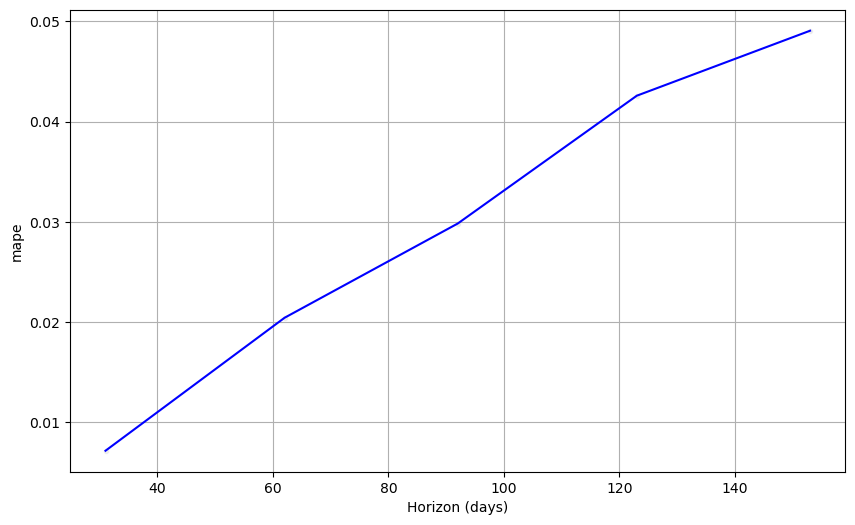

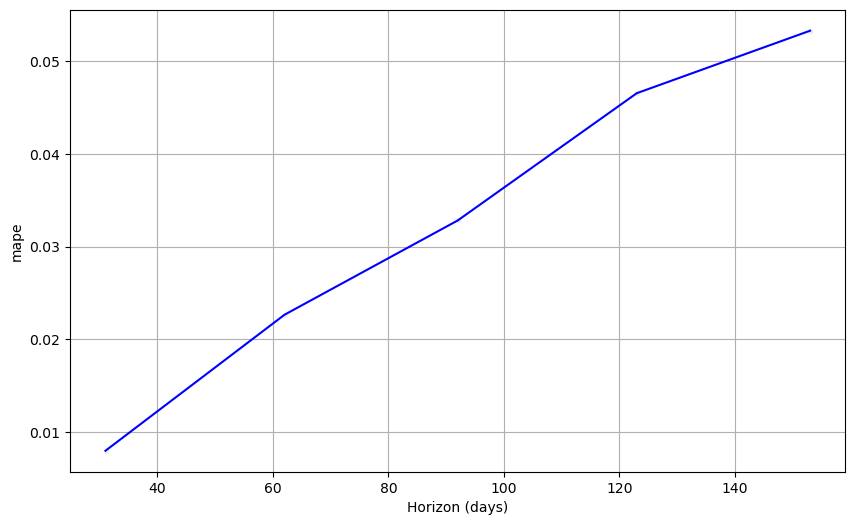

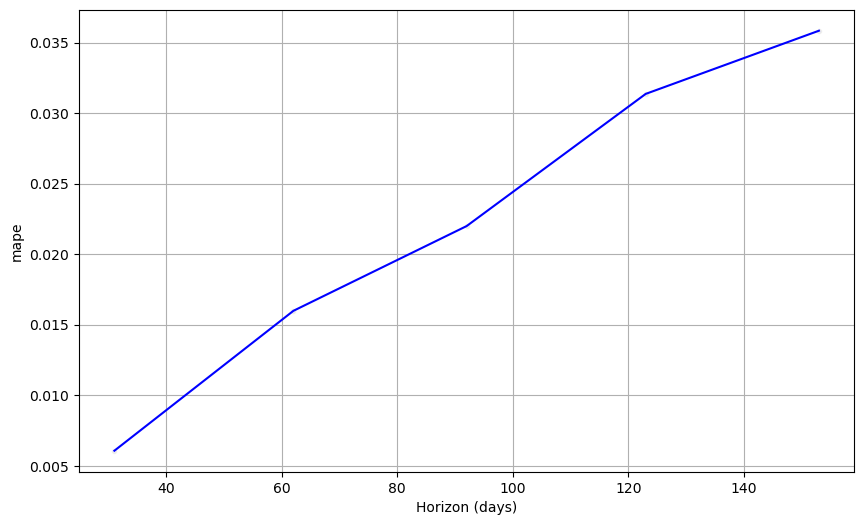

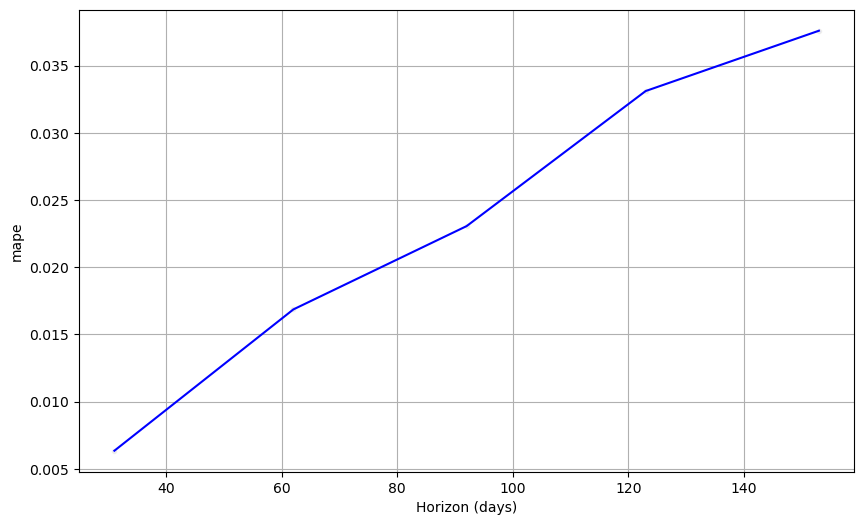

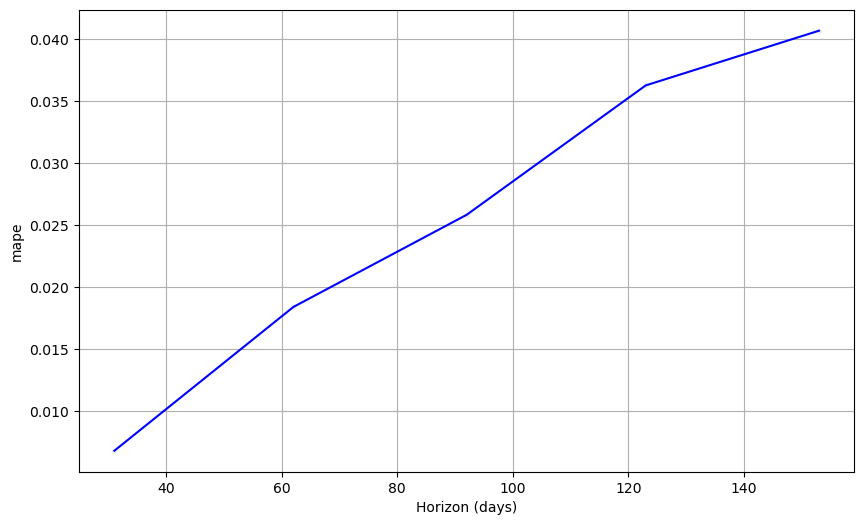

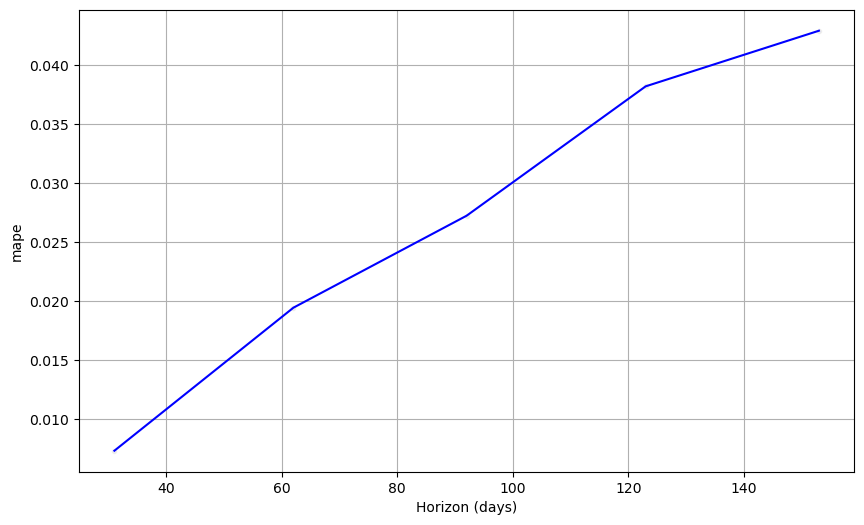

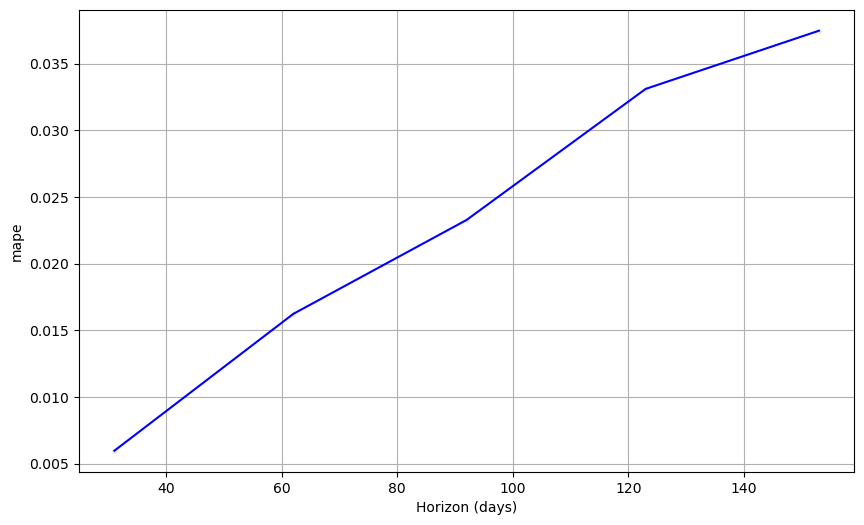

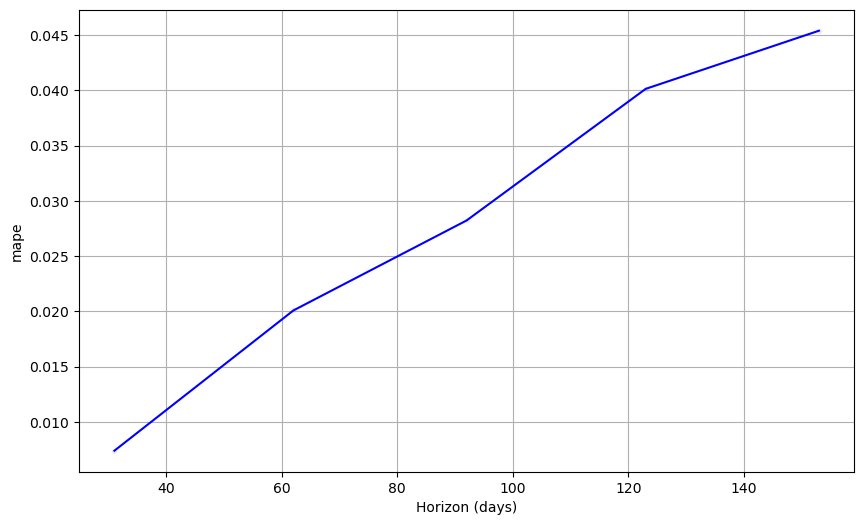

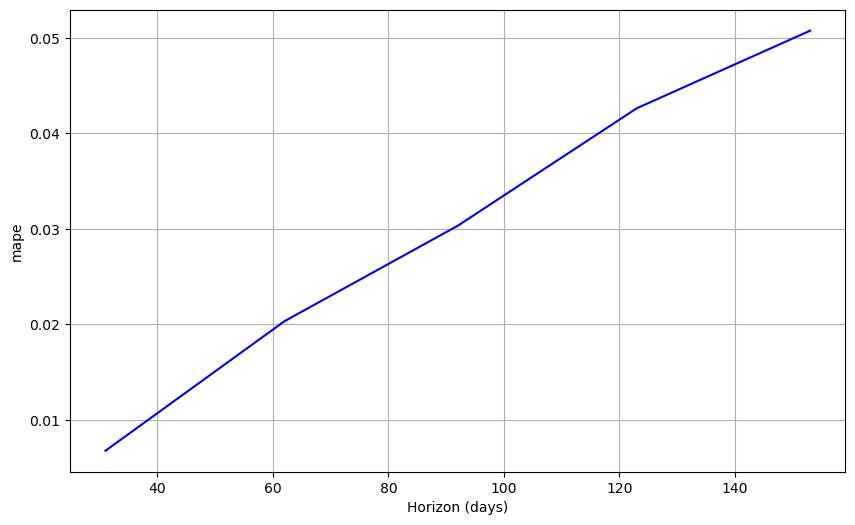

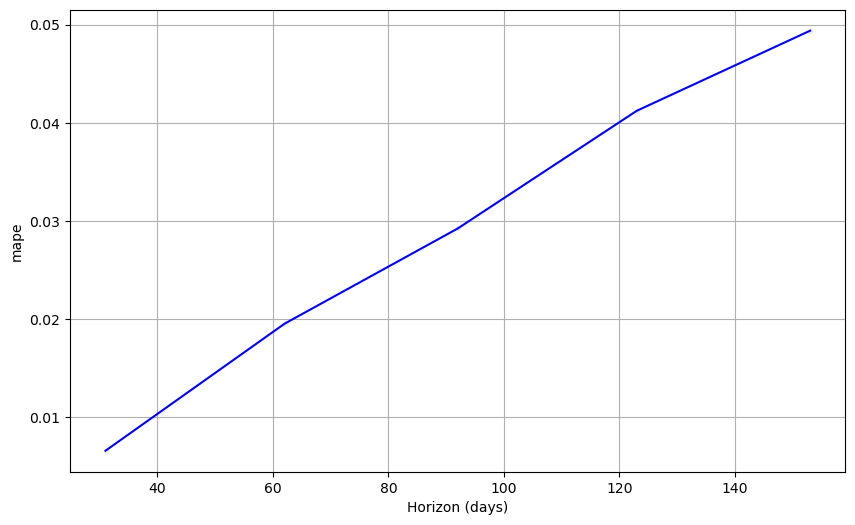

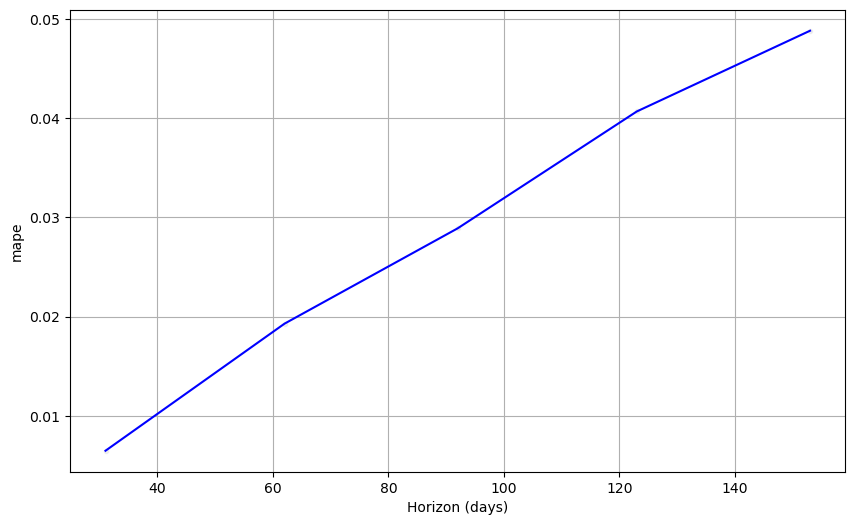

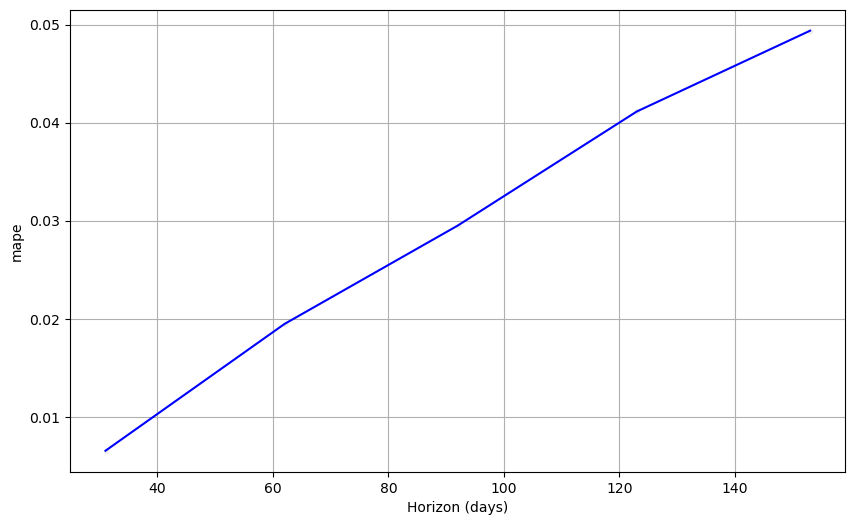

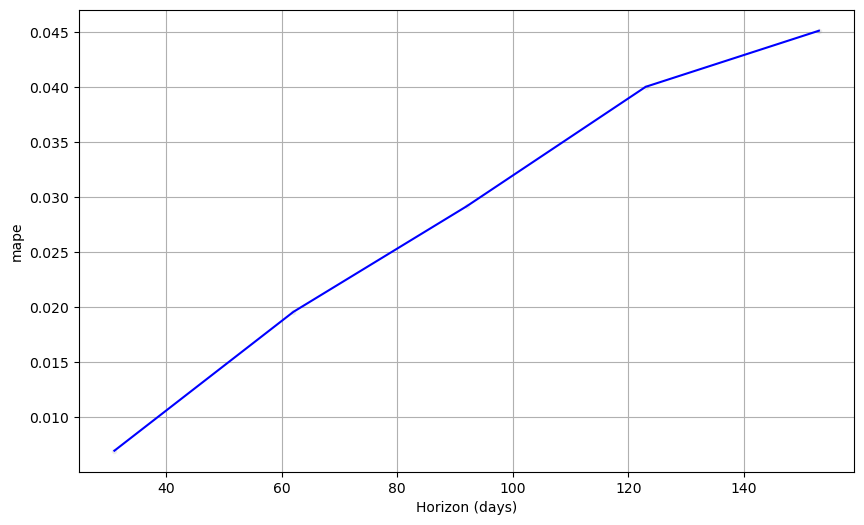

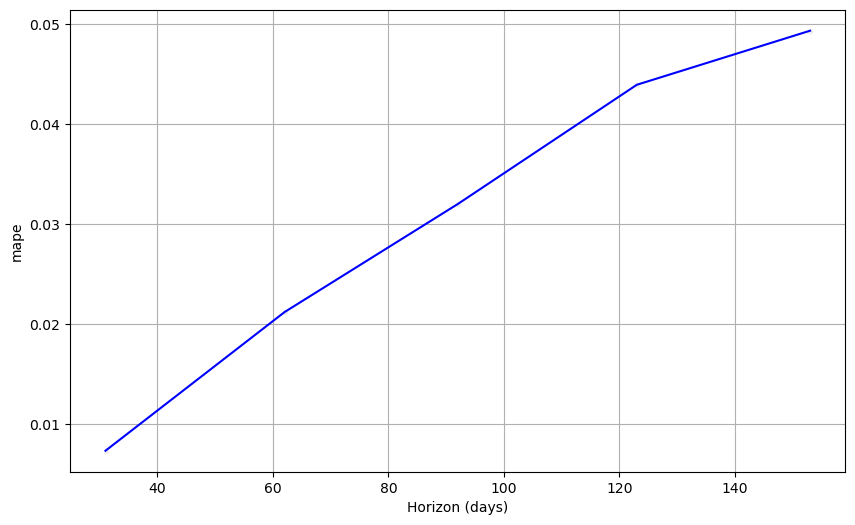

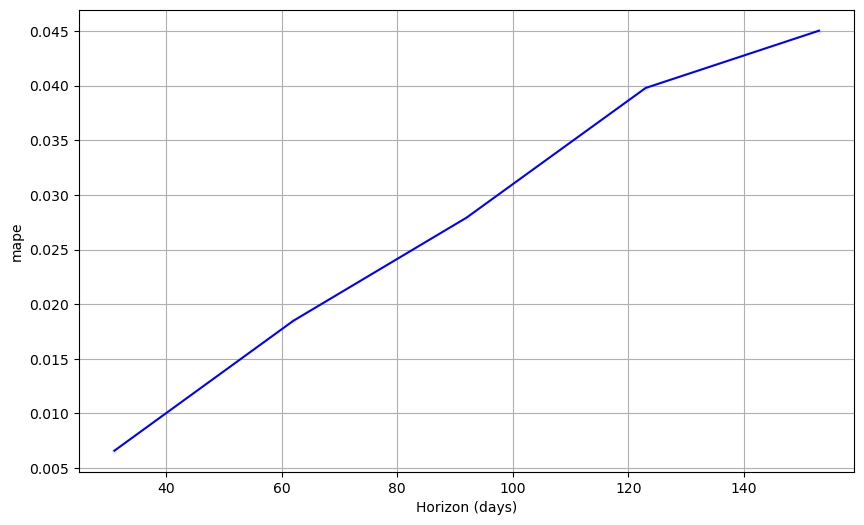

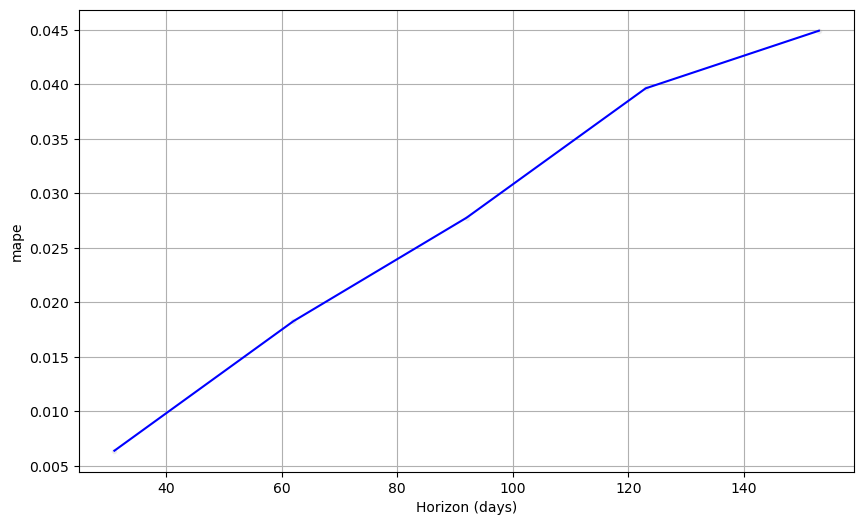

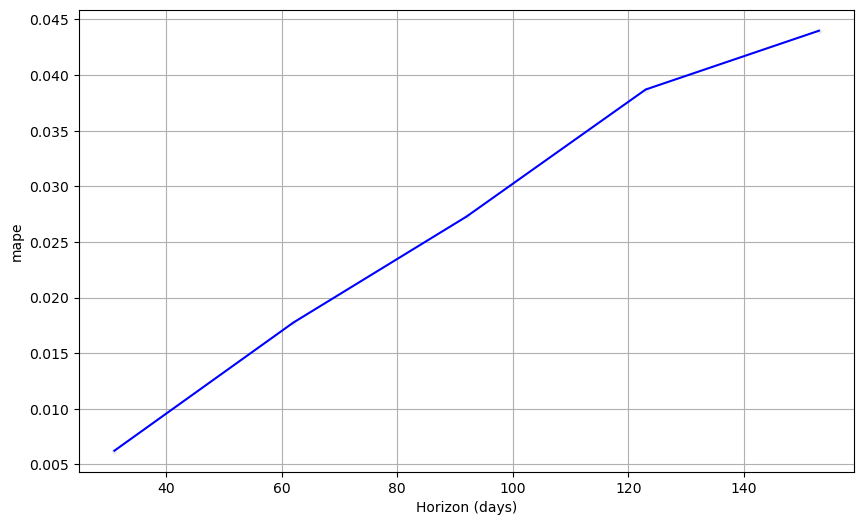

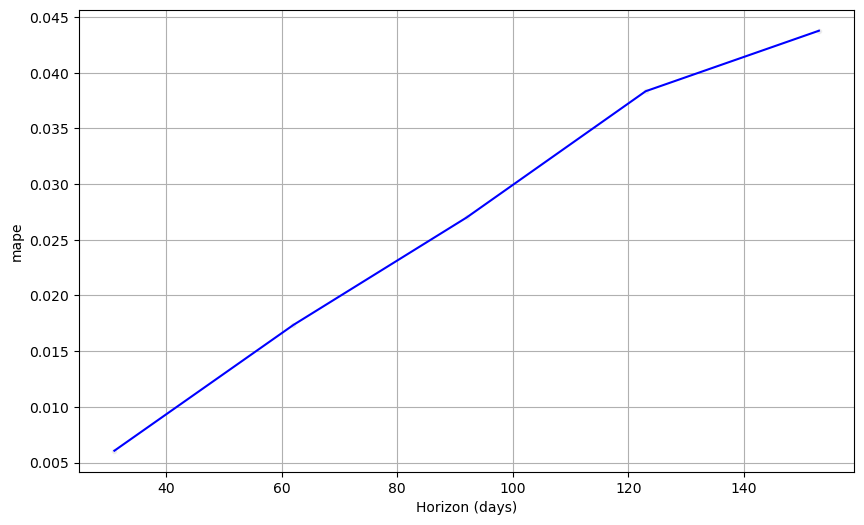

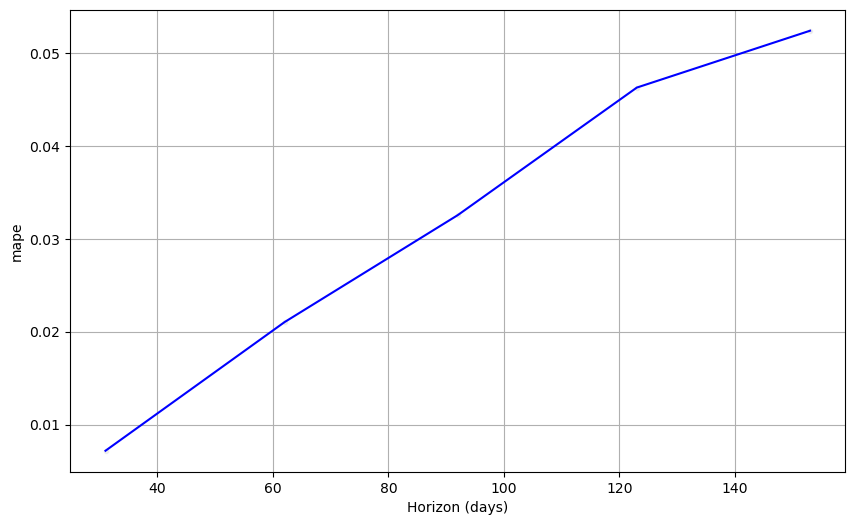

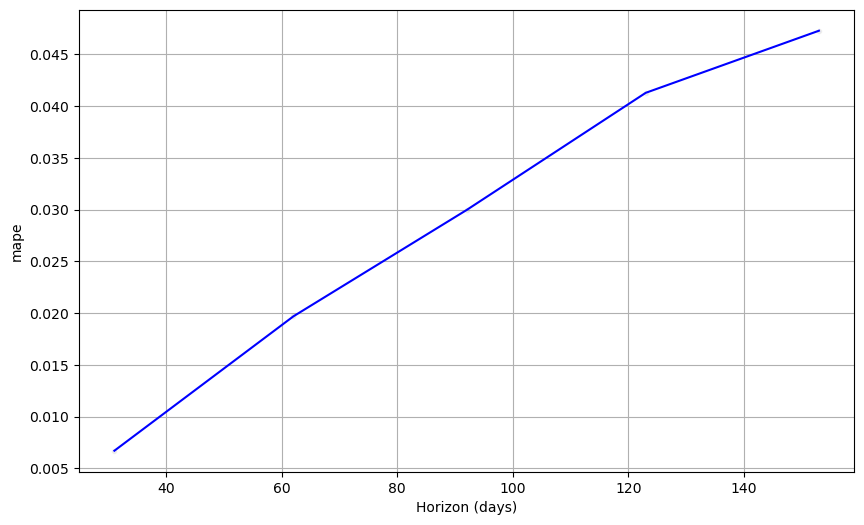

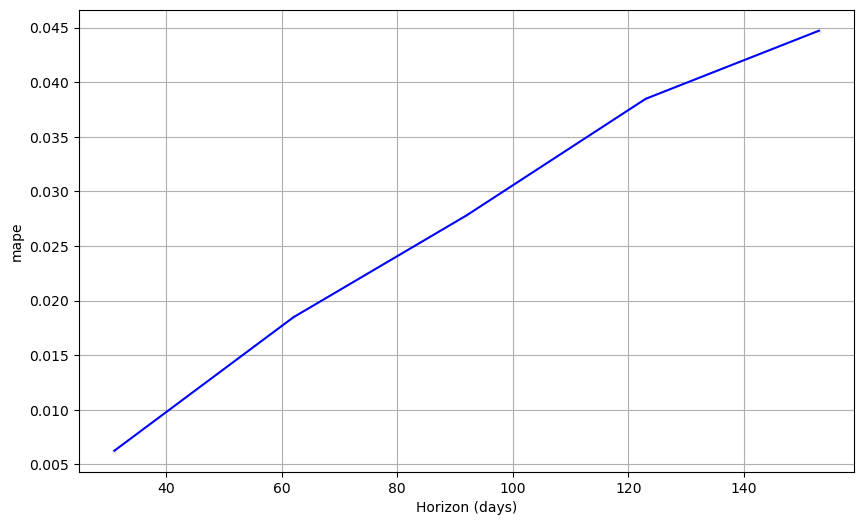

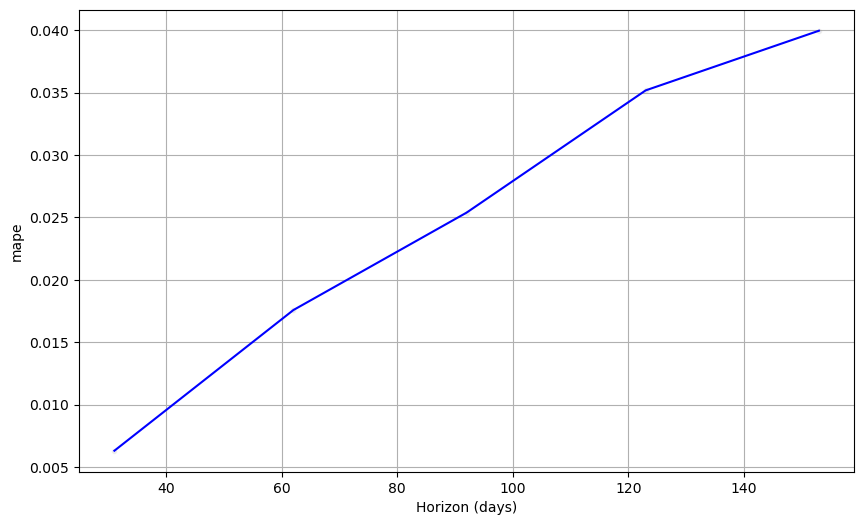

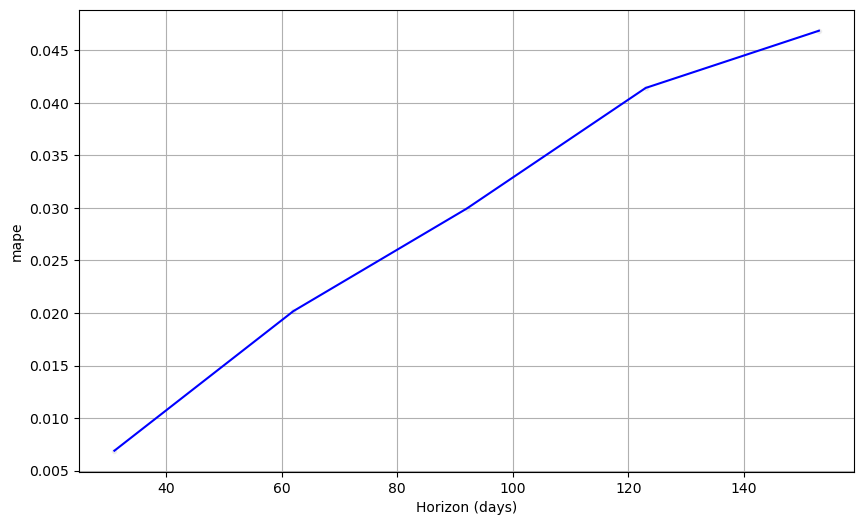

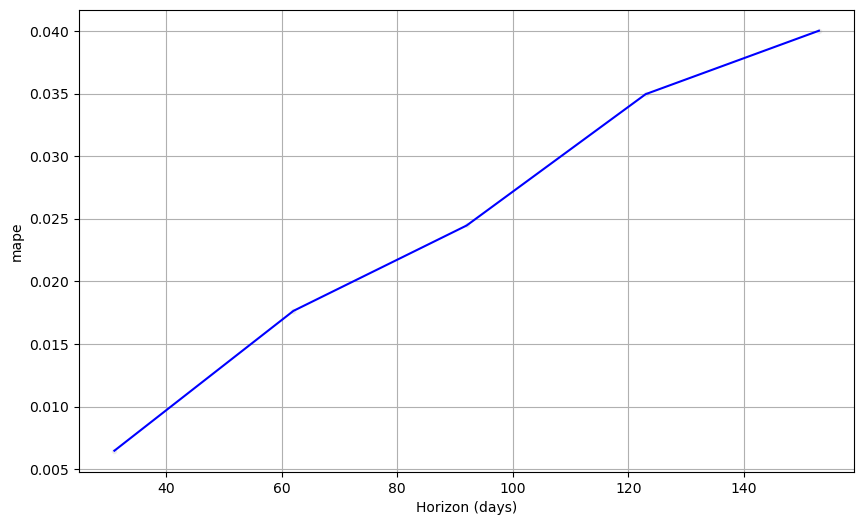

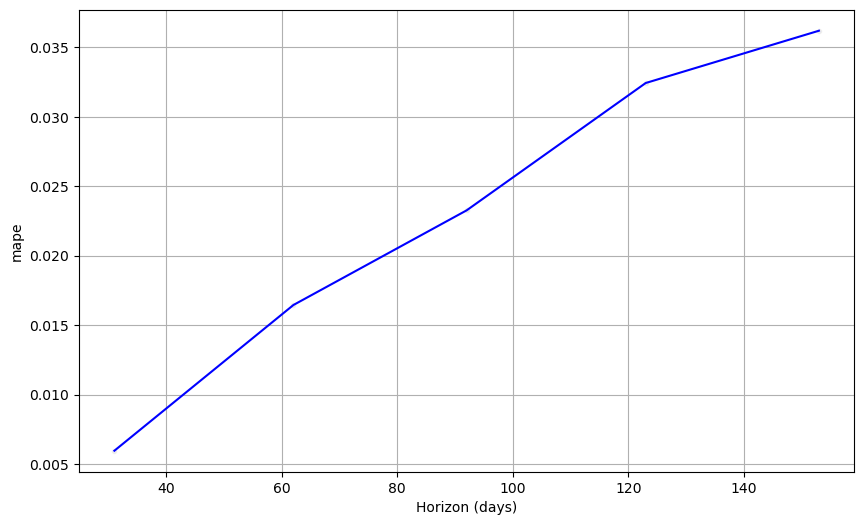

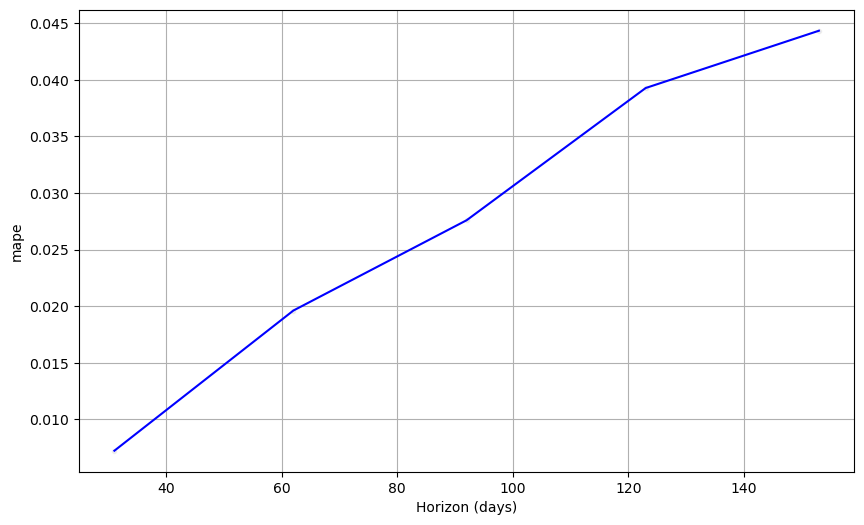

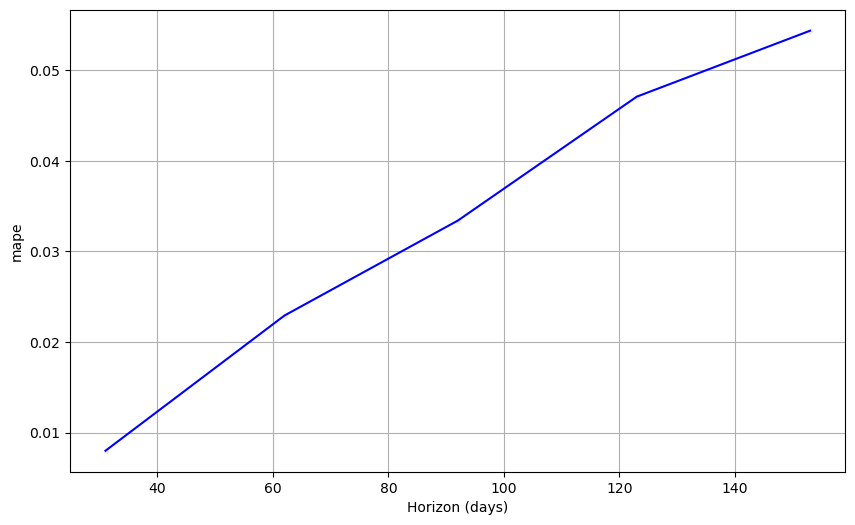

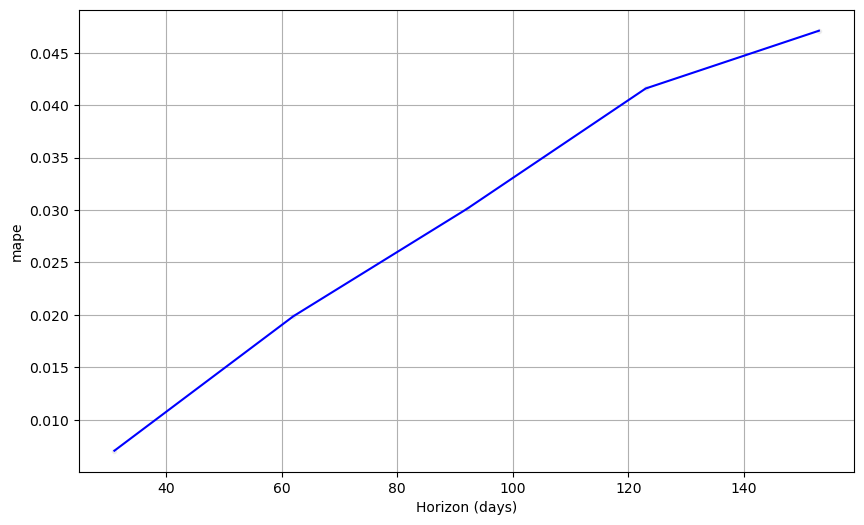

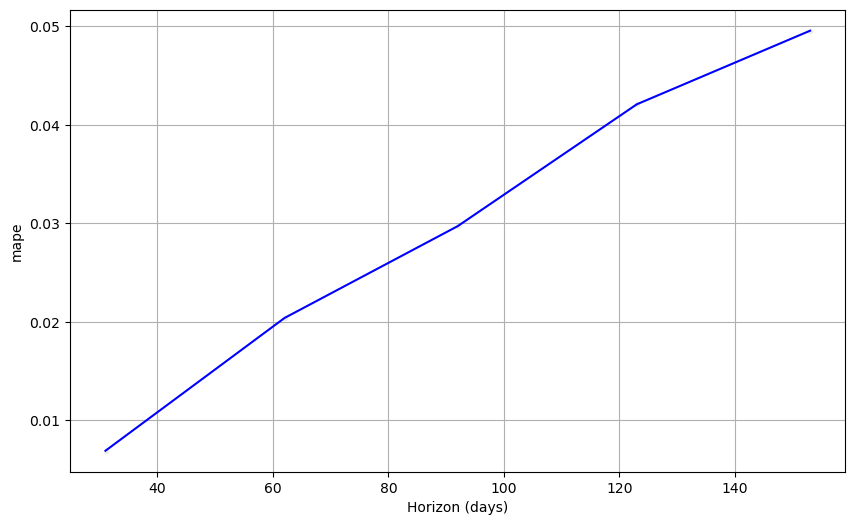

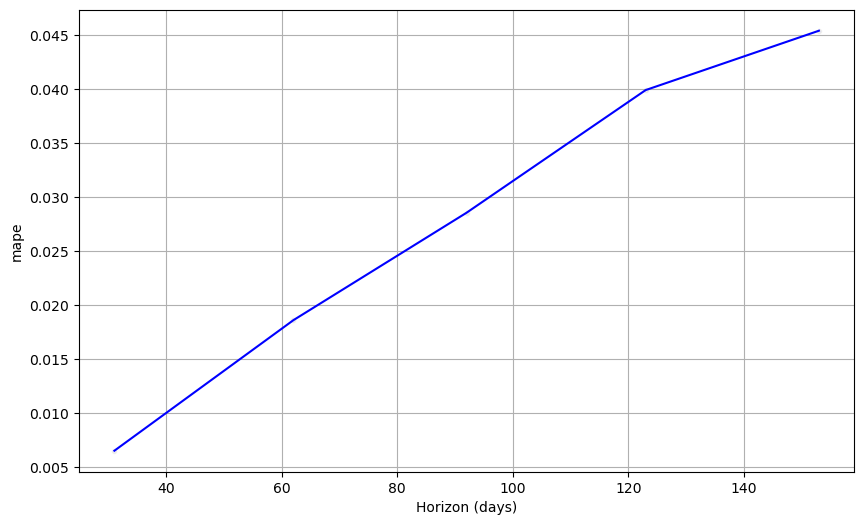

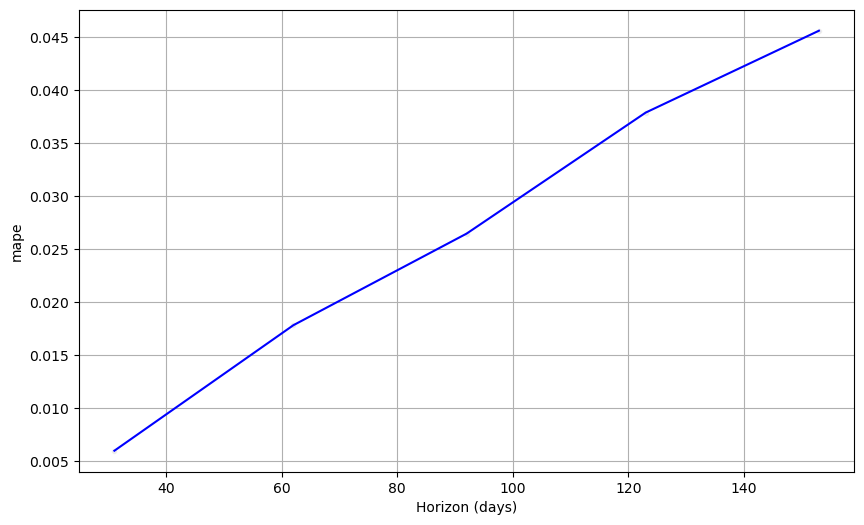

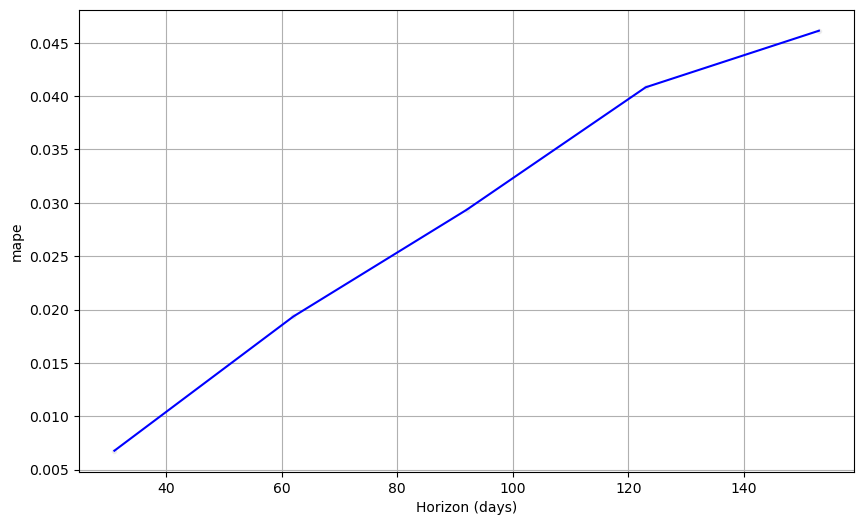

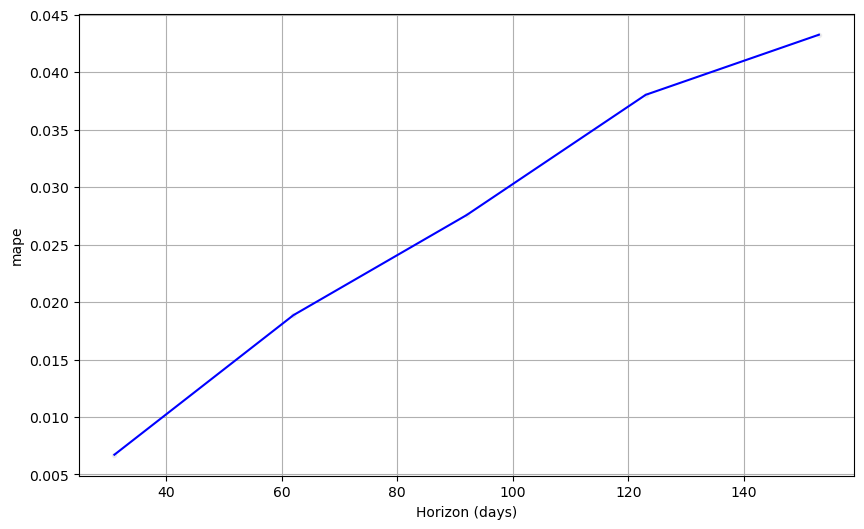

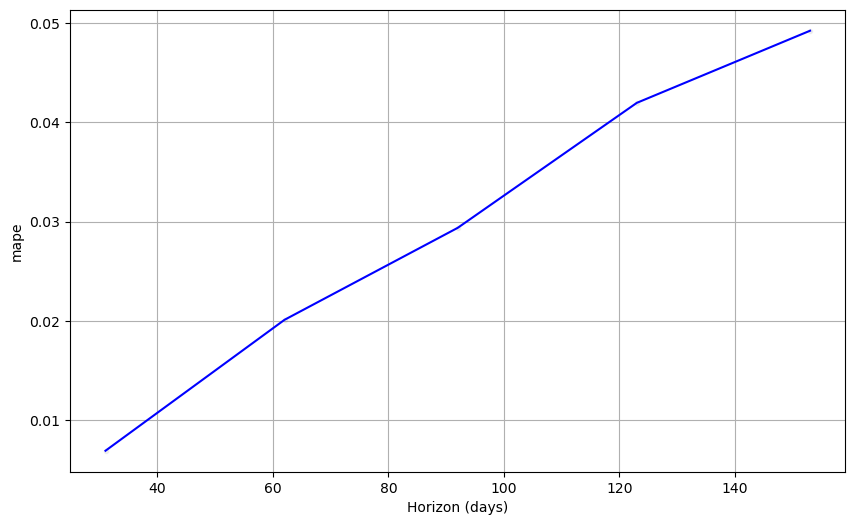

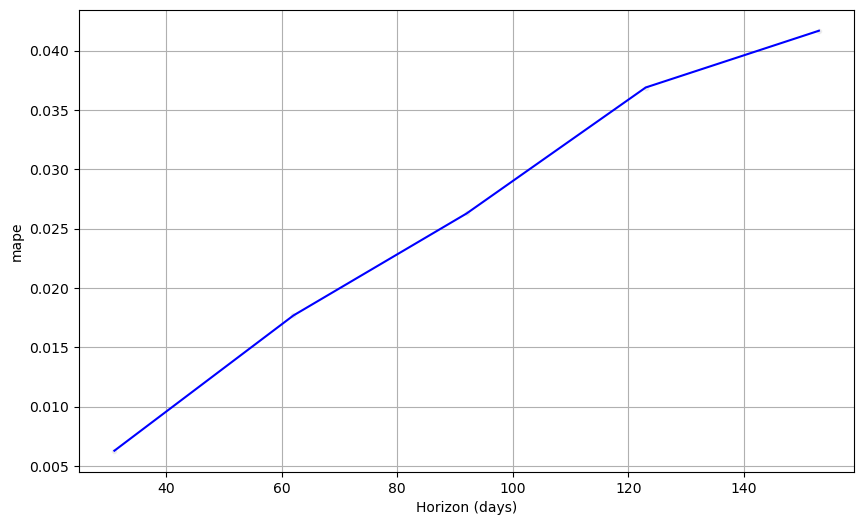

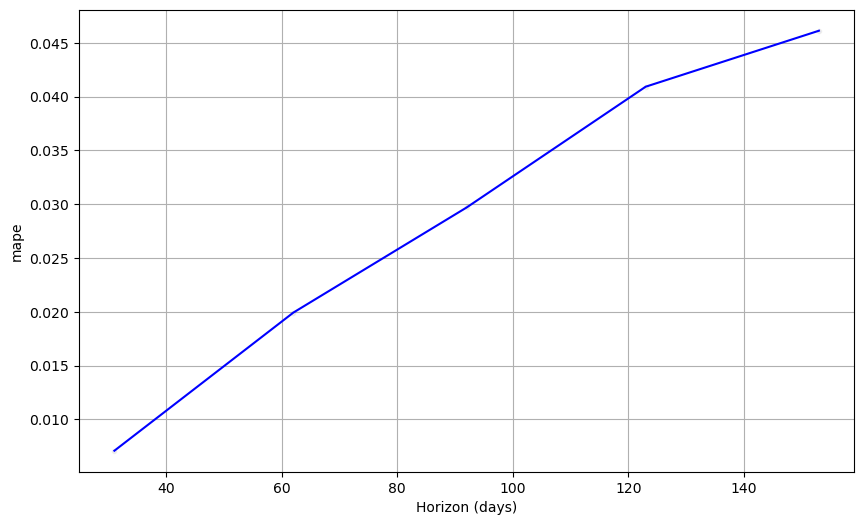

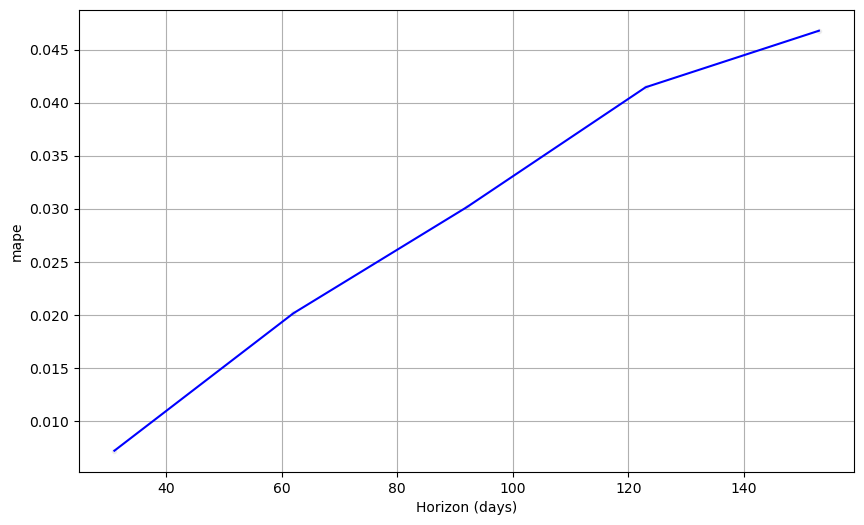

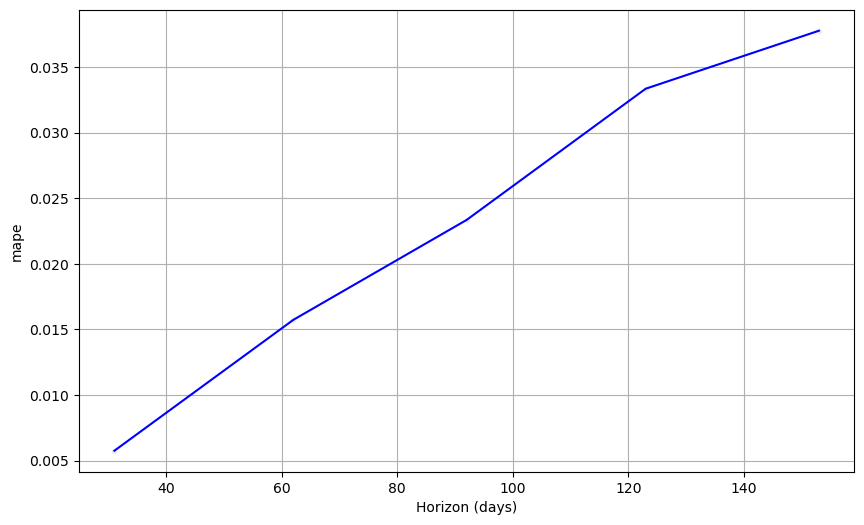

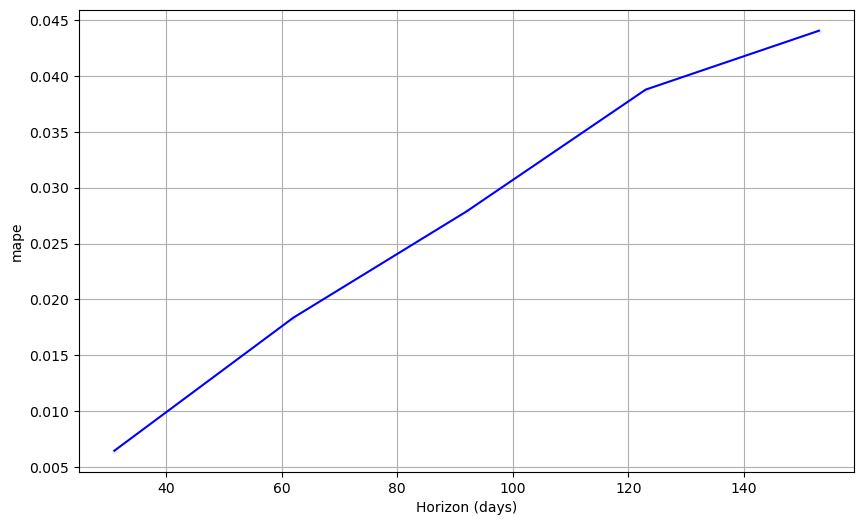

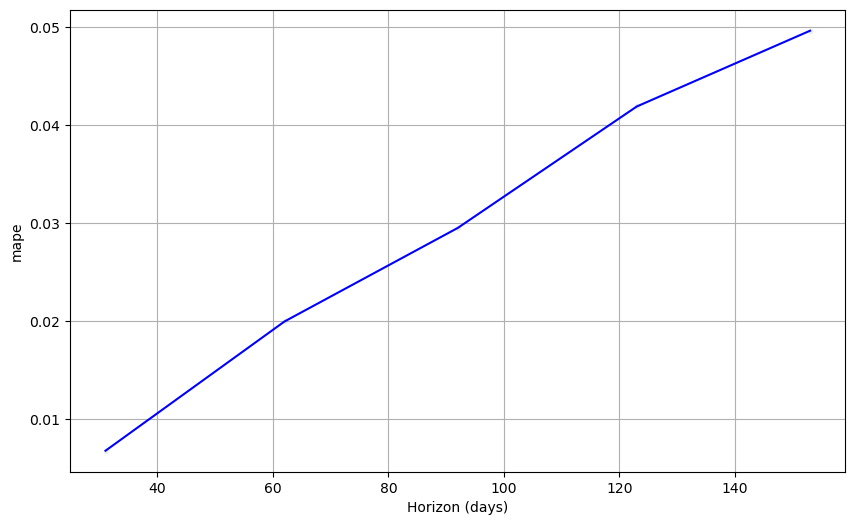

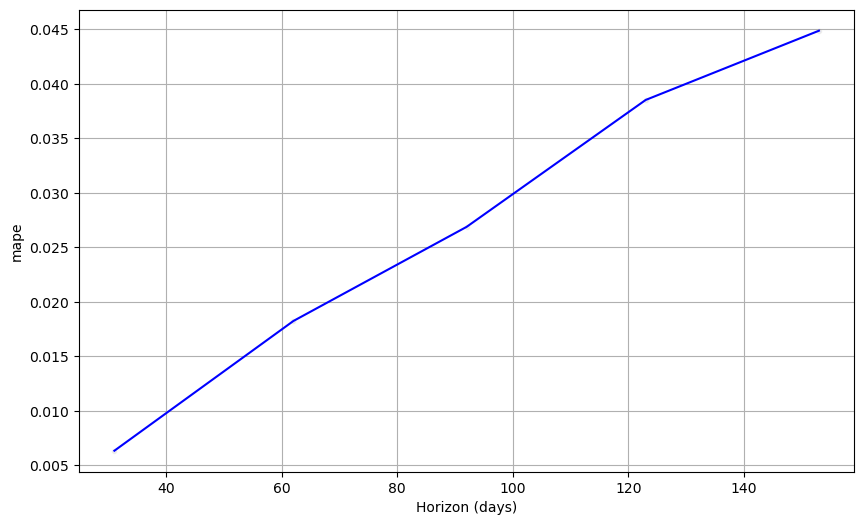

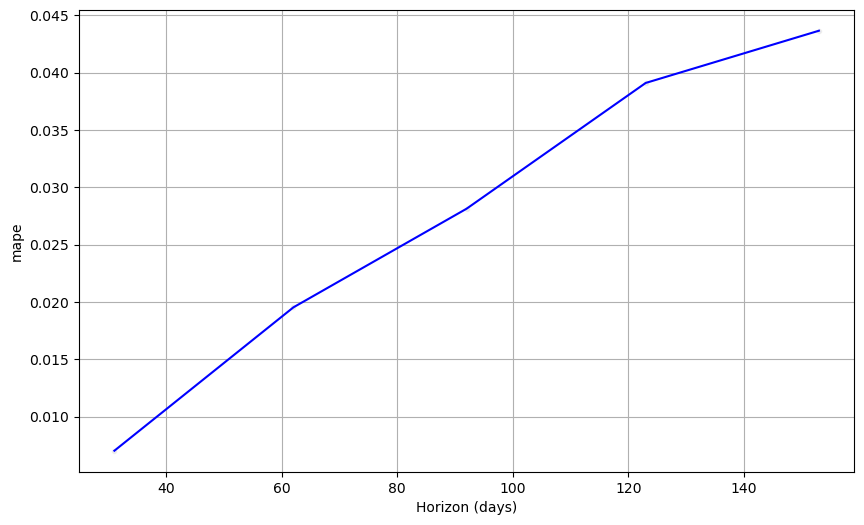

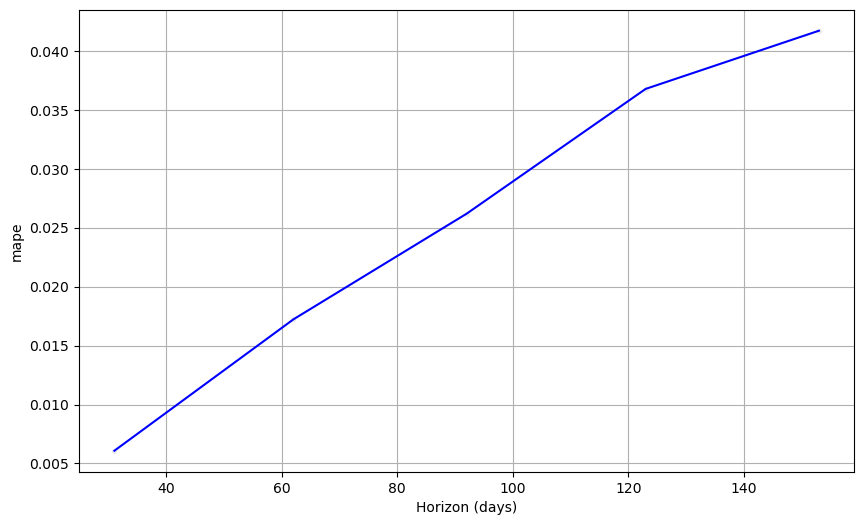

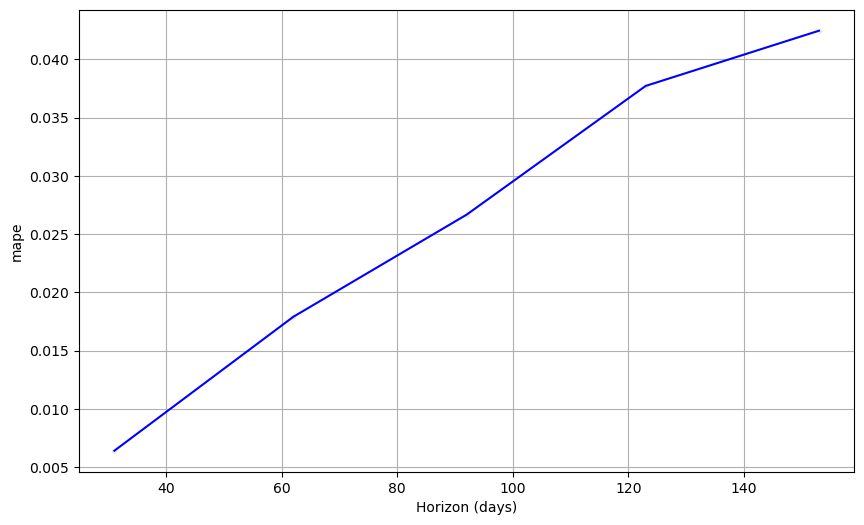

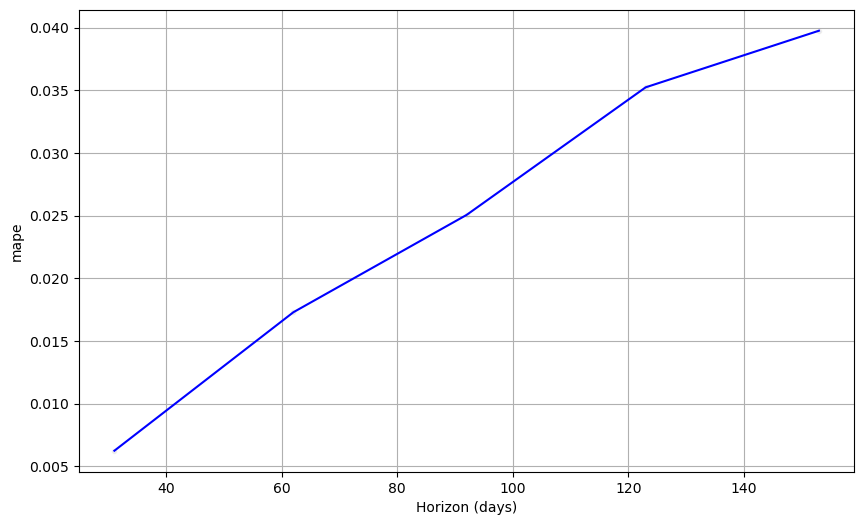

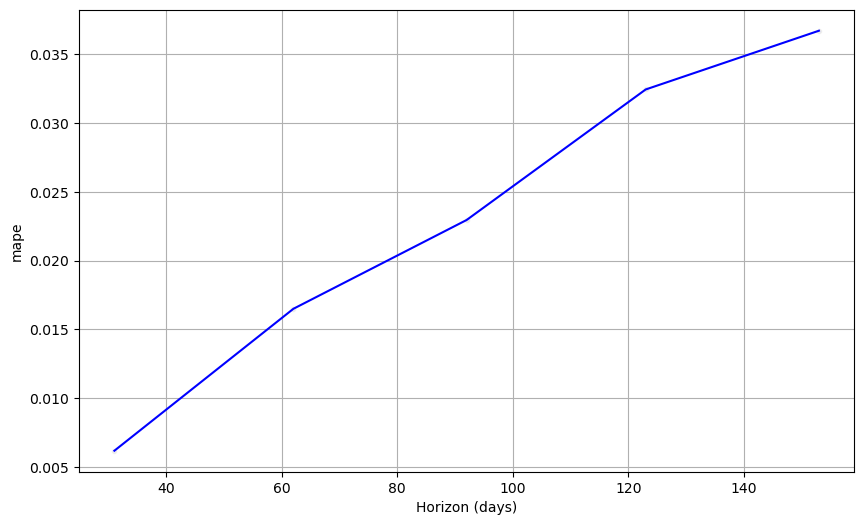

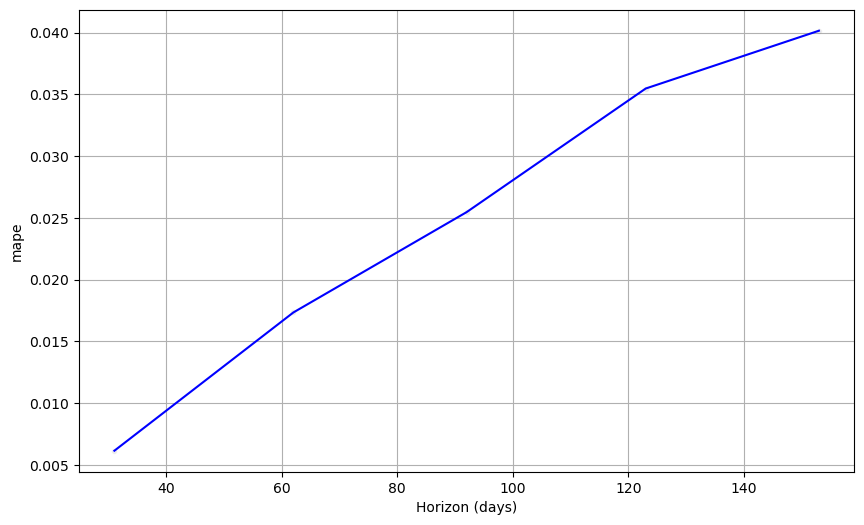

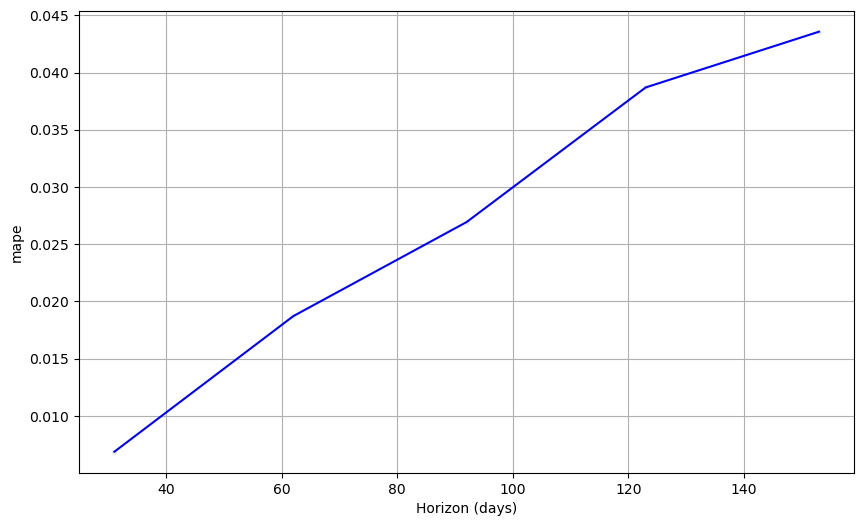

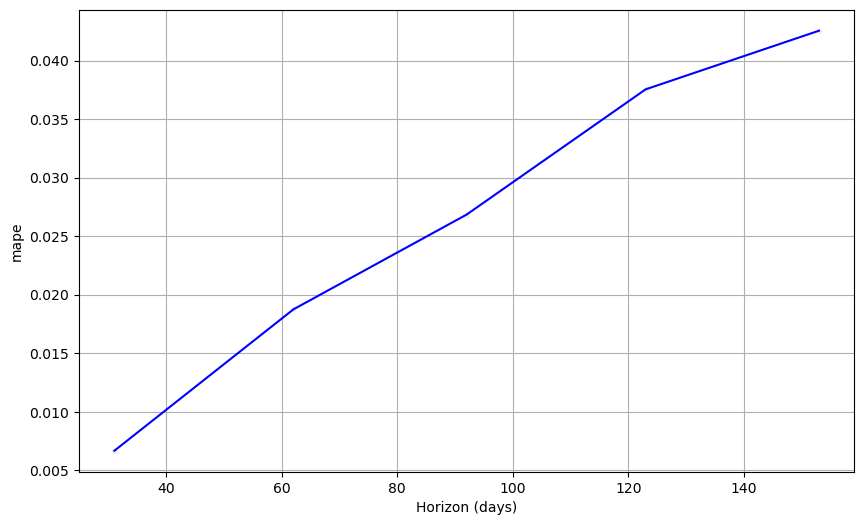

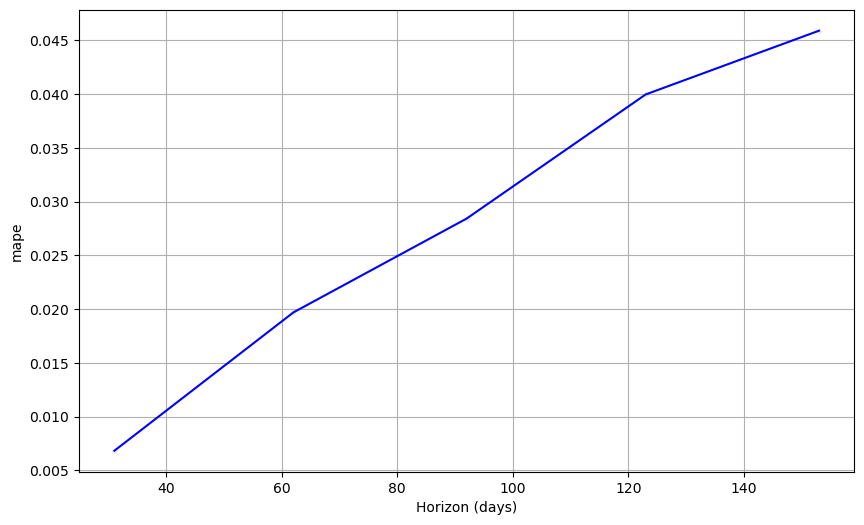

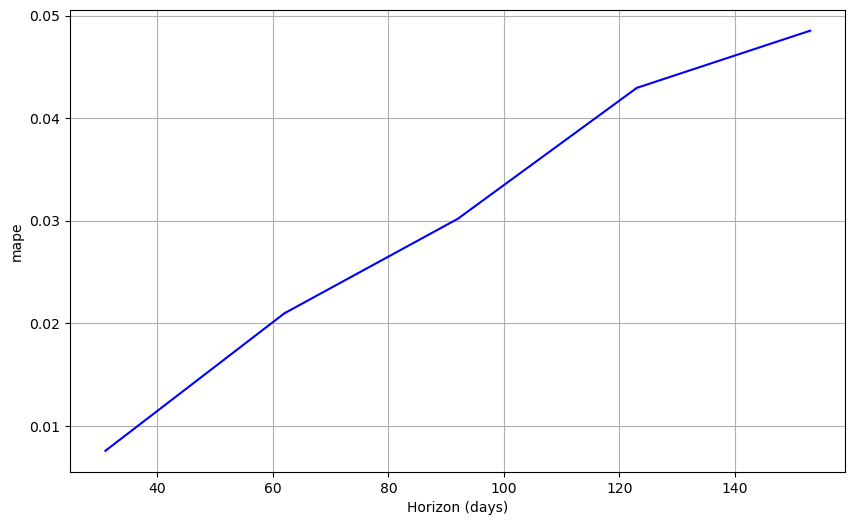

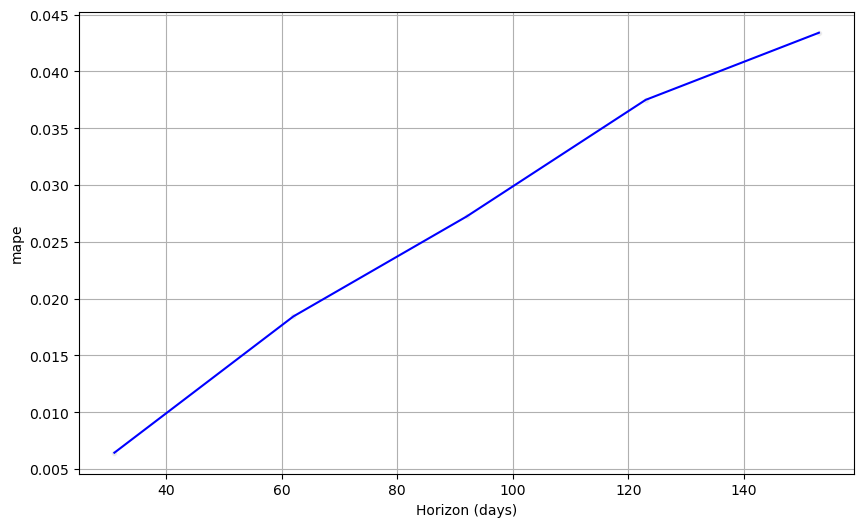

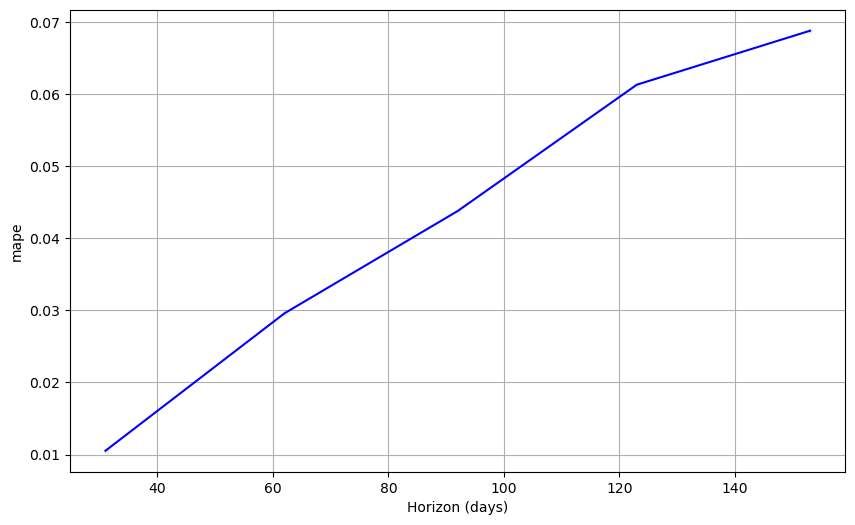

In [31]:
crossval_dict = {}

for zipcode in atl_df['zipcode'].unique():
    # filter for single zipcode
    zipcode_df = atl_df[atl_df['zipcode'] == zipcode]
    
    # initiate Prophet object and fit on zipcode 
    model = Prophet()
    model.fit(zipcode_df)
    
    cutoffs = pd.to_datetime(['2022-07-01'])
    df_cv = cross_validation(model, cutoffs=cutoffs, horizon='180 days')
    crossval_dict[zipcode] = df_cv
    
    plot_cross_validation_metric(df_cv, metric='mape')

In [33]:
for zipcode in atl_df['zipcode'].unique():
    print(crossval_dict[zipcode].head(10))    

          ds        yhat  yhat_lower  yhat_upper           y     cutoff
0 2022-08-01  189.267253  189.109870  189.424856  188.060380 2022-07-01
1 2022-09-01  191.506180  190.970484  192.028908  188.067941 2022-07-01
2 2022-10-01  193.606171  192.531759  194.646311  188.562950 2022-07-01
3 2022-11-01  195.746803  194.015919  197.374215  188.756183 2022-07-01
4 2022-12-01  197.237415  194.618925  199.605930  189.390041 2022-07-01
          ds        yhat  yhat_lower  yhat_upper           y     cutoff
0 2022-08-01  208.089130  207.897773  208.311281  206.607592 2022-07-01
1 2022-09-01  210.939318  210.284189  211.598583  206.715622 2022-07-01
2 2022-10-01  213.525461  212.257802  214.780585  207.338866 2022-07-01
3 2022-11-01  216.230238  214.279101  218.140211  207.397604 2022-07-01
4 2022-12-01  218.339110  215.652344  221.119598  208.126152 2022-07-01
          ds        yhat  yhat_lower  yhat_upper           y     cutoff
0 2022-08-01  222.671713  222.446440  222.891260  220.905364 202